## Current Distribution Reconstruction

In [8]:
import numpy as np
import re
import magpylib as mp
import matplotlib as mpl
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import torch
import contextlib # Used for managing plot settings
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import os
from typing import List, Tuple, Dict, Any, Set, Optional, Union
from collections import defaultdict
import colormaps as cmaps

from currio.utils import get_multipole_expansion_from_current_density
from currio.sensor import RegularGridSensor
from currio.compiled import get_b_njit

import magrec
from magrec.misc.sampler import GridSampler
from magrec.misc.plot import plot_vector_field_2d
from magrec.misc.plot import get_gridspec
from magrec.misc.plot import plot_n_components

### Functions

In [97]:
MM = 1e-3

def get_multipole_expansion_from_current_density(currents, pts, volume_element, order=0, r0=np.array([0, 0, 0])):
    """
    
    Input:
        currents: (array-like of length (N, 3)) list of current densities values in units of current (A/m^2)
        pts: (array-like of length (N, 3)) list of points between which the current is flowing
        volume_element: (float) volume element of the current density (m^3)
        
        order: (int) order of the multipole expansion
        
        r0: (array-like of length (3)) reference point for the multipole expansion, default: (0, 0, 0)
    """
    
    if order == 0:
        return np.sum(currents*volume_element, axis=0)
    
    if order == 1:
        return 0.5 * np.sum(np.cross((pts - r0[np.newaxis, :]), currents), axis=0) * volume_element
        # dimensions are: 
        # pts - r0: (N, 3) - (3,) = (N, 3)
        # currents: (N, 3)

def get_grid_multipole_expansion_time_3d_pad(current_density_series, pts,
                                        cell_size=None, grid_spec=None,
                                        volume_element=None, order=0):
    """
    Compute monopole expansion for each 3D cell (voxel) from time series of current densities. 

    Inputs:
    - current_density_series: (N, 3, T) array, current density at each point over time
    - pts: (N, 3) array, point coordinates
    - grid_spec (optional): (nx, ny, nz) number of cells along each axis
    - cell_size (optional): (dx, dy, dz) size of each cell
    - volume_element: float, volume per sample

    Outputs:
    - grid_monopoles_series: (nx, ny, nz, T, 3)
    - grid_centers_series: (nx, ny, nz, T, 3) centers repeated along time
    """

    _, _, T = current_density_series.shape

    if (grid_spec is None and cell_size is None) or (grid_spec is not None and cell_size is not None):
        raise ValueError("Provide either grid_spec or cell_size, not both.")

    xs, ys, zs = pts[:, 0], pts[:, 1], pts[:, 2]
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    z_min, z_max = zs.min(), zs.max()
    Lx, Ly, Lz = x_max - x_min, y_max - y_min, z_max - z_min

    if grid_spec is not None:
        nx, ny, nz = grid_spec
        dx = Lx / nx
        dy = Ly / ny
        dz = Lz / nz
        xmin_p, xmax_p = x_min, x_max
        ymin_p, ymax_p = y_min, y_max
        zmin_p, zmax_p = z_min, z_max
    else:
        dx, dy, dz = cell_size

        nx = int(np.ceil(Lx / dx))
        ny = int(np.ceil(Ly / dy))
        nz = int(np.ceil(Lz / dz))

        # padded sizes
        Lx_pad, Ly_pad, Lz_pad = nx * dx, ny * dy, nz * dz

        # symmetric padding
        pad_x = 0.5 * (Lx_pad - Lx)
        pad_y = 0.5 * (Ly_pad - Ly)
        pad_z = 0.5 * (Lz_pad - Lz)

        xmin_p, xmax_p = x_min - pad_x, x_max + pad_x
        ymin_p, ymax_p = y_min - pad_y, y_max + pad_y
        zmin_p, zmax_p = z_min - pad_z, z_max + pad_z


    # Edges and centers
    x_edges = np.linspace(xmin_p, xmax_p, nx + 1)
    y_edges = np.linspace(ymin_p, ymax_p, ny + 1)
    z_edges = np.linspace(zmin_p, zmax_p, nz + 1)

    grid_centers = np.zeros((nx, ny, nz, 3))
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                grid_centers[i, j, k, 0] = 0.5 * (x_edges[i] + x_edges[i+1])
                grid_centers[i, j, k, 1] = 0.5 * (y_edges[j] + y_edges[j+1])
                grid_centers[i, j, k, 2] = 0.5 * (z_edges[k] + z_edges[k+1])

    grid_monopoles_series = np.zeros((nx, ny, nz, T, 3))
    grid_centers_series = np.repeat(grid_centers[:, :, :, np.newaxis, :], T, axis=3)

    for t in range(T):
        J_t = current_density_series[:, :, t]  # (N, 3)
        for i in range(nx):
            for j in range(ny):
                for k in range(nz):
                    mask = (
                        (xs >= x_edges[i]) & (xs <= x_edges[i+1]) &
                        (ys >= y_edges[j]) & (ys <= y_edges[j+1]) &
                        (zs >= z_edges[k]) & (zs <= z_edges[k+1])
                    )
                    if np.any(mask):
                        r0_cell = grid_centers[i, j, k, :]
                        N = np.count_nonzero(mask)
                        delta_V = volume_element / N
                        grid_monopoles_series[i, j, k, t, :] = get_multipole_expansion_from_current_density(
                            J_t[mask], pts[mask], volume_element=delta_V, order=order, r0=r0_cell
                        )

    return grid_monopoles_series, grid_centers_series

def interpolate_slice_for_viz(pts, J, z_star, Nx=201, Ny=201, method='linear',
                              pad=0.0):
    """
    Interpolate scattered J(x,y,z) at fixed z=z_star onto a regular (Nx,Ny) grid
    for visualization. Physics should still use the scattered data.

    Inputs:
      pts : (N,3)
      J   : (N,3,1) or (N,3)
      z_star : z-slice (meters)
      Nx,Ny : output grid size
      method: 'linear' | 'cubic' | 'nearest' (for griddata)
      pad   : extra margin (meters) around [min,max] box for the grid

    Returns:
      X,Y : (Ny,Nx) meshgrid (indexing='xy')
      Jgrid : (3, Ny, Nx) interpolated components (NaN where outside hull)
    """
    pts = np.asarray(pts, float)
    J   = np.asarray(J,   float)
    if J.ndim == 3 and J.shape[2] == 1:
        J = J[..., 0]

    # filter points closest to z_star (tolerant slice)
    z = pts[:,2]
 
    z_levels = np.unique(np.round(z, 12))
    z0 = z_levels[np.argmin(np.abs(z_levels - z_star))]
    mask = np.isclose(z, z0, atol=1e-12)

    xy = pts[mask, :2]
    Jslice = J[mask, :]

    if xy.shape[0] < 3:
        raise ValueError("Not enough points at this z-slice to interpolate.")

    xmin, xmax = xy[:,0].min(), xy[:,0].max()
    ymin, ymax = xy[:,1].min(), xy[:,1].max()

    xg = np.linspace(xmin - pad, xmax + pad, Nx)
    yg = np.linspace(ymin - pad, ymax + pad, Ny)
    X, Y = np.meshgrid(xg, yg, indexing='xy')

    Jgrid = np.empty((3, Ny, Nx), dtype=float)
    for k in range(3):
        Jgrid[k] = griddata(xy, Jslice[:,k], (X, Y), method=method)

    return X, Y, Jgrid

def rescale_centers_to_index(grid_centers_xy, x_vals, y_vals, *, origin_lower=True, clip=True):
    """
    Map physical (x,y) centers to image index space [0..nx-1]x[0..ny-1]. The plot is given in the index space rather than in cartesian coordinates

    grid_centers_xy : (..., 2) array with [x, y] per center (slice already chosen).
    x_vals, y_vals  : 1D arrays of the coordinates used in the grid.
    origin_lower    : True if the plot has origin='lower' (matplotlib default for imshow with origin='lower'), otherwise False.
    """
    xs_unique = np.asarray(x_vals)
    ys_unique = np.asarray(y_vals)
    if xs_unique.size == 0 or ys_unique.size == 0:
        raise ValueError("x_vals / y_vals are empty")
    nx, ny = len(xs_unique), len(ys_unique)

    x_min, x_max = xs_unique.min(), xs_unique.max()
    y_min, y_max = ys_unique.min(), ys_unique.max()
    dx = (x_max - x_min)
    dy = (y_max - y_min)

    gc = np.asarray(grid_centers_xy, dtype=float).copy()
    # x index grows left→right
    gc[..., 0] = (gc[..., 0] - x_min) / dx * (nx - 1)

    # y index: choose direction based on plotting origin
    if origin_lower:
        # y increases bottom→top (imshow(origin='lower'))
        gc[..., 1] = (gc[..., 1] - y_min) / dy * (ny - 1)
    else:
        # y increases top→bottom
        gc[..., 1] = (y_max - gc[..., 1]) / dy * (ny - 1)

    if clip:
        gc[..., 0] = np.clip(gc[..., 0], 0, nx - 1)
        gc[..., 1] = np.clip(gc[..., 1], 0, ny - 1)
    return gc

def index_grid_centers(centers_flat, nx, ny, one_based=True):
    """
    centers_flat : (N,3) array of grid centers (N=nx*ny), already covering the rectangular grid.
    nx, ny       : grid dimensions
    one_based    : if True, keys in the dictionary are (1..nx, 1..ny).

    Returns:
      centers_idxed : ndarray shape (nx, ny, 3) with coordinates
      lookup        : dict mapping (row,col) -> (x,y,z)
    """
    centers = centers_flat.reshape(nx, ny, 3)  # assumes they were generated row by row
    lookup = {}
    for i in range(nx):
        for j in range(ny):
            key = (i+1, j+1) if one_based else (i, j)
            lookup[key] = tuple(centers[i, j])
    return centers, lookup

CBAR_PORTION = 0.05  # portion of width allocated to each colorbar

def get_gridspec_colormap_plot_colormap():
    """
    Returns a GridSpec with 3 columns: colormap1 | plot | colormap2
    """
    return gridspec.GridSpec(
        nrows=1, 
        ncols=3,
        width_ratios=[CBAR_PORTION, 1, CBAR_PORTION],
        wspace=0.1
    )

def plot_vector_field_2d_monopoles(current_distribution, grid_monopoles, grid_centers, ax: plt.Axes = None, 
                         interpolation='none', cmap='plasma', monopole_cmap='viridis' ,color='black', units=None,
                         units_mono=None, title=None, show=False, num_arrows=20, zoom_in_region=None):
    """
    Visualizes the current distribution in 2D as a heatmap of magnitudes and arrows representing the flow direction.
    On top of the heatmap, the monopoles are plotted with direction given by the components and magnitude by the colormap
    
    Parameters:
    ----------
    current_distribution : ndarray
        An array of shape (2, W, H) representing current distribution vectors.

    grid_monopoles : ndarray
        An array of shape (n_columns, n_rows, 3) representing the monopoles computed for each element in the grid

    grid_centers : ndarray
        An array of shape (n_columns, n_rows, 2), representing the coordinates for the centers of each element in the grid
    
    interpolation : str, optional
        The interpolation method to be used for the heatmap. Options are as provided by matplotlib's `imshow`.
        Default is 'none'.
    
    cmap : str, optional
        The colormap to be used for the heatmap. Options are as provided by matplotlib's colormaps.
        Default is 'plasma'.

    monopole_cmap : str, optional
        The colormap to be used for the monopoles magnitude. Options are as provided by matplotlib's colormaps.
        Default is 'viridis'.

    The 'inferno' & 'cool' combination provides ease of view for the quivers with respect to the background. 
        
    color : str, optional
        The color of the arrows. Default is 'black'.
            
    units : str, optional
        Show units on the colorbar for the current distribution. Default is None (no units).

    units_mono : str, optional
        Show units on the colorbar for the monopoles magnitude. Default is None (no units).
        
    title: str, optional
        Title of the plot. Default is None (no title).
    
    show : bool, optional
        If True, the plot is displayed using `plt.show()`. Otherwise, the plot is returned without being shown.
        Default is False.
    
    num_arrows : int, optional
        The approximate number of arrows to be used for the quiver plot across the width of the image.
        The function will adjust the number of arrows to avoid overcrowding. Default is 20.
    
    zoom_in_region : tuple of two tuples, optional
        A tuple representing the top-left and bottom-right corners of the rectangle for the inset. The format is 
        ((index_x_origin, index_y_origin), (index_x_diagonal, index_y_diagonal)). If provided, the function will render 
        the specified inset region with an arrow indicating the average flow direction. Default is None.
    
    Returns:
    -------
    fig : Figure
        A matplotlib figure containing the visualizations.

    Notes:
    -----
    - The main visualization provides a heatmap of the magnitudes and arrows indicating the flow direction of the 
      current distribution, and on top of that the arrows for the monopoles computed are plotted with the magnitude given by the colormap.
    - The inset, if specified, provides a zoomed-in view of a particular region of the main visualization, allowing for 
      a closer inspection of details.

    Examples:
    --------
    >>> dist = np.random.rand(2, 100, 100)
    >>> fig = plot_vector_field_2d(dist, interpolation='bilinear', cmap='inferno', show=True, num_arrows=30, inset_region=((20, 20), (40, 40)))
    """  
    # PARAMS
    # figsize = get_figsize(n_components=1, n_maps=1, alignment='horizontal')
    
    # Create a figure with an axis if none is provided
    if ax is None:
        fig = plt.figure(frameon=False)
        gs = get_gridspec_colormap_plot_colormap()

        # Main plot
        ax = fig.add_subplot(gs[1])

        # Main plot position
        ax_pos = ax.get_position()

        # Customization parameters
        cbar_height_ratio = 0.7  
        cbar_width = 0.03      
        cbar_padding = 0.1    

        # The colorbars are positioned with respect to the center of the plot
        ax_center_y = ax_pos.y0 + 0.5 * ax_pos.height
        cbar_height = ax_pos.height * cbar_height_ratio
        cbar_bottom = ax_center_y - 0.5 * cbar_height

        left_cbar_x = ax_pos.x0 - cbar_width - cbar_padding
        cax_left = fig.add_axes([left_cbar_x, cbar_bottom, cbar_width, cbar_height])

        right_cbar_x = ax_pos.x1 + cbar_padding
        cax_right = fig.add_axes([right_cbar_x, cbar_bottom, cbar_width, cbar_height])
    else:
        fig = ax.get_figure()
        try:
            cax_right = ax.cax2
            cax_left = ax.cax1
        except AttributeError:
            divider = make_axes_locatable(ax)
            cax_right = divider.append_axes("right", size="5%", pad=0.05)
            cax_left = divider.append_axes("left", size="5%", pad=0.05)

        
    if isinstance(current_distribution, torch.Tensor):
        current_distribution = current_distribution.detach().cpu().numpy()
        
    W, H = current_distribution.shape[-2:]
    step_size = max(W, H) // num_arrows
    
    # Create averaged grid
    x_centers = np.arange(step_size // 2, W, step_size)
    y_centers = np.arange(step_size // 2, H, step_size)
    
    x_grid, y_grid = np.meshgrid(x_centers, y_centers, indexing='ij')
    
    # Initialize averaged fields
    avg_u = np.zeros((len(x_centers), len(y_centers)))
    avg_v = np.zeros((len(x_centers), len(y_centers)))
    avg_m = np.zeros((len(x_centers), len(y_centers)))
    
    # Loop through and average
    for i, x in enumerate(x_centers):
        for j, y in enumerate(y_centers):
            x_low, x_high = x - step_size // 2, x + step_size // 2 + 1
            y_low, y_high = y - step_size // 2, y + step_size // 2 + 1
            
            avg_u[i, j] = np.mean(current_distribution[0, x_low:x_high, y_low:y_high])
            avg_v[i, j] = np.mean(current_distribution[1, x_low:x_high, y_low:y_high])
            avg_m[i, j] = np.sqrt(avg_v[i, j] ** 2 + avg_u[i, j] ** 2)
    
    magnitudes = np.hypot(current_distribution[0], current_distribution[1]).transpose(1, 0)
    
    im = ax.imshow(magnitudes, interpolation=interpolation, vmin=0, cmap=cmap, origin='lower')
    
    cbar = fig.colorbar(im, cax=cax_left, orientation='vertical')
    cax_left.yaxis.set_ticks_position('left')
    cax_left.yaxis.set_label_position('left')
    if units:
        cax_left.set_title(f"Current field [{units}]", fontsize=9, loc='center')
        
    if title:
        if isinstance(title, str):
            # Use .annotate() method to add the title text at the top of the figure
            ax.annotate(title, xy=(0.5, 1.1), xycoords='axes fraction',
                        xytext=(0, 0), textcoords='offset points',
                        ha='center', va='baseline')
    
    # Compute scale of the arrow length. 
    # Scale gives number of data points per arrow length unit, 
    # e.g. A/mm^2 per plot width. We want the maximum arrow length to be 1/num_arrows of the plot width.
    # How much data units per arrow length unit? 
    scale = 1.1 * avg_m.max() * num_arrows  # 1.1 to make the length of the longest arrow a bit shorter 
                                            # than the spacing between arrows blocks.  
    
    ax.quiver(
        x_grid, y_grid, avg_u, avg_v, color=color,
        pivot='mid', units='width', angles='uv',
        scale=scale, scale_units='width',
    )
    
    # --- Monopole Quivers ---
    X = grid_centers[:, :, 0].flatten()
    Y = grid_centers[:, :, 1].flatten()
    U = grid_monopoles[:, :, 0].flatten()
    V = grid_monopoles[:, :, 1].flatten()
    W = grid_monopoles[:, :, 2].flatten()
    magnitudes_mono = np.sqrt(U**2 + V**2 + W**2)

    # To avoid overcrowding of the plot, the quivers for the monopoles direction have a length that is half the distance with the nearest 
    # element of the cell
    dx = np.mean(np.diff(grid_centers[:, 0, 0]))  
    dy = np.mean(np.diff(grid_centers[0, :, 1]))  

    spacing = min(dx, dy)

    # Normalize direction
    norms_xy = np.sqrt(U**2 + V**2)
    U_norm = np.divide(U, norms_xy, out=np.zeros_like(U), where=norms_xy != 0)
    V_norm = np.divide(V, norms_xy, out=np.zeros_like(V), where=norms_xy != 0)

    # Fixed arrow length
    arrow_length = spacing * 0.5 # The value can be tweaked according to preference
    U_fixed = U_norm * arrow_length
    V_fixed = V_norm * arrow_length

    # Plot arrows e
    q = ax.quiver(
        X, Y, U_fixed, V_fixed, magnitudes_mono,
        cmap=monopole_cmap,
        scale_units='xy',  
        scale=1,          
        width=0.004,
        headlength=6,
        headaxislength=5,
        headwidth=4
)

    
    cb2 = fig.colorbar(q, cax=cax_right, orientation='vertical')
    if units_mono:
        cax_right.set_title(f"Monopole [{units_mono}]", fontsize=9, loc='center')

    if zoom_in_region is not None:
        x0, y0 = zoom_in_region[0]
        x1, y1 = zoom_in_region[1]
        axins = inset_axes(ax, width="30%", height="30%", loc='upper left')
        axins.imshow(magnitudes[x0:x1, y0:y1], cmap=cmap, origin='lower')
        
        axins.set_xticks([])
        axins.set_yticks([])
        
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')
    
    if not show:
        plt.close()
        
    return fig

def get_b_from_monopoles_to_grid(grid_centers_series, grid_monopole_series, obs_pts, Nx, Ny):
    """
    Computes the magnetic field from the monopoles
    
    Inputs: 
    - grid_centers_series : ndarray, array of size (nx, ny, nz, T, 3). 
    - grid_monopole_series: ndarray, array of size (nx, ny, nz, T, 3).
    - obs_pts : ndarray, array of size (Nx*Ny, 3), sensor grid points (time-independent)
    
    Output:
    - B_grid : ndarray, array of size (3, Nx, Ny, T), magnetic field in T
    """

    MU0_OVER_4PI = 1e-7
    nx, ny, nz, T, _ = grid_monopole_series.shape
    N = nx * ny * nz
    M = obs_pts.shape[0]
    assert M == Nx*Ny, "obs_pts must match Nx*Ny"

    # Flatten sources to (N, T, 3)
    m_flat  = grid_monopole_series.reshape(N, T, 3)
    r0_flat = grid_centers_series.reshape(N, T, 3)

    # Centers are constant over time so grid_center_series(t0)=grid_center_series(t)

    R = obs_pts[None, :, :] - r0_flat[:, 0, :][:, None, :]   # (N, M, 3)
    R2  = np.sum(R*R, axis=2)                                # (N, M)
    R32 = (R2) * np.sqrt(R2)                                 # (N, M)

    B = np.empty((M, 3, T), dtype=m_flat.dtype)
    for t in range(T):
        mt = m_flat[:, t, :]                                 # (N, 3)
        m_cross_R = np.cross(mt[:, None, :], R, axis=2)      # (N, M, 3)
        Bt = (m_cross_R / R32[..., None]).sum(axis=0)        # (M, 3)
        B[:, :, t] = MU0_OVER_4PI * Bt

    return B.transpose(1,0,2).reshape(3, Nx, Ny, T)

def grid_graph_from_monopoles(grid_centers):
    """
    Build upright square lattice (grid graph) connections from a static 2D grid of 3D points. Assume they are sorted. The grid is generated as the
    cartesian graph product of the path graphs

    Input:
    - grid_centers: ndarray, array of size (n_rows, n_cols, n_frames, 3). Grid of static 3D points.

    Output:
    - edges: list of ((x1, y1, z1), (x2, y2, z2)) tuples. Edges connecting each point to its right and top neighbors.
    """
    
    n_rows, n_cols, _, _ = grid_centers.shape
    edges = []
    
    # Only use frame 0 since all are equal
    grid = grid_centers[:, :, 0, :]

    for i in range(n_rows):
        for j in range(n_cols):
            p = grid[i, j]

            # Right neighbor
            if j + 1 < n_cols:
                p_right = grid[i, j + 1]
                edges.append((p, p_right))
            
            # Top neighbor
            if i + 1 < n_rows:
                p_top = grid[i + 1, j]
                edges.append((p, p_top))
    
    return edges

def draw_roi_box(fig, bounds_phys, full_bounds_phys,
                 color='white', lw=1.5, ls='--', alpha=0.95, mark_center=True):
    """
    Overlay a rectangle for a physical ROI on the first axes of `fig` whose image
    is drawn in INDEX space.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
    bounds_phys : (xmin, xmax, ymin, ymax) in meters   # from roi_from_two_coords(...)
    full_bounds_phys : (Xmin, Xmax, Ymin, Ymax) meters # the physical area shown by imshow
    color, lw, ls, alpha : styling
    mark_center : if True, put a dot at the ROI center

    Returns
    -------
    ax, idx_box : (Axes, (x0i, x1i, y0i, y1i)) in index coordinates
    """
    if not fig.axes:
        raise RuntimeError("Figure has no axes. Did the plot function close it?")
    ax = fig.axes[0]
    if not ax.images:
        raise RuntimeError("No imshow image found on axes to infer index size.")

    # raster size in index space
    arr = ax.images[0].get_array()
    H, W = arr.shape

    # map physical → index coordinates
    xmin, xmax, ymin, ymax = bounds_phys
    Xmin, Xmax, Ymin, Ymax = full_bounds_phys
    x0i = (xmin - Xmin) * (W / (Xmax - Xmin))
    x1i = (xmax - Xmin) * (W / (Xmax - Xmin))
    y0i = (ymin - Ymin) * (H / (Ymax - Ymin))
    y1i = (ymax - Ymin) * (H / (Ymax - Ymin))
    idx_box = (x0i, x1i, y0i, y1i)

    # draw rectangle
    ax.plot([x0i, x1i, x1i, x0i, x0i],
            [y0i, y0i, y1i, y1i, y0i],
            color=color, lw=lw, ls=ls, alpha=alpha, zorder=12)

    if mark_center:
        cx_i = 0.5*(x0i + x1i)
        cy_i = 0.5*(y0i + y1i)
        ax.scatter([cx_i], [cy_i], s=30, c=color, zorder=13)

    fig.canvas.draw_idle()
    return ax, idx_box

def roi_from_center(p1, p2, half_size=2.5*MM):
    """
    p1, p2: (x,y,z) coordinates of opposite vertices
    half_size: half-size in meters
    """
    p1, p2 = np.array(p1[:2]), np.array(p2[:2])  # only x,y
    center = 0.5*(p1+p2)
    cx, cy = center
    xmin, xmax = cx - half_size, cx + half_size
    ymin, ymax = cy - half_size, cy + half_size
    return {
        'center': (cx, cy),
        'bounds': (xmin, xmax, ymin, ymax)
    }
    
def filter_edges_in_roi(edges, bounds):
    """Keep edges whose both endpoints lie inside ROI (meters)."""
    xmin, xmax, ymin, ymax = bounds
    def inside(p):
        return (xmin <= p[0] <= xmax) and (ymin <= p[1] <= ymax)
    kept = []
    for p, q in edges:
        p = tuple(np.asarray(p, float)); q = tuple(np.asarray(q, float))
        if inside(p) and inside(q):
            kept.append((p, q))
    return kept

def centers_in_roi_mask(centers, bounds):
    xmin, xmax, ymin, ymax = bounds
    X = centers[...,0]; Y = centers[...,1]
    return (X >= xmin) & (X <= xmax) & (Y >= ymin) & (Y <= ymax)

def plot_geometry(bounds, gcs_z0, edges,
                              dead_each=0.4e-3,
                              elev=28, azim=37, loops=None,
                              vias=None):
    """
    Plot slab, ROI grid centers, edges, and a list of circular current loops.
    Handles both 3D (N, N, 3) and 4D (Ny, Nx, N_frames, 3) center arrays.
    
    Args:
        bounds (tuple): (xmin, xmax, ymin, ymax, zmin, zmax)
        gcs_z0 (np.array): Center grid. Can be 3D or 4D.
        edges (list): List of edge segments.
        ... other args ...
        central_subsegment_func: Pass your central_subsegment function here.
    """
    xmin, xmax, ymin, ymax, zmin, zmax = bounds

    z_min_plot = zmin
    if vias is not None and len(vias) > 0:
        # Check the lowest Z coordinate among all via endpoints
        all_z = [p[2] for p_start, p_end in vias for p in (p_start, p_end)]
        z_min_plot = min(zmin, min(all_z))

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    # ---- slab ----
    corners = np.array([
        [xmin, ymin, zmin],[xmax, ymin, zmin],[xmax, ymax, zmin],[xmin, ymax, zmin],
        [xmin, ymin, zmax],[xmax, ymin, zmax],[xmax, ymax, zmax],[xmin, ymax, zmax],
    ])
    faces = [[corners[j] for j in f] for f in
             [(0,1,2,3),(4,5,6,7),(0,1,5,4),(2,3,7,6),(1,2,6,5),(0,3,7,4)]]
    slab = Poly3DCollection(faces, facecolors='gray', linewidths=1,
                            edgecolors='gray', alpha=0.15)
    ax.add_collection3d(slab)

    # ---- grid points (frame 0) ----
    # UNIFIED LOGIC: Check dimensions to handle 3D (new) or 4D (old) input
    if gcs_z0.ndim == 4:
        # Original format: (Ny, Nx, N_frames, 3) -> take frame 0
        grid_points = gcs_z0[:, :, 0, :]
    elif gcs_z0.ndim == 3:
        # New format: (N, N, 3) -> use directly
        grid_points = gcs_z0
    else:
        raise ValueError(f"Input gcs_z0 array has unexpected dimension: {gcs_z0.ndim}. Expected 3 or 4.")
        
    ax.scatter(grid_points[...,0], grid_points[...,1], grid_points[...,2], c='#c64a25', s=14)

    # ---- Plotting the Edges (RE-ADDED) ----
    if edges is not None:
        for count, edge in enumerate(edges):
            ps, qs = edge[0], edge[1]

            # Apply trimming only if dead_each is specified AND the function is provided
            ps_trim, qs_trim = ps, qs
            if dead_each > 0:
                ps_trim, qs_trim = central_subsegment(ps, qs, dead_each=dead_each)
            
            ax.plot([ps_trim[0], qs_trim[0]], [ps_trim[1], qs_trim[1]], [ps_trim[2], qs_trim[2]], '#1e2a38', lw=2.0)
    
    if vias is not None:
        # vias is a list of lists, where each element is [p_via, q_via]
        for p_via, q_via in vias:
            # Plot the vertical wire
            ax.plot([p_via[0], q_via[0]], [p_via[1], q_via[1]], [p_via[2], q_via[2]], 
                    color='blue', lw=1.5, linestyle='--')
    
    # ---- Plotting the Loops ----
    if loops is not None:
        for loop_info in loops:
            center_x = loop_info['center_x']
            center_y = loop_info['center_y']
            center_z = loop_info['center_z']
            radius = loop_info['radius']
            
            Nloop = 100
            theta = np.linspace(0, 2*np.pi, Nloop)
            x_loop = center_x + radius * np.cos(theta)
            y_loop = center_y + radius * np.sin(theta)
            z_loop = np.full_like(x_loop, center_z)
            
            ax.plot(x_loop, y_loop, z_loop, color='red', linewidth=2)
            ax.scatter(center_x, center_y, center_z, c='red', s=8, marker='o')

    # ---- axes ----
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_zlim(z_min_plot, zmax)
    ax.set_box_aspect([1,1,0.1])
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')    
    
    plt.tight_layout()
    plt.show()
    return fig, ax

def _unit(v, fallback):
    n = np.linalg.norm(v)
    if n == 0.0:
        return np.array(fallback, dtype=float)
    return v / n

def build_equal_volume_prisms(edges_roi, dx, dy, zmin, zmax, dead_each=0.4e-3):
    """
    Build one rectangular prism per edge, centered at the active (trimmed) segment midpoint.
    Geometry (identical cross-section for all prisms):
      - length  = L_eff  (|central_subsegment|)
      - width   = cell width perpendicular to the edge (dy for horizontal, dx for vertical)
      - height  = slab thickness (zmax - zmin)
    Returns:
      prisms: list of dicts with keys:
        'p','q'        : original edge endpoints
        'ps','qs'      : trimmed endpoints (active subsegment)
        'center'       : midpoint of active subsegment
        't_hat'        : unit tangent (along edge)
        'n_perp'       : in-plane unit normal (perpendicular in xy)
        'L_eff'        : active length
        'half_width'   : width/2 (perpendicular in-plane)
        'half_thick'   : height/2 (z)
        'A_cross'      : cross-section area (width * height)
        'volume'       : A_cross * L_eff
        'orientation'  : 'h' (horizontal) or 'v' (vertical)
    """
    prisms = []
    height = float(zmax - zmin)
    half_thick = 0.5 * height

    for (p_raw, q_raw) in edges_roi:
        p = np.asarray(p_raw, float)
        q = np.asarray(q_raw, float)

        L_new = float(np.linalg.norm(q-p))

        # Active subsegment & length
        ps, qs = central_subsegment(p, q, dead_each=dead_each)
        e_act = qs - ps
        L_eff = float(np.linalg.norm(e_act))
        if L_eff == 0.0:
            # Degenerate; skip
            continue

        t_hat = _unit(e_act, fallback=[1,0,0])

        # Orientation & width (perpendicular cell size)
        horiz_like = abs(q[0] - p[0]) >= abs(q[1] - p[1])
        if horiz_like:
            width = float(dy)             # perpendicular to x-edge is y
            orientation = 'h'
        else:
            width = float(dx)             # perpendicular to y-edge is x
            orientation = 'v'
        half_width = 0.5 * width

        # In-plane perpendicular unit vector (xy)
        t_xy = t_hat.copy(); t_xy[2] = 0.0
        if np.allclose(t_xy, 0.0):
            n_perp = np.array([1.0, 0.0, 0.0], dtype=float)
        else:
            n_perp = _unit(np.array([-t_xy[1], t_xy[0], 0.0]), fallback=[1,0,0])

        center = 0.5 * (ps + qs)
        A_cross = width * height
        volume = A_cross * L_new

        prisms.append(dict(
            p=p, q=q, ps=ps, qs=qs,
            center=center,
            t_hat=t_hat, n_perp=n_perp,
            L_eff=L_eff,                   # placement length
            L_int=L_new,  
            half_width=half_width, half_thick=half_thick,
            A_cross=A_cross, volume=volume,
            orientation=orientation
        ))
    return prisms

def prism_corners_from_dict(pr):
    """Return (8,3) array of prism corners using fields in the prism dict."""
    import numpy as np
    c        = pr['center']
    t_hat    = pr['t_hat']
    n_perp   = pr['n_perp']
    z_hat    = np.array([0.0, 0.0, 1.0])
    Lh       = 0.5 * pr['L_int']
    a        = pr['half_width']
    b        = pr['half_thick']

    # local corners (u along t_hat, v along n_perp, w along ẑ)
    corners_local = np.array([
        [-Lh,-a,-b], [-Lh,-a,+b], [-Lh,+a,+b], [-Lh,+a,-b],
        [+Lh,-a,-b], [+Lh,-a,+b], [+Lh,+a,+b], [+Lh,+a,-b],
    ])
    T = np.vstack([t_hat, n_perp, z_hat]).T
    return c + corners_local @ T.T

def get_A_matrix(obs_pts, pcb_edges):
    """
    Builds the A matrix for the least-squares problem using get_b_njit.
    """
    N_ROI = obs_pts.shape[0]
    M = len(pcb_edges)
    A = np.zeros((3 * N_ROI, M), dtype=np.float64)
    current_unit_I = np.ones((1, 1), dtype=np.float64)

    for j, edge in enumerate(pcb_edges):
        r_start = np.array([edge[0]])
        r_end = np.array([edge[1]])
        current_pts_segment = np.concatenate((r_start, r_end), axis=0)

        B_field = get_b_njit(current_pts_segment, np.ascontiguousarray(obs_pts), current_unit_I)
        A_column = B_field.reshape(3 * N_ROI)
        A[:, j] = A_column

    return A

def get_A_matrix_vias(obs_pts, vias, sign=1.0):
    """
    Builds the A matrix for the least-squares problem using get_b_njit.
    """
    N_ROI = obs_pts.shape[0]
    M = len(vias)
    A = np.zeros((3 * N_ROI, M), dtype=np.float64)
    current_unit_I = np.ones((1, 1), dtype=np.float64)

    for j, edge in enumerate(vias):
        r_start = np.array([edge[0]])
        r_end = np.array([edge[1]])
        current_pts_segment = np.concatenate((r_start, r_end), axis=0)

        B_field = get_b_njit(current_pts_segment, np.ascontiguousarray(obs_pts), sign*current_unit_I)
        B_field = -B_field
        A_column = B_field.reshape(3 * N_ROI)
        A[:, j] = A_column

    return A

def generate_lcurve_data(A, B_truth_vector, lambda_vals):
    """
    Generates the data for the L-curve plot.
    Returns residual_norms and solution_norms.
    """
    residual_norms = []
    solution_norms = []

    for lambda_val in lambda_vals:
        A_reg = np.vstack([A, lambda_val * np.eye(A.shape[1])])
        B_reg = np.vstack([B_truth_vector, np.zeros((A.shape[1], 1))])
        
        I_solution, _, _, _ = np.linalg.lstsq(A_reg, B_reg, rcond=None)
        
        residual_norm = np.linalg.norm(A @ I_solution - B_truth_vector)**2
        solution_norm = np.linalg.norm(I_solution)**2
        
        residual_norms.append(residual_norm)
        solution_norms.append(solution_norm)
    
    return np.array(residual_norms), np.array(solution_norms)

def find_lcurve_corner(residual_norms, solution_norms, lambda_vals):
    """
    Finds the optimal lambda by locating the corner of the L-curve.
    
    Inputs:
    - residual_norms: array of the residual norms from the L-curve plot
    - solution_norms: array of the solution norms from the L-curve plot
    - lambda_vals: the array of lambda values used to generate the curve
    
    Output:
    - optimal_lambda: the lambda value at the corner
    """
    # Normalize the data for a fair comparison
    norm_residuals = residual_norms / np.max(residual_norms)
    norm_solutions = solution_norms / np.max(solution_norms)

    # Calculate the distance of each point from the origin (0, 0)
    distances = np.sqrt(norm_residuals**2 + norm_solutions**2)

    # Find the index of the point with the minimum distance
    optimal_idx = np.argmin(distances)

    return lambda_vals[optimal_idx]

def undirected_key(p, q):
    p_tuple = tuple(np.round(p, 6))
    q_tuple = tuple(np.round(q, 6))
    return frozenset([p_tuple, q_tuple])

def central_subsegment(p, q, dead_each=0.4*MM):
    """
    Return the central subsegment endpoints after trimming `dead_each` from both ends.
    """
    p = np.asarray(p, float); q = np.asarray(q, float)
    L = np.linalg.norm(q - p)
    if L <= 2*dead_each:
    	# degenerate; return mid-point segment of negligible length
        m = 0.5*(p+q)
        return m, m
    t0 = dead_each / L
    t1 = 1.0 - t0
    ps = p + t0*(q - p)
    qs = p + t1*(q - p)
    return ps, qs

def get_b_from_edges_to_grid(edges, edge_I, obs_pts, Nx, Ny):
    """
    Sum B from all segments using your original get_b_njit.
    - edges: oriented right/up (p->q)
    - edge_I: dict with signed current per *undirected* segment
    """
    P = obs_pts.shape[0]
    B_tot = np.zeros((3, P, 1), dtype=np.float64)
    pts_f = np.ascontiguousarray(obs_pts, dtype=np.float64)


    for p_raw, q_raw in edges:
        p = np.asarray(p_raw, dtype=np.float64)
        q = np.asarray(q_raw, dtype=np.float64)

        I = edge_I.get(undirected_key(p, q), 0.0)  # signed; keep geometry p->q
        if I == 0.0:
            continue

        # ensure the kernel sees current flowing first->second
        if I >= 0:
            current_pts = np.vstack([p, q]); I_use = I
        else:
            current_pts = np.vstack([q, p]); I_use = -I

        current = np.array([[I_use]], dtype=np.float64)    # (1,1)

        B_seg = get_b_njit(current_pts, pts_f, current)   # (3,P,1)
        B_tot += B_seg                        
    

    return B_tot[:, :, 0].reshape(3, Nx, Ny)

def get_b_from_edges_to_grid_roi(edges, edge_I_roi, obs_pts, Nx, Ny):
    """
    Sum B from all segments using get_b_njit.
    """
    P = obs_pts.shape[0]
    B_tot = np.zeros((3, P, 1), dtype=np.float64)
    pts_f = np.ascontiguousarray(obs_pts, dtype=np.float64)

    for p_raw, q_raw in edges:
        key = undirected_key(p_raw, q_raw)
        I = float(edge_I_roi.get(key, 0.0))
        if I == 0.0:
            continue
        
        ps, qs = central_subsegment(p_raw, q_raw, dead_each=0.4*MM)
        if I >= 0:
            current_pts = np.vstack([ps, qs]); I_use = I
        else:
            current_pts = np.vstack([qs, ps]); I_use = -I

        current = np.array([[I_use]], dtype=np.float64)
        B_seg = get_b_njit(current_pts, pts_f, current)
        B_tot += B_seg   

def calculate_area_fraction(B_reconstructed, B_truth, threshold=0.10, abs_threshold=2e-10):
    """
    Calculates the area fraction where the reconstruction is considered a "good fit."
    A good fit is defined as:
    1. Relative Error < threshold (e.g., 10%), OR
    2. Absolute Error < abs_threshold (e.g., sensor noise/resolution).

    B_reconstructed and B_truth must be of shape (3, N_pts), 
    where N_pts is the total number of observation points.
    """
    
    # B_rec and B_tru are expected to be (3, N_pts)
    N_pts = B_reconstructed.shape[1]
    
    # --- 1. Calculate Absolute Error ---
    abs_error = np.abs(B_reconstructed - B_truth) # Shape (3, N_pts)

    # --- 2. Calculate Stable Relative Error ---
    # Use the MAX magnitude of the TRUE field component as the denominator for stability.
    B_ref_x = np.max(np.abs(B_truth[0, :]))
    B_ref_y = np.max(np.abs(B_truth[1, :]))
    B_ref_z = np.max(np.abs(B_truth[2, :]))

    # Set references (denominators) for stability (avoid division by 0)
    ref_x = B_ref_x if B_ref_x > 1e-15 else 1.0
    ref_y = B_ref_y if B_ref_y > 1e-15 else 1.0
    ref_z = B_ref_z if B_ref_z > 1e-15 else 1.0

    # Calculate the Normalized Relative Error
    rel_error_x = abs_error[0, :] / ref_x
    rel_error_y = abs_error[1, :] / ref_y
    rel_error_z = abs_error[2, :] / ref_z

    # --- 3. Apply the Dual Threshold Condition (Good Fit Mask) ---
    '''
    # Bx Good Fit Mask
    good_fit_mask_x = (rel_error_x < threshold) | (abs_error[0, :] < abs_threshold)
    
    # By Good Fit Mask
    good_fit_mask_y = (rel_error_y < threshold) | (abs_error[1, :] < abs_threshold)
    
    # Bz Good Fit Mask
    good_fit_mask_z = (rel_error_z < threshold) | (abs_error[2, :] < abs_threshold)
    '''
    # Bx Good Fit Mask
    good_fit_mask_x = (rel_error_x < threshold)
    
    # By Good Fit Mask
    good_fit_mask_y = (rel_error_y < threshold)
    
    # Bz Good Fit Mask
    good_fit_mask_z = (rel_error_z < threshold)


    # --- 4. Calculate the Area Fraction ---
    area_fraction_x = np.sum(good_fit_mask_x) / N_pts
    area_fraction_y = np.sum(good_fit_mask_y) / N_pts
    area_fraction_z = np.sum(good_fit_mask_z) / N_pts

    return area_fraction_x, area_fraction_y, area_fraction_z

def generate_grid_geometry(bounds, N_centers_per_side, z_level):
    """
    Generates monopole centers and corresponding edges for a fixed-boundary grid graph.
    
    Args:
        bounds (tuple): (xmin, xmax, ymin, ymax)
        N_centers_per_side (int): Number of centers along the X and Y dimensions.
        z_level (float): Z-coordinate of the centers.
        
    Returns:
        tuple: (edges_roi, centers_grid)
               - edges_roi (list): list of segments in format [[[x1, y1, z1], [x2, y2, z2]], ...]
               - centers_grid (np.array): (N x N x 3) array of all center coordinates.
    """
    xmin, xmax, ymin, ymax = bounds
    
    # 1. Generate Centers (using linspace ensures corners are fixed)
    x_coords = np.linspace(xmin, xmax, N_centers_per_side)
    y_coords = np.linspace(ymin, ymax, N_centers_per_side)
    
    # 2D Grid of centers (N_centers_per_side x N_centers_per_side x 3)
    # Note: centers_grid[j, i, :] accesses center at (x_coords[i], y_coords[j])
    centers_grid = np.array([[[x, y, z_level] for x in x_coords] for y in y_coords])
    
    edges_roi = []
    
    # 2. Generate Edges
    N = N_centers_per_side
    
    # Horizontal edges (connecting (i, j) to (i+1, j))
    for j in range(N): 
        for i in range(N - 1): 
            p = centers_grid[j, i, :]
            q = centers_grid[j, i+1, :]
            edges_roi.append([p.tolist(), q.tolist()])
            
    # Vertical edges (connecting (i, j) to (i, j+1))
    for i in range(N): 
        for j in range(N - 1): 
            p = centers_grid[j, i, :]
            q = centers_grid[j+1, i, :]
            edges_roi.append([p.tolist(), q.tolist()])
            
    return edges_roi, centers_grid                    

def generate_return_vias(edges_trim, return_length_m=0.02):
    """
    Generates vertical wire segments (vias) starting from the endpoints 
    of the trimmed horizontal edges.

    Args:
        edges_trim (list): List of trimmed horizontal edges, where each element 
                           is a list of two points: [ps_trim.tolist(), qs_trim.tolist()].
        return_length_m (float): The length of the vertical return wire segment in meters. 
                                 (e.g., 0.02 m for 2 cm).

    Returns:
        tuple: (vias_start, vias_end).
               vias_start: The vertical wires starting from the beginning of the edge (ps_trim).
               vias_end: The vertical wires starting from the end of the edge (qs_trim).
               Note: The current direction in the LSQ will be applied to vias_end 
                     with an opposing sign relative to the current in vias_start 
                     to close the loop.
    """
    vias_start = []
    vias_end = []
    
    # For every trimmed horizontal edge [ps_trim -> qs_trim]:
    for ps_trim, qs_trim in edges_trim:
        
        # --- Via Segment 1 (from the start point of the edge) ---
        p_start_edge = np.array(ps_trim)
        z_start = p_start_edge[2]
        
        p_via_start = p_start_edge.copy() # Start point (on PCB surface)
        q_via_start = p_start_edge.copy() 
        q_via_start[2] = z_start - return_length_m # End point (2 cm lower)

        vias_start.append([p_via_start.tolist(), q_via_start.tolist()])
        
        # --- Via Segment 2 (from the end point of the edge) ---
        p_end_edge = np.array(qs_trim)
        z_end = p_end_edge[2]
        
        p_via_end = p_end_edge.copy() # Start point (on PCB surface)
        q_via_end = p_end_edge.copy()
        q_via_end[2] = z_end - return_length_m # End point (2 cm lower)
        
        vias_end.append([p_via_end.tolist(), q_via_end.tolist()])

    # Combine both lists for plotting later
    all_vias = vias_start + vias_end
    
    return vias_start, vias_end, all_vias

def get_b_from_vias_to_grid(via_current_data, obs_pts, Nx, Ny):
    """
    Calculates the magnetic field contribution from all via segments.

    - via_current_data: dict with key=undirected_key, value={'ps': p, 'qs': q, 'current': I}.
      The 'current' field holds the signed current:
      - Start Vias: I_assigned = -I_k (UPWARD)
      - End Vias: I_assigned = +I_k (DOWNWARD)
    """
    P = obs_pts.shape[0]
    B_tot = np.zeros((3, P, 1), dtype=np.float64)
    pts_f = np.ascontiguousarray(obs_pts, dtype=np.float64)

    for data in via_current_data.values():
        
        p_raw = data['ps']
        q_raw = data['qs']
        I = data['current'] # The pre-signed current
        
        if np.abs(I) < 1e-12:
            continue

        p = np.asarray(p_raw, dtype=np.float64)
        q = np.asarray(q_raw, dtype=np.float64)

        # The signed I tells us the actual direction relative to p->q.
        if I >= 0:
            # Physical flow is p -> q (DOWNWARD), which matches the stored geometry.
            current_pts = np.vstack([p, q])
            I_use = I
        else:
            # Physical flow is q -> p (UPWARD), which is opposite the stored geometry.
            # We reverse the points and use the absolute current.
            current_pts = np.vstack([q, p])
            I_use = -I # abs(I)

        current_value_array = np.array([[I_use]], dtype=np.float64)    # (1,1)

        B_seg = get_b_njit(current_pts, pts_f, current_value_array)   # (3,P,1)
        B_tot += B_seg                        
        
    B_tot = -B_tot
    return B_tot[:, :, 0].reshape(3, Nx, Ny)

Segment3D = Tuple[Tuple[float, float, float], Tuple[float, float, float]]

def import_kicad_pcb(kicad_pcb_filepath: str, stackup: Dict[str, float], manual_segments: Dict[str, List[Segment3D]]) -> Dict[str, List[Segment3D]]:
    """
    Parses a KiCad .kicad_pcb file for straight segments and vias belonging to a single net,
    and merges them with manually provided segments. Coordinates are converted to 3D (meters).
    """
    if not os.path.exists(kicad_pcb_filepath):
        print(f"Error: KiCad PCB file not found at {kicad_pcb_filepath}")
        return {}

    print(f"Reading KiCad PCB file: {kicad_pcb_filepath}")
    
    # --- Pattern 1: Straight Segments (Horizontal Traces) ---
    segment_pattern = re.compile(
        r'\(\s*segment'               
        r'\s+\(start\s+(-?\d+\.\d+)\s+(-?\d+\.\d+)\)' 
        r'\s+\(end\s+(-?\d+\.\d+)\s+(-?\d+\.\d+)\)'   
        r'.*?'                         
        r'\s+\(layer\s+"(.*?)"\)'      
        r'.*?\)'                       
        , re.DOTALL | re.MULTILINE
    )
    
    # --- Pattern 2: Vias (Vertical Segments) ---
    via_pattern = re.compile(
        r'\(\s*via'
        r'\s+\(at\s+(-?\d+\.\d+)\s+(-?\d+\.\d+)\)'  
        r'.*?'
        r'\s+\(layers\s+"(.*?)"\s+"(.*?)"\)'        
        r'.*?\)'
        , re.DOTALL | re.MULTILINE
    )


    with open(kicad_pcb_filepath, 'r', encoding='utf-8') as f:
        content = f.read()

    VIA_LAYER_NAME = "Vias"
    extracted_segments: Dict[str, List[Segment3D]] = {
        layer: [] for layer in stackup.keys()
    }
    extracted_segments[VIA_LAYER_NAME] = []
    
    M_SCALE = 0.001 
    skipped_layers = set()
    
    # 1. Process KiCad Segments (Horizontal Traces)
    all_trace_matches = list(segment_pattern.finditer(content))
    print(f"Found {len(all_trace_matches)} horizontal trace segments.")
    
    for match in all_trace_matches:
        try:
            x1_mm, y1_mm = float(match.group(1)), float(match.group(2))
            x2_mm, y2_mm = float(match.group(3)), float(match.group(4))
            layer_name = match.group(5)
            
            z = stackup.get(layer_name)

            if z is not None:
                p1_3d = (x1_mm * M_SCALE, y1_mm * M_SCALE, z)
                p2_3d = (x2_mm * M_SCALE, y2_mm * M_SCALE, z)
                
                if np.linalg.norm(np.array(p1_3d) - np.array(p2_3d)) > 1e-9:
                    extracted_segments[layer_name].append((p1_3d, p2_3d))
            else:
                skipped_layers.add(layer_name)
        except Exception as e:
            print(f"Error processing segment match: {e}")
            continue

    # 2. Process Vias (Vertical Traces)
    via_matches = list(via_pattern.finditer(content))
    print(f"Found {len(via_matches)} via elements.")
    
    for match in via_matches:
        try:
            x_mm, y_mm = float(match.group(1)), float(match.group(2))
            layer_start_name = match.group(3)
            layer_end_name = match.group(4)
            
            z_start = stackup.get(layer_start_name)
            z_end = stackup.get(layer_end_name)

            if z_start is not None and z_end is not None:
                x_m = x_mm * M_SCALE
                y_m = y_mm * M_SCALE
                
                p1_3d = (x_m, y_m, z_start)
                p2_3d = (x_m, y_m, z_end)
                
                if np.abs(z_start - z_end) > 1e-9: 
                    extracted_segments[VIA_LAYER_NAME].append((p1_3d, p2_3d))
            else:
                if z_start is None:
                    skipped_layers.add(layer_start_name)
                if z_end is None:
                    skipped_layers.add(layer_end_name)
        except Exception as e:
            print(f"Error processing a via match: {e}")
            continue

    # 3. Merge Manual Segments
    manual_count = 0
    for layer_name, segments in manual_segments.items():
        if segments:
            if layer_name in extracted_segments:
                print(f"Manually adding {len(segments)} segment(s) to layer {layer_name}.")
                extracted_segments[layer_name].extend(segments)
                manual_count += len(segments)
            elif layer_name in stackup:
                 extracted_segments[layer_name] = segments
                 print(f"Manually adding {len(segments)} segment(s) to layer {layer_name}.")
                 manual_count += len(segments)
            else:
                print(f"Warning: Skipping manual segments for unknown layer '{layer_name}'. Please add Z-height to LAYER_STACKUP_M.")
                skipped_layers.add(layer_name)

    total_count = sum(len(segs) for segs in extracted_segments.values())
    print(f"Total segments successfully extracted (auto: {total_count - manual_count}, manual: {manual_count}): {total_count}")
    
    if skipped_layers:
        print("\n*** WARNING: SEGMENTS SKIPPED ***")
        print("The following layer(s) were found in the KiCad file or manual list but are MISSING Z-HEIGHTS in LAYER_STACKUP_M:")
        for layer in sorted(list(skipped_layers)):
            print(f"- {layer}")
        print("Please update LAYER_STACKUP_M with the Z-height (in meters) for these layers to include their traces/vias.")

    return extracted_segments

Point3D = Tuple[float, float, float]

def check_single_net_continuity(segments: List[Segment3D], tolerance: float = 1e-6) -> Tuple[int, int, List[Point3D]]:
    """
    Core logic to check continuity for a single list of segments (a net).
    
    Returns (total_segments, open_ends_count, open_ends_points)
    """
    if not segments:
        return 0, 0, []

    connections: Dict[Point3D, List[Segment3D]] = {}
    
    try:
        precision = int(-np.log10(tolerance))
    except (ValueError, TypeError):
        precision = 6

    def add_connection(point, segment):
        key = tuple(np.round(point, precision))
        
        if key not in connections:
            connections[key] = []
        connections[key].append(segment)

    for p1, p2 in segments:
        add_connection(p1, (p1, p2))
        add_connection(p2, (p1, p2))
        
    open_ends_count = 0
    open_ends_points: List[Point3D] = []
    
    for point, connected_segments in connections.items():
        if len(connected_segments) % 2 != 0:
            open_ends_count += 1
            open_ends_points.append(point) 

    return len(segments), open_ends_count, open_ends_points

def check_layer_continuity(layer_segments: Dict[str, List[Segment3D]], expected_ends: Dict[str, int], tolerance: float = 1e-6) ->  Dict[str, List[Point3D]]:
    """Checks continuity layer by layer and returns all open end points per layer."""
    print("\n--- Checking Layer-by-Layer Continuity ---")
    all_layer_open_ends:  Dict[str, List[Point3D]] = {}
    
    for layer_name, segments in layer_segments.items():
        if layer_name == "Vias":
            continue
            
        total_segments, open_ends_count, open_ends_points = check_single_net_continuity(segments, tolerance)
        all_layer_open_ends[layer_name] = open_ends_points
        
        if total_segments == 0:
            continue
            
        expected = expected_ends.get(layer_name, -1)
        
        status_line = ""
        if expected == -1:
            status_line = "(No Expected Count)"
        elif open_ends_count == expected:
            status_line = "*** PASS: Matches Expected Count! ***"
        elif open_ends_count == 0:
            status_line = "CLOSED LOOP (0 open ends)."
        elif open_ends_count == 2:
            status_line = "SINGLE TRACE (2 open ends)."
        elif open_ends_count > 0:
            status_line = f"*** FAIL: Expected {expected}, Found {open_ends_count}. ***"

        print(f"Layer {layer_name}: {open_ends_count} open ends. {status_line}")
        
        if open_ends_count > 0 and expected != open_ends_count:
            formatted_points = [tuple(np.round(p, 6)) for p in open_ends_points]
            print(f"    UNEXPECTED Open Ends Coordinates (M): {formatted_points}")
            
    return all_layer_open_ends

TOLERANCE = 1e-9

def add_implicit_return_vias(
    geometry_data: Dict[str, Any], 
    layer_stackup: Dict[str, float],
    trace_layer_name: str = 'F.Cu',
    via_span_layer_name: str = 'B.Cu' # This defines the maximum Z span of the generated via
) -> Dict[str, Any]:
    """
    Adds implicit vertical via segments from every trace endpoint on the specified 
    trace layer down to the maximum span layer. 
    
    These generated vias are typically full-board depth (F.Cu to B.Cu) and are intended 
    to be trimmed in a subsequent step (trim_vias_to_connected_layers) to accurately 
    reflect the closest connected copper layer.

    The new vias will span the full distance between the trace layer and the span layer.
    
    Args:
        geometry_data (dict): Dictionary with layer keys and segments.
        layer_stackup (dict): Map of layer names to Z-coordinates.
        trace_layer_name (str): Name of the layer whose endpoints will trigger a via (source of new vias).
        via_span_layer_name (str): Name of the deepest layer the via should extend to (destination of new vias).
        
    Returns:
        Dict[str, Any]: Updated geometry_data including the new implicit vias.
    """
    updated_geometry_data = geometry_data.copy()
    trace_segments = geometry_data.get(trace_layer_name, [])
    
    # Use a set to store unique (X, Y) coordinates to avoid duplicate vias
    unique_xy_points = set()
    
    # Find all unique X,Y coordinates on the trace layer
    for seg in trace_segments:
        for point in seg:
            # We only care about points at the Z of the trace layer
            if np.isclose(point[2], layer_stackup[trace_layer_name], atol=TOLERANCE):
                unique_xy_points.add((point[0], point[1]))

    # Z-coordinates for the full via span
    z_start = layer_stackup[trace_layer_name]
    z_end = layer_stackup[via_span_layer_name]

    new_vias = list(updated_geometry_data.get('Vias', []))
    
    for x_pos, y_pos in unique_xy_points:
        # Create a via segment that spans the full distance
        p1 = (x_pos, y_pos, z_start)
        p2 = (x_pos, y_pos, z_end)
        new_vias.append((p1, p2))

    updated_geometry_data['Vias'] = new_vias
    return updated_geometry_data

def trim_vias_to_connected_layers(
    geometry_data: Dict[str, Any], 
    layer_stackup: Dict[str, float]
) -> Dict[str, Any]:
    """
    Trims vertical via segments to span only the distance between the highest and 
    lowest copper layers they connect to. The result is a single, trimmed segment
    for each via.
    
    Args:
        geometry_data (dict): Dictionary with layer keys and segments.
        layer_stackup (dict): Map of layer names to Z-coordinates.
        
    Returns:
        Dict[str, Any]: geometry_data with the 'Vias' list replaced by correctly 
                        trimmed single segments.
    """
    original_vias = geometry_data.get('Vias', [])
    all_traces = []
    for layer, segments in geometry_data.items():
        if layer != 'Vias':
            all_traces.extend(segments)

    # 1. Prepare Layer Sorting
    sorted_z = sorted(list(set(layer_stackup.values())))
    
    new_vias = []
    
    # 2. Process each original via segment
    for via in original_vias:
        p1, p2 = via[0], via[1]
        
        # Determine the physical limits of the via (min Z and max Z)
        z_min_via = min(p1[2], p2[2])
        z_max_via = max(p1[2], p2[2])
        
        # Determine the X, Y position (vias are vertical)
        x_pos, y_pos = p1[0], p1[1]

        # Find the copper traces that connect to this via's position (x,y)
        connected_trace_z = set()
        
        for trace in all_traces:
            for point in trace:
                # Use numpy isclose for robust float comparison
                if np.isclose(point[0], x_pos, atol=TOLERANCE) and np.isclose(point[1], y_pos, atol=TOLERANCE):
                    # Only consider Z-coordinates that fall within the via's physical span
                    if z_min_via - TOLERANCE <= point[2] <= z_max_via + TOLERANCE:
                        connected_trace_z.add(point[2])

        if not connected_trace_z:
            # This is a full-span via that doesn't connect to any trace. 
            # We assume it's an unused via or one connecting planes, so we leave it untrimmed.
            print(f"Warning: Via at ({x_pos:.3f}, {y_pos:.3f}) has no connected traces. Skipping trimming.")
            new_vias.append(via)
            continue
            
        # 3. Determine the final single segment span
        
        # The true span is defined by the min/max Z of the connected traces
        true_z_start = min(connected_trace_z)
        true_z_end = max(connected_trace_z)
        
        # --- NEW CHECK: Skip zero-length segments ---
        if np.isclose(true_z_start, true_z_end, atol=TOLERANCE):
             # This happens if the via only connects to a single layer. 
             # It doesn't represent a vertical current jump, so we skip the segment.
             print(f"Info: Via at ({x_pos:.3f}, {y_pos:.3f}) is single-layer connected only (Z={true_z_start:.4f}). Skipping segment addition.")
             continue

        # Create a single segment (no intermediate layer breaking)
        p_start = (x_pos, y_pos, true_z_start)
        p_end = (x_pos, y_pos, true_z_end)
        
        # Ensure start Z < end Z for consistent definition
        if true_z_start > true_z_end:
             new_vias.append((p_end, p_start))
        else:
             new_vias.append((p_start, p_end))

    # 4. Update Geometry Data
    updated_geometry_data = geometry_data.copy()
    updated_geometry_data['Vias'] = new_vias
    return updated_geometry_data

def point_to_key(point: Point3D) -> str:
    """Converts a 3D point tuple to a unique, comparable string key."""
    # Rounding is essential to handle floating point errors near the tolerance level
    return f"{round(point[0], 9)},{round(point[1], 9)},{round(point[2], 9)}"

def key_to_point(key: str) -> Point3D:
    """Converts a key string back to a 3D point tuple."""
    parts = key.split(',')
    return (float(parts[0]), float(parts[1]), float(parts[2]))

def segment_to_key(seg: Segment3D) -> Tuple[str, str]:
    """Generates a unique, direction-independent key for a segment."""
    k1, k2 = point_to_key(seg[0]), point_to_key(seg[1])
    return tuple(sorted((k1, k2)))

def find_missing_via_endpoints(geometry_data: Dict[str, Any], layer_stackup: Dict[str, float]) -> List[Point3D]:
    """
    Finds endpoints of traces on F.Cu/B.Cu that do not connect to a via (i.e., open circuit).
    In a closed loop calculation, these points often represent the start/end of the full current path.
    
    This function primarily serves to highlight points that might need manual intervention 
    or represent the path's true start/end connection points.
    
    Args:
        geometry_data: The full PCB geometry dictionary.
        layer_stackup: Map of layer names to Z-coordinates.
        
    Returns:
        List[Point3D]: A list of trace endpoints that do not have any connection.
    """
    
    all_segments = []
    for layer, segments in geometry_data.items():
        if layer != 'Vias':
            all_segments.extend(segments)
            
    all_segments.extend(geometry_data.get('Vias', []))

    all_endpoints = {}
    
    # Count how many segments touch each endpoint
    for seg in all_segments:
        for point in seg:
            key = point_to_key(point)
            all_endpoints[key] = all_endpoints.get(key, 0) + 1
            
    # In a continuous path, most internal nodes should be touched by 2 segments. 
    # Points touched by 1 segment are the start/end or floating traces.
    open_endpoints = []
    for key, count in all_endpoints.items():
        if count == 1:
            parts = key.split(',')
            open_endpoints.append((float(parts[0]), float(parts[1]), float(parts[2])))

    return open_endpoints

def build_adjacency_graph(geometry_data: Dict[str, Any]) -> Dict[str, List[Segment3D]]:
    """
    Builds an adjacency list graph from all traces and vias.
    Keys are point keys, values are segments connected to that point.
    """
    graph = {}
    
    all_segments = []
    # Collect all traces and vias into a single list
    for layer, segments in geometry_data.items():
        if layer != 'Vias':
            all_segments.extend(segments)
    all_segments.extend(geometry_data.get('Vias', []))

    for seg in all_segments:
        p1, p2 = seg[0], seg[1]
        key1, key2 = point_to_key(p1), point_to_key(p2)
        
        graph.setdefault(key1, []).append(seg)
        graph.setdefault(key2, []).append(seg)
        
    return graph

def reconstruct_path_continuation(
    graph: Dict[str, List[Segment3D]], 
    start_point: Point3D,
    used_segment_keys: Set[Tuple[str, str]],
    max_segments: int = 1000
) -> Tuple[List[Tuple[Point3D, Point3D]], Set[Tuple[str, str]]]:
    """
    Reconstructs the continuous path starting from start_point until it hits an 
    open end (a point with no further *unused* segments).
    """
    current_key = point_to_key(start_point)
    ordered_path_continuation: List[Tuple[Point3D, Point3D]] = []
    new_segment_keys: Set[Tuple[str, str]] = set()
    
    for _ in range(max_segments):
            
        if current_key not in graph:
            break
            
        found_next_segment = False
        
        # Look for the next unused segment connected to the current point
        for seg in graph[current_key]:
            seg_key = segment_to_key(seg)
            
            if seg_key in used_segment_keys or seg_key in new_segment_keys:
                continue 
                
            p1_key, p2_key = point_to_key(seg[0]), point_to_key(seg[1])

            # Determine the 'next' point and the segment's direction
            if p1_key == current_key:
                next_key = p2_key
                next_segment = (seg[0], seg[1])
            elif p2_key == current_key:
                next_key = p1_key
                next_segment = (seg[1], seg[0]) # Reverse segment to maintain order
            else:
                continue
                
            # Found the unique, unused next segment
            ordered_path_continuation.append(next_segment)
            new_segment_keys.add(seg_key)
            current_key = next_key
            found_next_segment = True
            break
            
        if not found_next_segment:
            break # Path terminated at an open end

    return ordered_path_continuation, new_segment_keys

def verify_path_continuity(trace: List[Tuple[Point3D, Point3D]]) -> bool:
    """Verifies that the endpoint of segment i matches the start point of segment i+1."""
    if not trace:
        return False
    
    for i in range(len(trace) - 1):
        end_i = trace[i][1]
        start_i_plus_1 = trace[i+1][0]
        
        if not (np.isclose(end_i[0], start_i_plus_1[0], atol=TOLERANCE) and
                np.isclose(end_i[1], start_i_plus_1[1], atol=TOLERANCE) and
                np.isclose(end_i[2], start_i_plus_1[2], atol=TOLERANCE)):
            return False
            
    return True

def find_all_traces(geometry_data: Dict[str, Any], layer_stackup: Dict[str, Any], start_layer: str, end_layer: str) -> List[List[Segment3D]]:
    """
    Finds all unique, non-overlapping traces starting with a via from start_layer 
    and terminating on the specified end_layer at an open end.
    """
    graph = build_adjacency_graph(geometry_data)
    start_layer_z = layer_stackup[start_layer]
    end_layer_z = layer_stackup[end_layer]
    
    starting_vias = []
    # Identify all starting vias on the F.Cu layer
    for seg in geometry_data.get('Vias', []):
        p1, p2 = seg
        
        # Check if the via starts on the specified layer and goes deeper
        is_p1_start = np.isclose(p1[2], start_layer_z, atol=TOLERANCE) and p1[2] > p2[2]
        is_p2_start = np.isclose(p2[2], start_layer_z, atol=TOLERANCE) and p2[2] > p1[2]
        
        if is_p1_start:
             starting_vias.append((p1, p2)) # Top to Bottom order
        elif is_p2_start:
             starting_vias.append((p2, p1)) # Reverse to maintain Top to Bottom order
             
    all_traces: List[List[Segment3D]] = []
    used_segment_keys: Set[Tuple[str, str]] = set()

    print(f"Found {len(starting_vias)} potential starting vias on {start_layer} to check for traces.")
    
    for initial_via in starting_vias:
        initial_seg_key = segment_to_key(initial_via)

        if initial_seg_key in used_segment_keys:
            continue
            
        start_point_for_graph_search = initial_via[1] 
        temp_used_keys = used_segment_keys.union({initial_seg_key}) 
        
        trace_continuation, continuation_keys = reconstruct_path_continuation(
            graph, 
            start_point_for_graph_search, 
            temp_used_keys
        )
        
        full_trace = [initial_via] + trace_continuation
        
        if full_trace:
            trace_end_point = full_trace[-1][1]
            trace_end_z = trace_end_point[2]
            
            # Validation 1: Must terminate on the target layer (B.Cu)
            is_valid_end_layer = np.isclose(trace_end_z, end_layer_z, atol=TOLERANCE)

            # Validation 2: Check path continuity
            is_continuous = verify_path_continuity(full_trace)
            
            if is_continuous and is_valid_end_layer:
                all_traces.append(full_trace)
                used_segment_keys.add(initial_seg_key)
                used_segment_keys.update(continuation_keys)
                print(f"  > Trace {len(all_traces)} found (Length: {len(full_trace)} segments). [Verified: OK]")
            else:
                 print(f"  > Trace attempt via {initial_via[0]} failed: Did not terminate on target layer {end_layer} (Z={end_layer_z:.7f}). Stopping at Z={trace_end_z:.7f}.")

    return all_traces

COORD_PRECISION = 7

def format_point(point: Point3D) -> str:
    """Formats a single Point3D into the requested string format."""
    return f"{point[0]:.{COORD_PRECISION}f}, {point[1]:.{COORD_PRECISION}f}, {point[2]:.{COORD_PRECISION}f}"

def generate_tabular_output(all_traces: List[List[Segment3D]]):
    """Generates the column-based tabular output for all traces."""
    if not all_traces:
        print("No traces found to generate tabular output.")
        return

    max_segments = max(len(trace) for trace in all_traces)
    
    # Calculate width based on coordinate precision
    coord_width = 3 * (COORD_PRECISION + 2) + 2 + 10 
    seg_col_width = 10
    trace_col_width = coord_width * 2 + 3 
    
    # Prepare Header Line
    header_line = "Segment #".ljust(seg_col_width)
    for i in range(len(all_traces)):
        trace_header = f"Trace {i+1} (Start | End)".center(trace_col_width)
        header_line += trace_header

    # Prepare Separator Line
    separator_line = " " * seg_col_width
    for _ in all_traces:
        separator_line += "Start Point".ljust(coord_width) + " | " + "End Point".ljust(coord_width)
    
    # Print Header and Separator
    print("\n" + "=" * len(header_line))
    print(header_line)
    print("=" * len(header_line))
    print(separator_line)
    print("-" * len(header_line))
    
    # Print Data Rows
    for seg_index in range(max_segments):
        row_line = f"{seg_index + 1:02d}:".ljust(seg_col_width)
        
        for trace in all_traces:
            if seg_index < len(trace):
                start, end = trace[seg_index]
                start_str = format_point(start).ljust(coord_width)
                end_str = format_point(end).ljust(coord_width)
                row_line += f"{start_str} | {end_str}"
            else:
                empty_str = "-".ljust(coord_width)
                row_line += f"{empty_str} | {empty_str}"
        print(row_line)
    
    print("-" * len(header_line))
    
    # Print Summary Row (Total Segments)
    summary_line = "Segments:".ljust(seg_col_width)
    for trace in all_traces:
        length_str = f"L={len(trace)}".center(trace_col_width)
        summary_line += length_str
    print(summary_line)
    
    print("=" * len(header_line))

def verify_via_to_edge_continuity(
    all_traces_sensor: List[List[Segment3D]], 
    edges_trim_sensor: List[Segment3D]
) -> None:
    """
    Verifies that the start point of each transformed trace (via top point) 
    matches an endpoint of a transformed top-layer edge segment (edges_trim).
    """
    print("\n" + "="*80)
    print("EXTERNAL CONTINUITY VERIFICATION: VIA START POINT vs. EDGES_TRIM (NV SENSOR)")
    print("="*80)
    
    if not all_traces_sensor:
        print("Warning: No transformed traces to verify.")
        return
    if not edges_trim_sensor:
        print("Warning: Edges_trim list is empty.")
        return

    # 1. Collect all unique endpoints from the target edge segments (edges_trim)
    top_edge_endpoints: Set[str] = set()
    
    for seg in edges_trim_sensor:
        top_edge_endpoints.add(point_to_key(seg[0]))
        top_edge_endpoints.add(point_to_key(seg[1]))

    # 2. Check each trace's starting point
    total_traces = len(all_traces_sensor)
    passed_traces = 0
    
    for i, trace in enumerate(all_traces_sensor):
        if not trace: 
            print(f"Trace {i+1}: Empty trace. Skipping.")
            continue
        
        # The start point of the first segment is the via's top point
        via_start_point_sensor = trace[0][0] 
        via_start_key = point_to_key(via_start_point_sensor)
        
        status = "FAILED"
        if via_start_key in top_edge_endpoints:
            status = "VERIFIED (Match Found)"
            passed_traces += 1
        
        print(f"Trace {i+1} Start Point (Via Top): {format_point(via_start_point_sensor)} | Status: {status}")
        
    print(f"\nSummary: {passed_traces} out of {total_traces} traces successfully connected to edges_trim endpoints.")
    print("="*80)

def calculate_transformation_parameters(kicad_points: np.ndarray, sensor_points: np.ndarray) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Calculates the Rotation (R) and Translation (T) using the SVD method 
    (Absolute Orientation) to map KiCad points to NV Sensor points.
    Returns R, T, and the RMS error.
    """
    N = kicad_points.shape[0]
    if N < 3:
        raise ValueError("Need at least 3 non-collinear points for SVD transformation.")

    # 1. Centering the data
    centroid_kicad = np.mean(kicad_points, axis=0)
    centroid_sensor = np.mean(sensor_points, axis=0)
    
    kicad_prime = kicad_points - centroid_kicad
    sensor_prime = sensor_points - centroid_sensor

    # 2. Calculate the Covariance Matrix (H)
    H = kicad_prime.T @ sensor_prime

    # 3. Perform Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(H)
    V = Vt.T

    # 4. Determine the Rotation Matrix (R)
    R = V @ U.T
    
    '''
    # Check for reflection and correct if necessary
    if np.linalg.det(R) < 0:
        V[:, -1] *= -1
        R = V @ U.T
    '''

    # 5. Determine the Translation Vector (T)
    T = centroid_sensor - R @ centroid_kicad

    # Calculate RMS Error
    transformed_kicad = (R @ kicad_points.T).T + T
    error = sensor_points - transformed_kicad
    rmse = np.sqrt(np.mean(np.sum(error**2, axis=1)))
    
    return R, T, rmse

def apply_transformation(all_traces: List[List[Segment3D]], R: np.ndarray, T: np.ndarray) -> List[List[Segment3D]]:
    """Applies the calculated R and T to all points in all traces."""
    transformed_traces = []
    
    for trace in all_traces:
        transformed_trace = []
        for start, end in trace:
            # Convert tuples to numpy arrays for matrix multiplication
            np_start = np.array(start)
            np_end = np.array(end)
            
            # Apply transformation: P_sensor = R * P_kicad + T
            t_start = (R @ np_start + T).tolist()
            t_end = (R @ np_end + T).tolist()
            
            transformed_trace.append((tuple(t_start), tuple(t_end)))
        
        transformed_traces.append(transformed_trace)
        
    return transformed_traces

TraceSegments = List[Segment3D]

def split_and_order_traces(edges_trim: List[Segment3D], all_traces_sensor: List[TraceSegments]
) -> Tuple[List[TraceSegments], List[TraceSegments]]:
    """
    Splits the list of all traces into two lists: 
    1. Traces connecting to the start point (P) of each edge.
    2. Traces connecting to the end point (Q) of each edge.
    Both resulting lists are ORDERED to match the order of edges_trim.

    Args:
        edges_trim: List of M edges (P_edge -> Q_edge).
        all_traces_sensor: List of 2M multi-segment traces (un-ordered).
        
    Returns:
        (ordered_start_traces, ordered_end_traces): Two lists of length M.
    """
    num_edges = len(edges_trim)
    num_traces = len(all_traces_sensor)
    
    if num_traces != 2 * num_edges:
        raise ValueError(f"Expected {2 * num_edges} traces (2 per edge) but found {num_traces}.")

    # Initialize the ordered result lists
    ordered_start_traces = [None] * num_edges
    ordered_end_traces = [None] * num_edges
    
    # Store the start point of every trace
    trace_start_pts = np.array([trace[0][0] for trace in all_traces_sensor])
    unmatched_trace_indices = set(range(num_traces))

    # Iterate through each edge (and its corresponding loop current I_i)
    for i in range(num_edges):
        p_edge = np.array(edges_trim[i][0]) # Start point of the edge
        q_edge = np.array(edges_trim[i][1]) # End point of the edge

        # --- Match Trace connecting to Edge Start (P) ---
        min_dist_p = np.inf
        match_j_p = -1
        
        for j in list(unmatched_trace_indices):
            dist = np.linalg.norm(trace_start_pts[j] - p_edge)
            if dist < min_dist_p:
                min_dist_p = dist
                match_j_p = j
        
        if min_dist_p < TOLERANCE:
            ordered_start_traces[i] = all_traces_sensor[match_j_p]
            unmatched_trace_indices.remove(match_j_p)
        else:
            raise RuntimeError(f"Could not find a trace connecting to the start point of edge {i} at {p_edge[:2]}. Min distance: {min_dist_p:.2e}")

        # --- Match Trace connecting to Edge End (Q) ---
        min_dist_q = np.inf
        match_j_q = -1

        for j in list(unmatched_trace_indices):
            dist = np.linalg.norm(trace_start_pts[j] - q_edge)
            if dist < min_dist_q:
                min_dist_q = dist
                match_j_q = j

        if min_dist_q < TOLERANCE:
            ordered_end_traces[i] = all_traces_sensor[match_j_q]
            unmatched_trace_indices.remove(match_j_q)
        else:
            raise RuntimeError(f"Could not find a trace connecting to the end point of edge {i} at {q_edge[:2]}. Min distance: {min_dist_q:.2e}")

    return ordered_start_traces, ordered_end_traces

def get_A_matrix_traces_split(obs_pts: np.ndarray, traces: List[TraceSegments], sign: float) -> np.ndarray:
    """
    Builds the A matrix for a list of traces. Each column j is the total B-field 
    generated by a unit current flowing through the *entire* trace j, with an 
    applied global sign.

    Args:
        obs_pts: Array of (N_obs, 3) observation points.
        traces: List of M multi-segment traces, ordered by their corresponding edge.
        sign: The global sign (-1.0 or +1.0) to enforce the loop constraint.
        
    Returns:
        A (3 * N_ROI, M) matrix.
    """
    N_ROI = obs_pts.shape[0]
    M = len(traces)
    A = np.zeros((3 * N_ROI, M), dtype=np.float64)
    
    current_unit_I = np.array([[1.0]], dtype=np.float64)
    obs_pts_f = np.ascontiguousarray(obs_pts, dtype=np.float64)

    for j, trace in enumerate(traces):
        B_trace_total = np.zeros((3 * N_ROI,), dtype=np.float64)
        
        for segment in trace:
            # Trace is defined P->Q (Top->Bottom). Field is computed for +1.0 A in this direction.
            r_start = np.array([segment[0]])
            r_end = np.array([segment[1]])
            current_pts_segment = np.concatenate((r_start, r_end), axis=0)
            
            B_field = get_b_njit(current_pts_segment, obs_pts_f, current_unit_I)
            
            B_trace_total += B_field.reshape(3 * N_ROI) # Sum contribution
            
        # Apply the global loop sign constraint (e.g., -1.0 for start, +1.0 for end traces)
        A[:, j] = sign * B_trace_total

    return A

def get_b_from_segments_to_grid(segments: List[Segment3D], segment_I: Dict[str, float], obs_pts: np.ndarray, Nx: int, Ny: int) -> np.ndarray:
    """
    Calculates B field from a list of segments using a dictionary mapping
    undirected segment keys to signed currents. This is a unified function for
    both edges and trace segments.
    
    - segment_I: Dict mapping undirected key -> signed current (I_seg).
                 I_seg > 0 means current flows P->Q (geometric direction).
    """
    P = obs_pts.shape[0]
    B_tot = np.zeros((3, P, 1), dtype=np.float64)
    pts_f = np.ascontiguousarray(obs_pts, dtype=np.float64)

    for p_raw, q_raw in segments:
        p = np.asarray(p_raw, dtype=np.float64)
        q = np.asarray(q_raw, dtype=np.float64)

        # Get the current associated with the segment, referenced by its undirected key
        I = segment_I.get(undirected_key(p, q), 0.0)
        
        if np.abs(I) < TOLERANCE:
            continue

        # Determine flow direction for Biot-Savart kernel
        if I >= 0:
            # Flow is P->Q (matches segment geometry)
            current_pts = np.vstack([p, q]); I_use = I
        else:
            # Flow is Q->P (opposite of segment geometry)
            current_pts = np.vstack([q, p]); I_use = -I

        current = np.array([[I_use]], dtype=np.float64)
        B_seg = get_b_njit(current_pts, pts_f, current)
        B_tot += B_seg                        
    
    return B_tot[:, :, 0].reshape(3, Nx, Ny)

# Context manager to temporarily set font parameters for a MATLAB-like feel
@contextlib.contextmanager
def matlab_font_style():
    """
    Temporarily sets matplotlib rcParams to mimic MATLAB R2024b's font style:
    - Axis labels & titles: ITC Century Std Light (or fallbacks)
    - Tick labels & colorbar ticks: Arial
    - Math text: Computer Modern
    """
    default_params = plt.rcParams.copy()
    try:
        plt.rcParams.update({
            # Axis labels and titles
            'font.family': 'serif',
            'font.serif': [
            'ITC Century Std Light',   # preferred
            'Century Schoolbook',      # close match
            'Times New Roman',         # good fallback
            'DejaVu Serif'             # Matplotlib default
        ],

            # Math font (Computer Modern)
            'mathtext.fontset': 'cm',

            # Font sizes and weights
            'axes.labelsize': 12,
            'axes.titlesize': 14,
            'axes.labelweight': 'light',
            'axes.titleweight': 'light',

            # Tick style
            'xtick.labelsize': 11,
            'ytick.labelsize': 11,
            'xtick.color': 'black',
            'ytick.color': 'black',
        })

        yield

        # --- Force Arial for all tick labels after plotting ---
        fig = plt.gcf()
        for ax in fig.axes:
            for tick in ax.get_xticklabels() + ax.get_yticklabels():
                tick.set_fontfamily('sans-serif')
                tick.set_fontname('Arial')
            # Also handle colorbar ticks
            if hasattr(ax, 'colorbar') or 'colorbar' in ax.get_label():
                for tick in ax.get_xticklabels() + ax.get_yticklabels():
                    tick.set_fontname('Arial')

    finally:
        plt.rcParams.update(default_params)

def _auto_magnetic_units(vmax: float):
        """Return scale factor and unit label based on magnitude."""
        if vmax >= 1e0:
            return 1, r'$\text{T}$'
        elif vmax >= 1e-3:
            return 1e3, r'$\text{mT}$'
        elif vmax >= 1e-6:
            return 1e6, r'$\mu$T'
        elif vmax >= 1e-9:
            return 1e9, r'$\text{nT}$'
        else:
            return 1e12, r'$\text{pT}$'
        
def plot_b_field_components(
    data: Union[np.ndarray, torch.Tensor], 
    extent_mm: Optional[List[float]] = None,
    units: str = 'T', # Now explicitly accepted in the signature
    cmap: str = 'viridis',
    title: str = '',
    figsize: Tuple[int, int] = (15, 5),
    coord_show: bool = False
) -> plt.Figure:
    """
    Plots the 3 components of a vector field (Bx, By, Bz) in a clean,
    side-by-side layout suitable for academic publication.

    All components share a single, symmetric, diverging colorbar.

    Args:
        data: Field data, shape (3, H, W). Accepts np.ndarray or torch.Tensor.
        extent_mm: The [left, right, bottom, top] extent in millimeters for the axes.
        units: String for the colorbar label (e.g., 'T', 'mT', or 'nT').
               Data is plotted in raw T, but the colorbar is labeled with this unit.
        cmap: A diverging colormap (e.g., 'RdBu_r', 'coolwarm').
        title: An overall super-title for the figure.
        figsize: The (width, height) of the figure in inches.
        coord_show: If True, displays a coordinate system inset.
    """
    
    # --- 1. Data Handling ---
    with matlab_font_style():
        if isinstance(data, torch.Tensor):
            data = data.detach().cpu().numpy()
            
        if not (isinstance(data, np.ndarray) and data.ndim == 3 and data.shape[0] == 3):
            raise ValueError(f"Input 'data' must be a 3D array with shape (3, H, W), but got {data.shape}")

        # Transpose data for imshow (H, W)
        Bx, By, Bz = data[0].T, data[1].T, data[2].T
        labels = [r'$B_x$', r'$B_y$', r'$B_z$']

        # --- 2. Color Normalization (Raw Data) ---
        # Find the absolute maximum value across all components for a symmetric scale
        # Vmax is now the raw value in T (no scaling applied)
        vmax = np.nanmax(np.abs(data))
        if vmax == 0:
            vmax = 1.0

        # Normalize for a symmetric color scale
        norm = mcolors.Normalize(vmin=-vmax, vmax=vmax)
            
        # --- 3. Figure and Axes Setup ---
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # Set a super-title for the whole figure
        if title:
            fig.suptitle(title, fontsize=14)

        # --- 4. Plot Each Component ---
        # Use raw Bx, By, Bz (no scaling applied to the plotted data)
        for i, (ax, field_data, label) in enumerate(zip(axes, [Bx, By, Bz], labels)):
            
            im = ax.imshow(
                field_data, 
                origin='lower', 
                cmap=cmap, 
                norm=norm,
                extent=extent_mm  # Set the physical extent in mm
            )
            
            # Add component label
            ax.set_title(label, fontsize=14)
            
            # Set axis labels (only for the first plot to avoid clutter)
            if i == 0:
                ax.set_xlabel(r'$\text{x [mm]}$')
                ax.set_ylabel(r'$\text{y [mm]}$')
            else:
                ax.set_yticks([])
            
            # --- 6. Add Coordinate System Arrows (Outside Plot) ---
            if coord_show and i == 2:
                ax_inset = inset_axes(ax, width="30%", height="30%", loc='lower left')
                ax_inset.set_aspect('equal')
                ax_inset.set_axis_off()
                ax_inset.arrow(0, 0, 0.8, 0, head_width=0.2, head_length=0.2, linewidth=0.3, capstyle='butt', facecolor='k', edgecolor='k')
                ax_inset.arrow(0, 0, 0, 0.8, head_width=0.2, head_length=0.2, linewidth=0.3, capstyle='butt', facecolor='k', edgecolor='k')
                ax_inset.text(1.1, -0.05, r'$x$', fontsize=14, color='k')
                ax_inset.text(-0.05, 1.12, r'$y$', fontsize=14, color='k')


        # --- 5. Add Single, Shared Colorbar ---
        
        # Adjust the main plots to make space on the right
        fig.subplots_adjust(right=0.85, wspace=0.1) 
        
        # Define the colorbar axis [left, bottom, width, height] in figure coordinates
        cbar_ax = fig.add_axes([0.87, 0.18, 0.015, 0.6]) 
        
        cbar = fig.colorbar(im, cax=cbar_ax)
        # Use the user-provided 'units' argument for the label
        cbar.set_label(r'$\text{Magnetic Field } \mathbf{B}$' + f' [{units}]', labelpad=10)
        
        # Keep the formatter settings to ensure scientific notation is handled cleanly
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
        cbar.update_ticks()

        offset_text = cbar.ax.yaxis.get_offset_text()
        offset_text.set_visible(True)

        # Move it slightly upward and to the right
        offset_text.set_x(2.4)   # horizontal offset (larger → further right)
        offset_text.set_y(1.02)  # vertical offset (1.0 ≈ top of the colorbar)
    
    return fig

### Data Import

<b>Objective:</b> Import the current density data from COMSOL simulations and perform multipole expansion up to the first term, corresponding to the monopole contribution. Both the current density and the monopoles are visualized as quiver plots. 

To define the monopoles, the cardiac tissue slab is discretized into regular volumetric elements (voxels). Within each voxel, the monopole moment is evaluated as the volume integral of the current density, such that each voxel is represented by a single vector quantity - its monopole moment - located at the voxel’s centroid. $$\textbf{m}=\int_V \textbf{J}(\textbf{r})dV=\sum_i \textbf{J}(\textbf{r}_i)V_{element,i}$$

For the simple case of a plane wave propagating along the slab, the overall current density (coming from the sum of the intra- and extra-cellular components as described by the bidomain model) should be aligned parallel to the wave front. For reference please read [1]

[1] The magnetic field associated with a plane wave front propagating through cardiac tissue - BJ Roth & M. Woods

In [10]:
plane_wave_data = np.loadtxt("/Users/ValerioDeSio/Desktop/PythonThesis/slab3D_J_uniform2.csv", delimiter=",")

x = plane_wave_data[:,0]*0.01
y = plane_wave_data[:,1]*0.01
z = plane_wave_data[:,2]
Jx = plane_wave_data[:,3]
Jy = plane_wave_data[:,4]
Jz = plane_wave_data[:,5]

pts = np.column_stack([x,y,z])
cds = np.stack([Jx, Jy, Jz], axis=1)[:, :, None]  # (N,3,1) -> T=1

# unique sorted coordinates
x_u = np.unique(np.round(pts[:,0], 12))
y_u = np.unique(np.round(pts[:,1], 12))
z_u = np.unique(np.round(pts[:,2], 12))

# grid spacings (robust: median of diffs)
dx = np.median(np.diff(x_u))
dy = np.median(np.diff(y_u))
dz = np.median(np.diff(z_u))

volume_element = dx*dy*dz

print(f"Mesh: {x_u.size} x {y_u.size} x {z_u.size} points")
print(f"Spacing between samples: {dx, dy, dz} m")

Mesh: 400 x 400 x 3 points
Spacing between samples: (np.float64(0.0001250000000000001), np.float64(0.0001250000000000001), np.float64(0.0001)) m


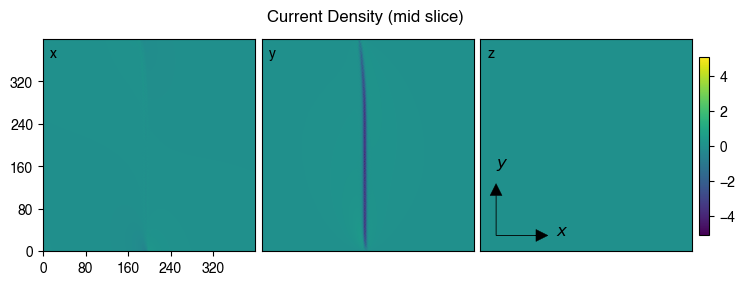

In [4]:
%matplotlib inline

z=1
samples = len(x_u)*len(y_u)
lb = z*samples 
ub = (z+1)*samples

plot_n_components(GridSampler.pts_to_grid(cds[lb:ub,:,0], 400, 400),title='Current Density (mid slice)')

ROI center (m): (np.float64(0.022975000000000006), np.float64(0.025675000000000007))
ROI bounds (m): (np.float64(0.020475000000000007), np.float64(0.025475000000000005), np.float64(0.023175000000000008), np.float64(0.028175000000000006))


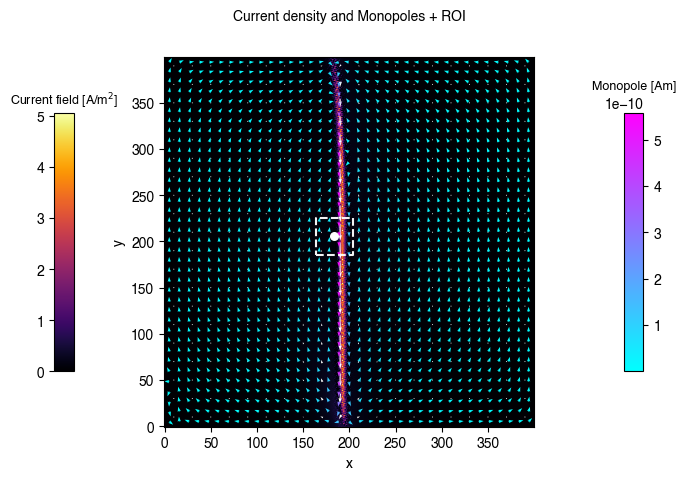

In [11]:
dx_s = dy_s = 1.35e-3
dz_s = max(z_u)

gds, gcs = get_grid_multipole_expansion_time_3d_pad(
    cds,
    pts,
    cell_size=(dx_s, dy_s, dz_s),  # 3D grid spec (x,y,z)
    #grid_spec=(25,25,1),
    volume_element=dx_s*dy_s*dz_s
)

# Mask for z=0.0001 plane (midplane)
mask_z0 = np.isclose(pts[:, 2], 0.0001, atol=1e-12)
# Apply mask
pts_z0 = pts[mask_z0]
cds_z0 = cds[mask_z0]  # shape: (N_z0, 3, T)
z_centers = gcs[:, :, :, 0, 2]
z_idx = np.where(np.isclose(z_centers[0, 0, :], 0.0001, atol=1e-12))[0]
z_idx = z_idx[0]
gds_z0 = gds[:, :, z_idx, :, :]
gcs_z0 = gcs[:, :, z_idx, :, :]

t_idx = 0 # Change according to the time step we evaluate
cds_t = cds_z0[:,:,t_idx]
gds_t = gds_z0[:,:,t_idx]
gcs_t = gcs_z0[:,:,t_idx]

z_star=0.0001  # mid-plane
X, Y, Jgrid = interpolate_slice_for_viz(pts, cds, z_star, Nx=400, Ny=400, method='linear')
xs_unique = X[0, :]   # length Nx
ys_unique = Y[:, 0]   # length Ny

# Your helper requires sorted unique arrays; ensure increasing order
xs_unique = np.asarray(xs_unique)
ys_unique = np.asarray(ys_unique)
current_distribution = np.stack([Jgrid[0].T, Jgrid[1].T], axis=0)  # (2, Nx, Ny)

grid_centers_idx = rescale_centers_to_index(gcs_t, xs_unique, ys_unique)

nx, ny = gcs_t.shape[:2]

# Build dictionary
centers_idxed, lookup = index_grid_centers(gcs_t.reshape(nx*ny,3), nx, ny, one_based=True)

p1 = lookup[(17,20)]
p2 = lookup[(18,19)]

roi = roi_from_center(p1, p2)
print("ROI center (m):", roi['center'])
print("ROI bounds (m):", roi['bounds'])

x_min, x_max = min(x_u), max(x_u)
y_min, y_max = min(y_u), max(y_u)

full_bounds_phys = (x_min, x_max, y_min, y_max)

fig = plot_vector_field_2d_monopoles(
    current_distribution,
    gds_t,
    grid_centers_idx,
    color='white',
    units=r'A/m$^2$',
    units_mono=r'Am',
    monopole_cmap='cool',
    cmap='inferno',
    show=True,   # important: keep the figure open for overlays
    title='Current density and Monopoles + ROI'
)

ax, idx_box = draw_roi_box(fig, roi['bounds'], full_bounds_phys,
                           color='white', lw=1.5, ls='--', alpha=0.95)

plt.draw()

### Magnetic Field Calculation

<b>Objective:</b> Compute the magnetic field from the overall current density - both for the entire volume and the selected ROI. 

Magnetic field is computing from the monopole approximation as $$\vec{B}=\frac{\mu_0}{4\pi}\int_V \vec{J}(\vec{r})\times \frac{(\vec{r}-\vec{r}')}{|\vec{r}-\vec{r}'|^3} dV = \frac{\mu_0}{4\pi}\sum_i^{voxel}\biggl\{ \biggl [ \sum_k J_kV_k\biggr ]\times \frac{(\vec{r}-\vec{r}')}{|\vec{r}-\vec{r}'|^3}\biggr\}$$

The field is observed on a 5x5mm plane representing the NV sensor. The array is aligned with the ROI and offsetted along the z-axis (perperndicular to the tissue plane). 

<b>TODO:</b> 3D Plot the NV sensor plane over the ROI

In [27]:
dx1 = np.max(pts[:,0])/50
dy1 = np.max(pts[:,1])/50
dz1 = np.max(pts[:,2])/1

gds1, gcs1 = get_grid_multipole_expansion_time_3d_pad(
    cds,
    pts,
    # cell_size=(dx_s, dy_s, dz_s),  # 3D grid spec (x,y,z)
    grid_spec=(50,50,1),
    volume_element=dx1*dy1*dz1
)

'\nplt.savefig(\n    "PW_B.svg",\n    format="svg",\n    transparent=False,      # transparent background\n    dpi=300                # resolution hint for embedded rasters\n)\n'

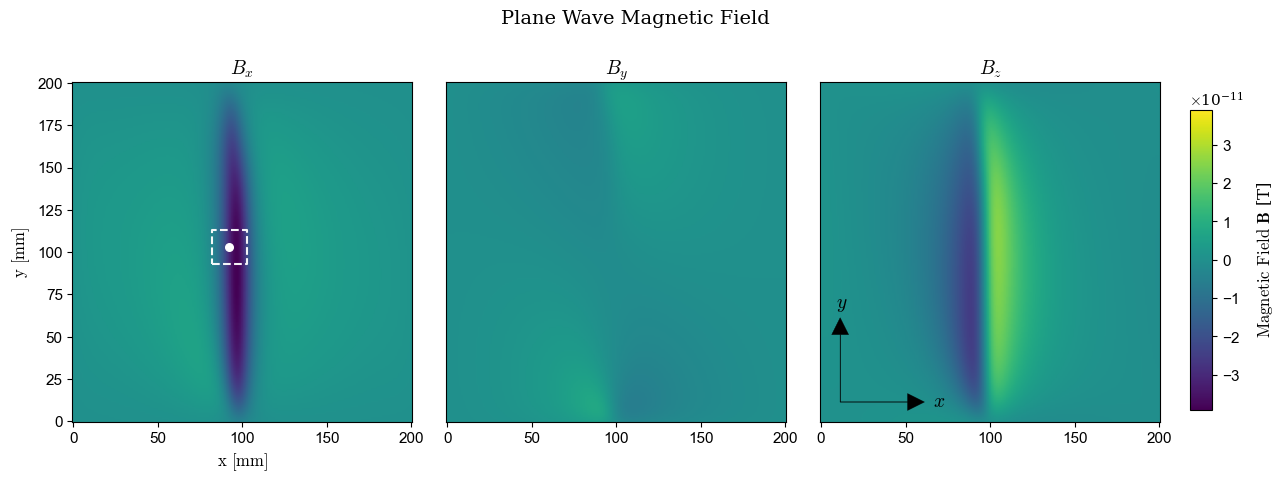

In [32]:
z_sensor = max(z_u) + 2e-3

x_min, x_max = min(x_u), max(x_u)
y_min, y_max = min(y_u), max(y_u)

# Center of the slab
x0 = 0.5 * (x_min + x_max)
y0 = 0.5 * (y_min + y_max)

# NV size
FOVx = 5e-2
FOVy = 5e-2

# Resolution
Nx = 201
Ny = 201

bounds = (x0-FOVx/2, x0+FOVx/2,
          y0-FOVy/2, y0+FOVy/2, 
          z_sensor, z_sensor)

bounds_xy = (x0-FOVx/2, x0+FOVx/2,
          y0-FOVy/2, y0+FOVy/2)

sensor = RegularGridSensor(bounds=bounds, resolution=(Nx, Ny, 1))
obs_pts = sensor.points

B_grid = get_b_from_monopoles_to_grid(gcs1, gds1, obs_pts, Nx, Ny)

t_idx = 0
Bx, By, Bz = B_grid[0,:,:,t_idx], B_grid[1,:,:,t_idx], B_grid[2,:,:,t_idx]

data=np.stack([Bx,By,Bz], axis=0)

extent_mm = [x_min*1e3, x_max*1e3, y_min*1e3, y_max*1e3]

fig = plot_b_field_components(data, units='T', title='Plane Wave Magnetic Field', coord_show=True)

ax, idx_box = draw_roi_box(fig, roi['bounds'], full_bounds_phys,
                           color='white', lw=1.5, ls='--', alpha=0.95)

plt.draw()

'''
plt.savefig(
    "PW_B.svg",
    format="svg",
    transparent=False,      # transparent background
    dpi=300                # resolution hint for embedded rasters
)
'''

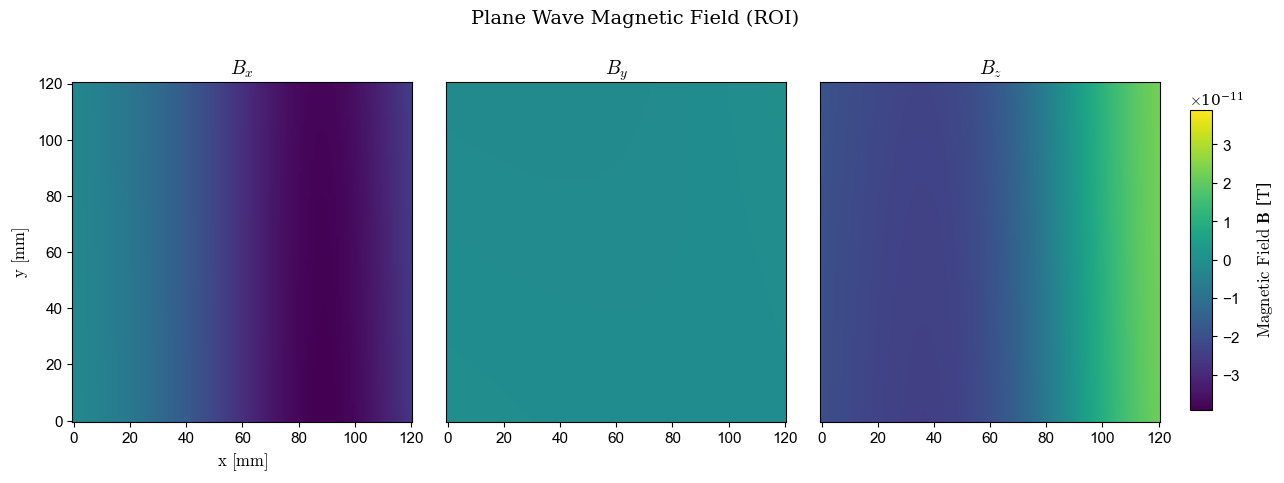

In [34]:
xmin, xmax, ymin, ymax = roi['bounds']
Nx_ROI, Ny_ROI = 121, 121
sensor_roi = RegularGridSensor(bounds=(xmin, xmax, ymin, ymax, z_sensor, z_sensor),
                               resolution=(Nx_ROI, Ny_ROI, 1))
obs_pts_roi = sensor_roi.points

B_truth_roi = get_b_from_monopoles_to_grid(gcs1, gds1, obs_pts_roi, Nx_ROI, Ny_ROI)
B_truth_roi_t = B_truth_roi[:, :, :, t_idx]     # (3, Nx_ROI, Ny_ROI)

Bx, By, Bz = B_truth_roi_t[0], B_truth_roi_t[1], B_truth_roi_t[2]
data = np.stack([Bx, By, Bz], axis=0)

'''
fig = plot_n_components(
    data,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI)'
)
'''

fig = plot_b_field_components(data, units='T', title='Plane Wave Magnetic Field (ROI)')

### Simulated PCB Geometry 

<b>Objective:</b> Reconstruct the phantom geometry

In [62]:
%matplotlib widget

edges_full = grid_graph_from_monopoles(gcs_z0)  # uses frame 0; coordinates in meters
edges_roi = filter_edges_in_roi(edges_full, roi['bounds'])
dead_each = 0.4*MM

edges_trim = []

for p_start, q_end in edges_roi:
    ps_trim, qs_trim = central_subsegment(p_start, q_end, dead_each=0.4*MM)

    edges_trim.append([ps_trim.tolist(), qs_trim.tolist()])

bounds_roi = (xmin, xmax, ymin, ymax, min(z_u), max(z_u))

# Take frame 0
grid = gcs_z0[:, :, 0, :]  # (ny, nx, 3)

# Mask centers inside ROI
mask = centers_in_roi_mask(grid, (xmin, xmax, ymin, ymax))

# Apply mask
roi_centers = grid[mask]  # (N_roi, 3)

# Reshape back to (ny, nx, 1, 3) so it matches what the plotting function expects
roi_grid = np.zeros((grid.shape[0], grid.shape[1], 1, 3))
roi_grid[:] = np.nan  # start with NaN so non-ROI centers disappear
roi_grid[mask, 0, :] = roi_centers


plot_geometry(bounds_roi, roi_grid, edges_roi,
                          dead_each=0.4*MM,
                          elev=27, azim=61)

(<Figure size 800x600 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

### Current Distribution Reconstruction

<b>Objective:</b> Determine the optimal set of currents $I=[I_1, I_2, ..., I_N]$ flowing through $N$ traces that minimizes the magnetic field error within a defined ROI. The magnetic field error is defined as the difference between the real magnetic field and the one generated from the optimized currents. 

The real magnetic field produced by the monopole approximation is: $$\vec{B}_{\text{truth}} = \frac{\mu_0}{4\pi} \sum_{i}^{\text{voxel}} \left( \sum_{k} \vec{J}_k V_k \times \frac{\vec{r} - \vec{r}_i'}{|\vec{r} - \vec{r}_i'|^3}\right),$$ while the magnetic field produced by the PCB is given by: $$\vec{B}_{\text{PCB}}=\sum_{i}^{N}\frac{\mu_0}{4\pi}\int d\vec{l}\times \frac{\vec{r} - \vec{r}_i'}{|\vec{r} - \vec{r}_i'|^3}=\sum_{i}^{N}A_iI_i.$$ The aim is therefore to find the currents vector $I$ that minimizes the objective function $$e(I)=||AI-B_{\text{truth}}||^2.$$ We denote the matrix $A$ as the <b>Biot-Savart operator</b>, since it allows to map a current distribution in the current space into a magnetic field in the magnetic field space. In the case of a well-posed problem such currents are defined through the <b>Moore-Penrose, or pseudoinverse matrix</b> $$A^{\dagger}=(A^{\text{T}}A)^{-1}A^{\text{T}},$$ so that $$I_{sol}=A^{\dagger}B_{\text{truth}}.$$ Most current distribution reconstruction problems, however, are ill-posed, therefore calling for regularization strategies, such as teh well-known Tikhonov regularization method: $$e(I)=||AI-B_{\text{truth}}||^2+\lambda ||I||^2,$$ leading to Euler's equation: $$I_{sol}=(A^{\text{T}}A+\lambda\text{I})^{-1}A^{\text{T}}B_{\text{truth}}.$$

#### On the well-posedness of the problem

In [36]:
A = get_A_matrix(obs_pts_roi, edges_trim) 

matrix_rank = np.linalg.matrix_rank(A)
num_columns = A.shape[1]

print(f"The rank of the matrix A is: {matrix_rank}")
print(f"The number of columns is: {num_columns}")

if matrix_rank < num_columns:
    print("The matrix is not full rank.")
else:
    print("The matrix is full rank.")

The rank of the matrix A is: 24
The number of columns is: 24
The matrix is full rank.


#### Linear System Solution

In [37]:
B_truth_vector = B_truth_roi_t.reshape(3 * Nx_ROI * Ny_ROI, 1)

optimal_lambda = 0

A_reg = np.vstack([A, optimal_lambda * np.eye(A.shape[1])])
B_reg = np.vstack([B_truth_vector, np.zeros((A.shape[1], 1))])

I_solution, _, _, _ = np.linalg.lstsq(A_reg, B_reg, rcond=None)

# 5. Compute the optimized magnetic field and plot
edge_I_roi = {}
for i, (p_raw, q_raw) in enumerate(edges_trim):
    key = undirected_key(np.array(p_raw), np.array(q_raw))
    edge_I_roi[key] = I_solution[i, 0]

B_pcb_grid = get_b_from_edges_to_grid(edges_trim, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

B_pcb_vector = B_pcb_grid.reshape(-1)
B_truth_vector_flat = B_truth_roi_t.reshape(-1)

# Calculate the optimal scalar (alpha) to match the magnitudes
alpha = np.dot(B_truth_vector_flat, B_pcb_vector) / np.dot(B_pcb_vector, B_pcb_vector)
print(f"Optimal scaling factor (alpha): {alpha}")

# Scale the final PCB magnetic field
B_pcb_grid_scaled = B_pcb_grid

Optimal scaling factor (alpha): 1.000000000000002


/var/folders/yk/2gs9blzx0050s_77k02m3fc40000gn/T/ipykernel_29211/233837709.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


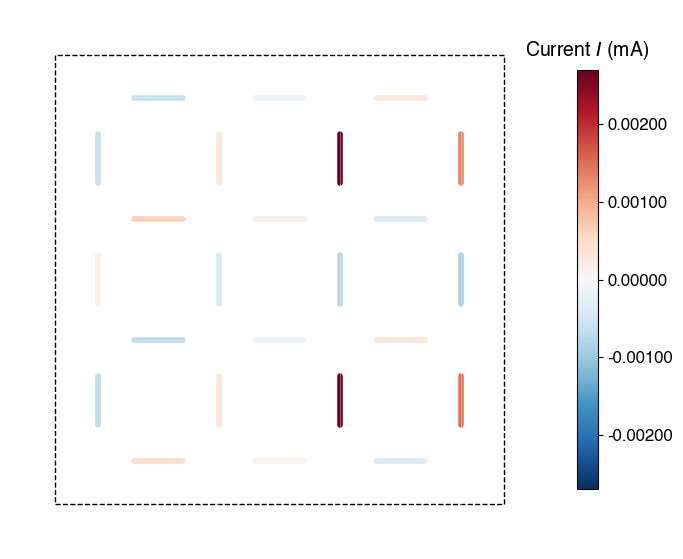

In [39]:
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker 
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import Rectangle

%matplotlib inline
N_edges = len(edges_trim) 
I_edges = I_solution[:, 0] 

I_max_abs = np.max(np.abs(I_edges))
if I_max_abs == 0: I_max_abs = 1.0 

FIXED_THICKNESS = 4.0 

cmap_name = 'RdBu_r' 
cmap = plt.cm.get_cmap(cmap_name)
norm = mcolors.CenteredNorm(vcenter=0, halfrange=I_max_abs)


# --- 2. Initialize Figure and Plot Edges ---

fig, ax = plt.subplots(figsize=(9, 7))
ax.set_aspect('equal', adjustable='box')

xmin, xmax, ymin, ymax, _, _ = bounds_roi

UNIT_SCALE = 100.0 
ROI_X_MIN_CM, ROI_X_MAX_CM = xmin * UNIT_SCALE, xmax * UNIT_SCALE
ROI_Y_MIN_CM, ROI_Y_MAX_CM = ymin * UNIT_SCALE, ymax * UNIT_SCALE

X_BUFFER = (ROI_X_MAX_CM - ROI_X_MIN_CM) * 0.1
Y_BUFFER = (ROI_Y_MAX_CM - ROI_Y_MIN_CM) * 0.1

ax.set_xlim(ROI_X_MIN_CM - X_BUFFER, ROI_X_MAX_CM + X_BUFFER)
ax.set_ylim(ROI_Y_MIN_CM - Y_BUFFER, ROI_Y_MAX_CM + Y_BUFFER)

# Plot Dashed ROI Boundary
ax.add_patch(
    Rectangle(
        (ROI_X_MIN_CM, ROI_Y_MIN_CM), 
        ROI_X_MAX_CM - ROI_X_MIN_CM, 
        ROI_Y_MAX_CM - ROI_Y_MIN_CM,
        edgecolor='black',
        linestyle='--',
        facecolor='none', 
        linewidth=1, 
        zorder=1
    )
)

# Remove all axes elements
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('') 
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
for spine in ax.spines.values():
    spine.set_visible(False)

# --- 3. Plot Edge Currents ---

for i, (p_raw, q_raw) in enumerate(edges_trim):
    I_val = I_edges[i]
    I_abs = np.abs(I_val)
    
    color = cmap(norm(I_val))
    line_thickness = FIXED_THICKNESS 

    p_x, p_y = p_raw[0] * UNIT_SCALE, p_raw[1] * UNIT_SCALE
    q_x, q_y = q_raw[0] * UNIT_SCALE, q_raw[1] * UNIT_SCALE

    # --- Line Plot ---
    ax.plot([p_x, q_x], [p_y, q_y], 
            color=color, 
            linewidth=line_thickness,
            alpha=1.0, 
            zorder=3,
            solid_capstyle='round')

    # --- Directionality (Large, White Arrow) ---
    if I_abs > 0.1 * I_max_abs: 
        if I_val >= 0:
            dx, dy = q_x - p_x, q_y - p_y
        else:
            dx, dy = p_x - q_x, p_y - q_y

        length = np.sqrt(dx**2 + dy**2)
        if length > 1e-9:
            nx, ny = dx / length, dy / length
            
            ARROW_COLOR = 'white'
            ARROW_HEAD_SCALE = 20  
            ARROW_LENGTH_ABS = 0.8 * line_thickness 

            mid_x = (p_x + q_x) / 2
            mid_y = (p_y + q_y) / 2
            
            start_x = mid_x - nx * ARROW_LENGTH_ABS * 0.5 
            start_y = mid_y - ny * ARROW_LENGTH_ABS * 0.5 
            end_x = mid_x + nx * ARROW_LENGTH_ABS * 0.5
            end_y = mid_y + ny * ARROW_LENGTH_ABS * 0.5
            
            arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                                    arrowstyle='->',
                                    mutation_scale=ARROW_HEAD_SCALE, 
                                    color=ARROW_COLOR, 
                                    linewidth=0.1, 
                                    zorder=4)
            ax.add_patch(arrow)


# --- 4. Add the Colorbar (Title Above) ---

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 

# Use a slightly thinner fraction for the colorbar space if title is above
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)

# MODIFICATION: Use set_title() to place the label horizontally above the bar
cbar.ax.set_title('Current $I$ (mA)', fontsize=14, pad=10)

# Clear the side label to prevent it from overlapping or being drawn
cbar.set_label('') 
# Ensure tick labels are clean
cbar.ax.tick_params(labelsize=12)

def milliamp_formatter(x, pos):
    """Converts tick value (A) to mA for display."""
    return f'{x * 1000:.5f}' 

cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(milliamp_formatter))

plt.show()

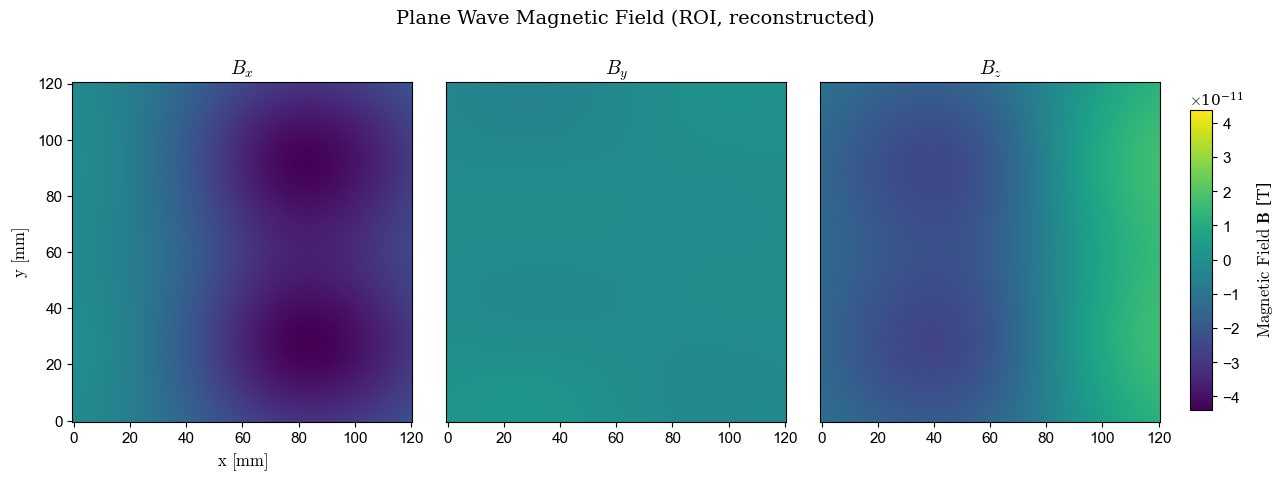

In [40]:
Bx_pcb, By_pcb, Bz_pcb = B_pcb_grid_scaled[0], B_pcb_grid_scaled[1], B_pcb_grid_scaled[2]
data_pcb = np.stack([Bx_pcb, By_pcb, Bz_pcb], axis=0)

%matplotlib inline
'''
fig = plot_n_components(
    data_pcb,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI, reconstructed)'
)
'''
fig = plot_b_field_components(data_pcb, units='T', title='Plane Wave Magnetic Field (ROI, reconstructed)')

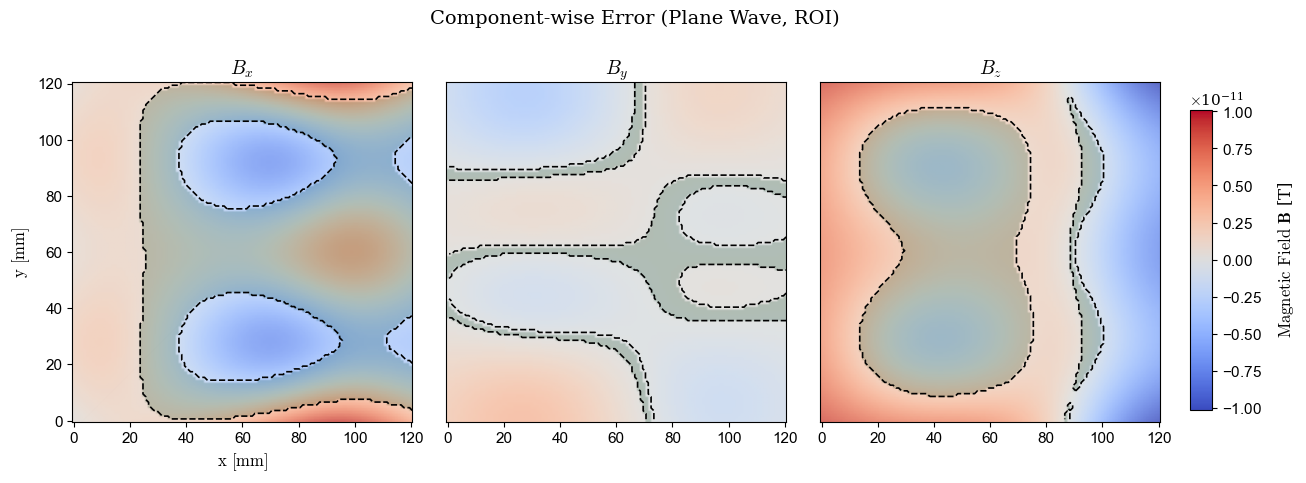

In [43]:
Err = B_pcb_grid_scaled - B_truth_roi_t   # shape (3, Nx_ROI, Ny_ROI)

# 3) Plot error maps with a diverging colormap centered at 0

fig_err = plot_b_field_components(Err, units='T', title='Component-wise Error (Plane Wave, ROI)', cmap='coolwarm')

Bref = B_truth_roi_t
Bmax = float(np.nanmax(np.abs(Bref))) if np.isfinite(Bref).any() else 1.0
eps_scale = 1e-4
eps = eps_scale * Bmax
Rel = np.abs(Err) / (np.abs(Bref) + eps)

# thresholds to show (relative error per component)
levels = [0.1]
colors = {0.1: 'k'}
linest = {0.1: '--'}

axes_img = [ax for ax in fig_err.axes if getattr(ax, "images", [])]

# Corrected NV sensor resolution threshold (e.g., 5 nanotesla)
nv_resolution_threshold = 2e-10
relative_error_threshold = 0.1 # 10%

abs_Err_mag = np.linalg.norm(Err, axis=0)

for k, ax in enumerate(axes_img):
    rel_k = Rel[k]  # Relative error for component k
    err_k = Err[k]  # Absolute error for component k

    # Check the condition component-wise
    # good_fit_mask = (rel_k.T <= relative_error_threshold) | (np.abs(err_k.T) <= nv_resolution_threshold)
    good_fit_mask = (rel_k.T <= relative_error_threshold)


    ax.imshow(good_fit_mask.astype(float), cmap='Greens',
              alpha=0.2, origin='lower', zorder=0)

    for lev in levels:
        CS = ax.contour(good_fit_mask, levels=[lev], colors=colors[lev],
                        linewidths=1.2, linestyles=linest[lev], origin='lower')
        #ax.clabel(CS, fmt={lev: f'{int(lev*100)}%'}, inline=True, fontsize=8)

plt.draw()

#### Residual Field

In [19]:
FIXED_XMIN = roi_centers[0,0]
FIXED_XMAX = roi_centers[12,0]
FIXED_YMIN = roi_centers[0,1]
FIXED_YMAX = roi_centers[15,1]
FIXED_Z_LEVEL_CENTERS = roi_centers[0,2]
FIXED_BOUNDS = (FIXED_XMIN, FIXED_XMAX, FIXED_YMIN, FIXED_YMAX)
DEAD_LENGTH_RATIO = 0.4 / 1.35 
ROI_SIDE_LENGTH = FIXED_XMAX-FIXED_XMIN
N_grid = 15
L_edge = ROI_SIDE_LENGTH / (N_grid - 1)

dead_each_scaled = DEAD_LENGTH_RATIO * L_edge 

edges_roi, current_centers_grid = generate_grid_geometry(
    FIXED_BOUNDS, 
    N_grid, 
    z_level=FIXED_Z_LEVEL_CENTERS
)

edges_trim = []
for p_start, q_end in edges_roi:
    ps_trim, qs_trim = central_subsegment(p_start, q_end, dead_each=0)
    edges_trim.append([ps_trim.tolist(), qs_trim.tolist()])

N_edges = len(edges_trim)

A_res = get_A_matrix(obs_pts_roi, edges_trim)

B_pcb_vector = B_pcb_grid.reshape(3 * Nx_ROI * Ny_ROI, 1)
B_residual = B_truth_vector - B_pcb_vector


I_residual, _, _, _ = np.linalg.lstsq(A_res, B_residual, rcond=None)

/var/folders/yk/2gs9blzx0050s_77k02m3fc40000gn/T/ipykernel_31921/126465279.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


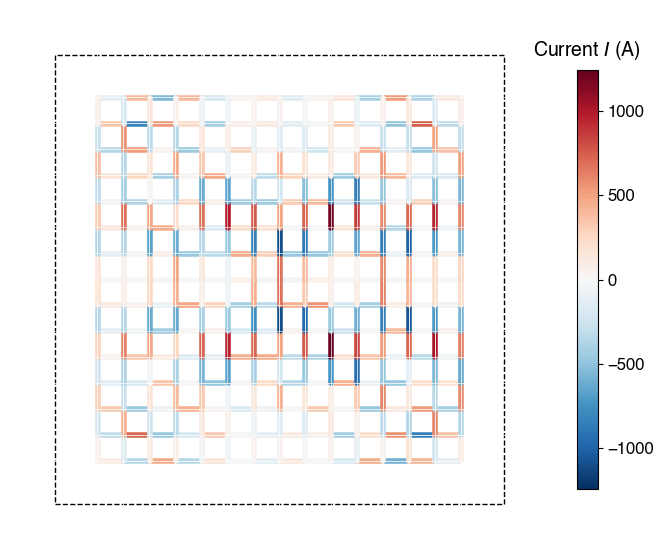

In [20]:
%matplotlib inline
N_edges = len(edges_trim) 
I_edges = I_residual[:, 0] 

I_max_abs = np.max(np.abs(I_edges))
if I_max_abs == 0: I_max_abs = 1.0 

FIXED_THICKNESS = 4.0 

cmap_name = 'RdBu_r' 
cmap = plt.cm.get_cmap(cmap_name)
norm = mcolors.CenteredNorm(vcenter=0, halfrange=I_max_abs)


# --- 2. Initialize Figure and Plot Edges ---

fig, ax = plt.subplots(figsize=(9, 7))
ax.set_aspect('equal', adjustable='box')

xmin, xmax, ymin, ymax, _, _ = bounds_roi

UNIT_SCALE = 100.0 
ROI_X_MIN_CM, ROI_X_MAX_CM = xmin * UNIT_SCALE, xmax * UNIT_SCALE
ROI_Y_MIN_CM, ROI_Y_MAX_CM = ymin * UNIT_SCALE, ymax * UNIT_SCALE

X_BUFFER = (ROI_X_MAX_CM - ROI_X_MIN_CM) * 0.1
Y_BUFFER = (ROI_Y_MAX_CM - ROI_Y_MIN_CM) * 0.1

ax.set_xlim(ROI_X_MIN_CM - X_BUFFER, ROI_X_MAX_CM + X_BUFFER)
ax.set_ylim(ROI_Y_MIN_CM - Y_BUFFER, ROI_Y_MAX_CM + Y_BUFFER)

# Plot Dashed ROI Boundary
ax.add_patch(
    Rectangle(
        (ROI_X_MIN_CM, ROI_Y_MIN_CM), 
        ROI_X_MAX_CM - ROI_X_MIN_CM, 
        ROI_Y_MAX_CM - ROI_Y_MIN_CM,
        edgecolor='black',
        linestyle='--',
        facecolor='none', 
        linewidth=1, 
        zorder=1
    )
)

# Remove all axes elements
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('') 
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
for spine in ax.spines.values():
    spine.set_visible(False)

# --- 3. Plot Edge Currents ---

for i, (p_raw, q_raw) in enumerate(edges_trim):
    I_val = I_edges[i]
    I_abs = np.abs(I_val)
    
    color = cmap(norm(I_val))
    line_thickness = FIXED_THICKNESS 

    p_x, p_y = p_raw[0] * UNIT_SCALE, p_raw[1] * UNIT_SCALE
    q_x, q_y = q_raw[0] * UNIT_SCALE, q_raw[1] * UNIT_SCALE

    # --- Line Plot ---
    ax.plot([p_x, q_x], [p_y, q_y], 
            color=color, 
            linewidth=line_thickness,
            alpha=1.0, 
            zorder=3,
            solid_capstyle='round')

    # --- Directionality (Large, White Arrow) ---
    if I_abs > 0.1 * I_max_abs: 
        if I_val >= 0:
            dx, dy = q_x - p_x, q_y - p_y
        else:
            dx, dy = p_x - q_x, p_y - q_y

        length = np.sqrt(dx**2 + dy**2)
        if length > 1e-9:
            nx, ny = dx / length, dy / length
            
            ARROW_COLOR = 'white'
            ARROW_HEAD_SCALE = 20  
            ARROW_LENGTH_ABS = 0.8 * line_thickness 

            mid_x = (p_x + q_x) / 2
            mid_y = (p_y + q_y) / 2
            
            start_x = mid_x - nx * ARROW_LENGTH_ABS * 0.5 
            start_y = mid_y - ny * ARROW_LENGTH_ABS * 0.5 
            end_x = mid_x + nx * ARROW_LENGTH_ABS * 0.5
            end_y = mid_y + ny * ARROW_LENGTH_ABS * 0.5
            
            arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                                    arrowstyle='->',
                                    mutation_scale=ARROW_HEAD_SCALE, 
                                    color=ARROW_COLOR, 
                                    linewidth=0.1, 
                                    zorder=4)
            ax.add_patch(arrow)


# --- 4. Add the Colorbar (Title Above) ---

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 

# Use a slightly thinner fraction for the colorbar space if title is above
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)

# MODIFICATION: Use set_title() to place the label horizontally above the bar
cbar.ax.set_title('Current $I$ (A)', fontsize=14, pad=10)

# Clear the side label to prevent it from overlapping or being drawn
cbar.set_label('') 
# Ensure tick labels are clean
cbar.ax.tick_params(labelsize=12)
'''
def milliamp_formatter(x, pos):
    """Converts tick value (A) to mA for display."""
    return f'{x * 1000:.2f}' 

cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(milliamp_formatter))
'''
plt.show()

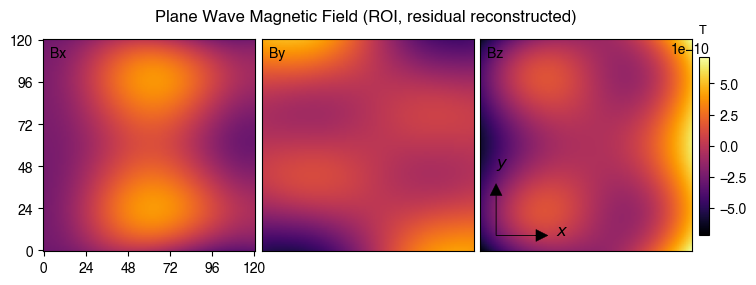

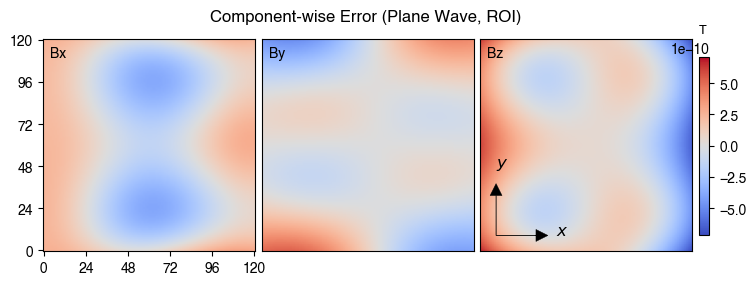

In [22]:
edge_I_roi = {}
for i, (p_raw, q_raw) in enumerate(edges_trim):
    key = undirected_key(np.array(p_raw), np.array(q_raw))
    edge_I_roi[key] = I_residual[i, 0]

B_rec_residual = get_b_from_edges_to_grid(edges_trim, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

fig = plot_n_components(
    B_rec_residual,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI, residual reconstructed)'
)

fig_err = plot_n_components(
    Err,
    units='T',
    cmap='coolwarm',
    labels=['Bx', 'By', 'Bz'],  # Corrected labels
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Component-wise Error (Plane Wave, ROI)'
)


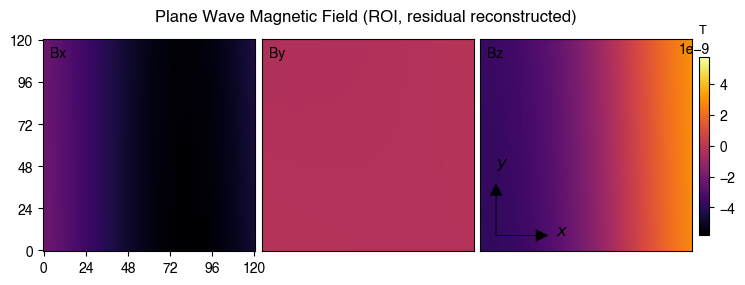

In [21]:
B_tot = B_pcb_grid + B_rec_residual

fig = plot_n_components(
    B_tot,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI, residual reconstructed)'
)

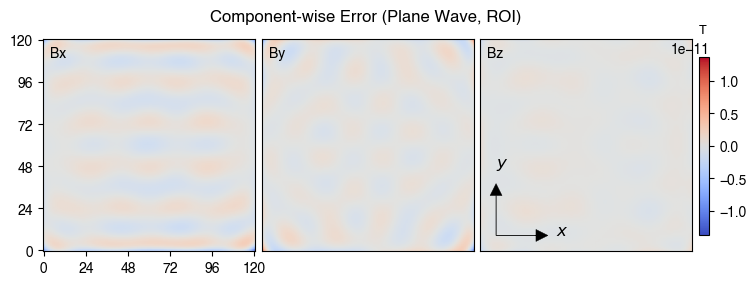

In [24]:
Err = B_tot - B_truth_roi_t   # shape (3, Nx_ROI, Ny_ROI)

# 3) Plot error maps with a diverging colormap centered at 0
fig_err = plot_n_components(
    Err,
    units='T',
    cmap='coolwarm',
    labels=['Bx', 'By', 'Bz'],  # Corrected labels
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Component-wise Error (Plane Wave, ROI)'
)

Bref = B_truth_roi_t
Bmax = float(np.nanmax(np.abs(Bref))) if np.isfinite(Bref).any() else 1.0
eps_scale = 1e-4
eps = eps_scale * Bmax
Rel = np.abs(Err) / (np.abs(Bref) + eps)

# thresholds to show (relative error per component)
levels = [0.1]
colors = {0.1: 'k'}
linest = {0.1: '--'}

axes_img = [ax for ax in fig_err.axes if getattr(ax, "images", [])]

# Corrected NV sensor resolution threshold (e.g., 5 nanotesla)
nv_resolution_threshold = 2e-10
relative_error_threshold = 0.01 # 10%

abs_Err_mag = np.linalg.norm(Err, axis=0)

for k, ax in enumerate(axes_img):
    rel_k = Rel[k]  # Relative error for component k
    err_k = Err[k]  # Absolute error for component k

    # Check the condition component-wise
    good_fit_mask = (rel_k.T <= relative_error_threshold) | (np.abs(err_k.T) <= nv_resolution_threshold)

    ax.imshow(good_fit_mask.astype(float), cmap='Greens',
              alpha=0.2, origin='lower', zorder=0)

    for lev in levels:
        CS = ax.contour(good_fit_mask, levels=[lev], colors=colors[lev],
                        linewidths=1.2, linestyles=linest[lev], origin='lower')
        #ax.clabel(CS, fmt={lev: f'{int(lev*100)}%'}, inline=True, fontsize=8)

plt.draw()

#### Error vs. Distance from the sensor

<b>Objective:</b> Assess the dependency of magnetic field reconstruction accuracy on the standoff distance between the sensor and the phantom. 

<b>Hypothesis:</b> The reconstruction accuracy increases with distance. This is based on the premise that a larger standoff distance better approximates the far-field regime. When the standoff distance is not significantly larger than the length of the trace the near-field contributions dominates, hence we see individual contributions from the traces; on the contrary, larger distances lead to spatially smoother field distribution. 

In [52]:
z_min_mm = 0.1
z_max_mm = 5.0
N_steps = 20
z_distances_m = np.linspace(z_min_mm * MM, z_max_mm * MM, N_steps)

xmin, xmax, ymin, ymax = roi['bounds']
Nx_ROI, Ny_ROI = 121, 121

results = {
    'z_distance': z_distances_m,
    'frac_x': [],
    'frac_y': [],
    'frac_z': []
}

print("Starting Z-Height Reconstruction Accuracy Analysis...")

for z_sensor in z_distances_m:
    z_sens = max(z_u)+z_sensor
    sensor_roi = RegularGridSensor(bounds=(xmin, xmax, ymin, ymax, z_sens, z_sens),
                               resolution=(Nx_ROI, Ny_ROI, 1))
    obs_pts_roi = sensor_roi.points

    B_truth_roi = get_b_from_monopoles_to_grid(gcs1, gds1, obs_pts_roi, Nx_ROI, Ny_ROI)
    B_truth_roi_t = B_truth_roi[:, :, :, t_idx]     # (3, Nx_ROI, Ny_ROI)
    B_truth_vector = B_truth_roi_t.reshape(3 * Nx_ROI * Ny_ROI, 1)

    A = get_A_matrix(obs_pts_roi, edges_trim) 
    
    I_solution, _, _, _ = np.linalg.lstsq(A, B_truth_vector, rcond=None)

    edge_I_roi = {}
    for i, (p_raw, q_raw) in enumerate(edges_trim):
        key = undirected_key(np.array(p_raw), np.array(q_raw))
        edge_I_roi[key] = I_solution[i, 0]

    B_pcb_grid = get_b_from_edges_to_grid(edges_trim, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

    B_rec_flat = B_pcb_grid.reshape(3, -1)
    B_tru_flat = B_truth_roi_t.reshape(3, -1) 

    # 3.5 Calculate Error Metric
    frac_x, frac_y, frac_z = calculate_area_fraction(B_rec_flat, B_tru_flat, threshold=0.10, abs_threshold=2e-10)

    results['frac_x'].append(frac_x)
    results['frac_y'].append(frac_y)
    results['frac_z'].append(frac_z)
    
    # print(f"Z={z_sensor*1000:.2f}mm -> Bx_frac:{frac_x:.2f}, By_frac:{frac_y:.2f}, Bz_frac:{frac_z:.2f}")

print("Analysis Complete.")


Starting Z-Height Reconstruction Accuracy Analysis...
Analysis Complete.


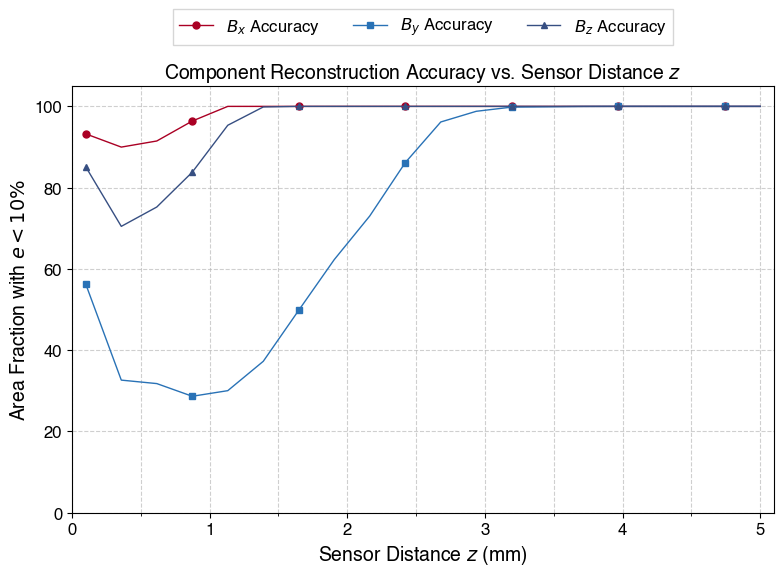

In [53]:
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 1,
    'lines.markersize': 5,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'figure.figsize': (8, 6) # Standard single-column figure size
})

fig, ax = plt.subplots()

colors = {
    'Bz': "#374f82",  # Dark Blue
    'By': '#2972b6',  # Medium Blue
    'Bx': "#aa0024"   # Light Blue
}

z_distances_mm = results['z_distance'] * 1000 # Convert to mm

# Plot Bx
ax.plot(z_distances_mm, results['frac_x'], 
        label=r'$B_x$ Accuracy', 
        color=colors['Bx'], 
        linestyle='-', 
        marker='o', 
        markevery=3)

# Plot By
ax.plot(z_distances_mm, results['frac_y'], 
        label=r'$B_y$ Accuracy', 
        color=colors['By'], 
        linestyle='-', 
        marker='s', 
        markevery=3)

# Plot Bz
ax.plot(z_distances_mm, results['frac_z'], 
        label=r'$B_z$ Accuracy', 
        color=colors['Bz'], 
        linestyle='-', 
        marker='^', 
        markevery=3)

# Add grid and limits
ax.grid(True, which='both')
ax.set_ylim(0, 1.05)
ax.set_xlim(z_distances_mm[0], z_distances_mm[-1]+0.1)

# Labels and Title
ax.set_xlabel('Sensor Distance $z$ (mm)', fontsize=14)
ax.set_ylabel(r'Area Fraction with $e<10\%$', fontsize=14)

# Y-axis ticks to show percentage
yticks = np.linspace(0, 1, 6)
ax.set_yticks(yticks)
ax.set_yticklabels([f'{int(y*100)}' for y in yticks])

ax.set_xticks(np.arange(0, z_max_mm + 1, 1.0))
ax.set_xticks(np.arange(0, z_max_mm + 0.5, 0.5), minor=True)

# Legend
ax.legend(
    loc='upper center',         # Anchor the legend box center-top
    bbox_to_anchor=(0.5, 1.2), # Place it above the plot (y=1.15)
    ncol=3,                     # Display in 3 columns (horizontal)
    # title="Component Accuracy",  # Keep the title
    frameon=True,              # Typically no box when placed outside
    fancybox=False,             # Keep it simple
    shadow=False
)

# Title/Caption style
ax.set_title(r'Component Reconstruction Accuracy vs. Sensor Distance $z$', fontsize=14)

plt.tight_layout()
plt.show()


#### Error vs. Number of edges

<b>Objective:</b> Assess the dependency of magnetic field reconstruction accuracy on the phantom edges density.

<b>Hypothesis:</b> Increasing the number of edges leads to better reconstruction accuracy, as the "mesh" becomes denser.

In [49]:
FIXED_XMIN = roi_centers[0,0]
FIXED_XMAX = roi_centers[12,0]
FIXED_YMIN = roi_centers[0,1]
FIXED_YMAX = roi_centers[15,1]
FIXED_Z_LEVEL_CENTERS = roi_centers[0,2]
FIXED_BOUNDS = (FIXED_XMIN, FIXED_XMAX, FIXED_YMIN, FIXED_YMAX)
DEAD_LENGTH_RATIO = 0.4 / 1.35 
ROI_SIDE_LENGTH = FIXED_XMAX-FIXED_XMIN

B_tru_flat = B_truth_roi_t.reshape(3, -1) 
B_truth_vector = B_truth_roi_t.reshape(3 * Nx_ROI * Ny_ROI, 1)

N_min = 2
N_max = 15
N_centers_range = np.linspace(N_min, N_max, N_max-N_min+1, dtype=int)

results_density = {
    'N_centers_per_side': [],
    'N_total_edges': [],
    'frac_x': [],
    'frac_y': [],
    'frac_z': []
}

print("Starting Geometry Density Reconstruction Accuracy Analysis...")

for N_grid in N_centers_range:
    
    # --- 3.0 DYNAMIC DEAD_EACH CALCULATION ---
    # Length of a single edge segment
    L_edge = ROI_SIDE_LENGTH / (N_grid - 1)
    
    # Scale dead_each proportionally (in meters)
    dead_each_scaled = DEAD_LENGTH_RATIO * L_edge 
    
    # 3.1 Generate the Discretized Geometry
    edges_roi, current_centers_grid = generate_grid_geometry(
        FIXED_BOUNDS, 
        N_grid, 
        z_level=FIXED_Z_LEVEL_CENTERS
    )
    
    # 3.1.1 Apply Trimming
    edges_trim = []
    for p_start, q_end in edges_roi:
        ps_trim, qs_trim = central_subsegment(p_start, q_end, dead_each=dead_each_scaled)
        edges_trim.append([ps_trim.tolist(), qs_trim.tolist()])

    N_edges = len(edges_trim)
    
    A = get_A_matrix(obs_pts_roi, edges_trim)

    # 3.3 Solve and Reconstruct (Mock LSQ using mock A-matrix)
    I_solution, _, _, _ = np.linalg.lstsq(A, B_truth_vector, rcond=None)
    
    edge_I_roi = {}
    for i, (p_raw, q_raw) in enumerate(edges_trim):
        key = undirected_key(np.array(p_raw), np.array(q_raw))
        edge_I_roi[key] = I_solution[i, 0]

    B_pcb_grid = get_b_from_edges_to_grid(edges_trim, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)
    B_rec_flat = B_pcb_grid.reshape(3, -1)
    
    # 3.4 Calculate Error Metric (Mock)
    frac_x, frac_y, frac_z = calculate_area_fraction(
        B_rec_flat, 
        B_tru_flat, 
        threshold=0.10, 
        abs_threshold=2e-10
    )
    
    # 3.5 Store Results
    results_density['N_centers_per_side'].append(N_grid)
    results_density['N_total_edges'].append(N_edges)
    results_density['frac_x'].append(frac_x)
    results_density['frac_y'].append(frac_y)
    results_density['frac_z'].append(frac_z)
    
    print(f"N_grid={N_grid:02} (Edges={N_edges:03}) -> Bx:{frac_x:.4f}, By:{frac_y:.4f}, Bz:{frac_z:.4f} (Dead Length: {dead_each_scaled*1e6:.1f} um)")

print("Density Analysis Complete.")


Starting Geometry Density Reconstruction Accuracy Analysis...
N_grid=02 (Edges=004) -> Bx:0.6917, By:0.6075, Bz:0.1702 (Dead Length: 1200.0 um)
N_grid=03 (Edges=012) -> Bx:0.7674, By:0.2753, Bz:0.8193 (Dead Length: 600.0 um)
N_grid=04 (Edges=024) -> Bx:1.0000, By:0.4730, Bz:0.9760 (Dead Length: 400.0 um)
N_grid=05 (Edges=040) -> Bx:1.0000, By:0.7727, Bz:1.0000 (Dead Length: 300.0 um)
N_grid=06 (Edges=060) -> Bx:1.0000, By:0.9107, Bz:1.0000 (Dead Length: 240.0 um)
N_grid=07 (Edges=084) -> Bx:1.0000, By:0.9824, Bz:1.0000 (Dead Length: 200.0 um)
N_grid=08 (Edges=112) -> Bx:1.0000, By:0.9997, Bz:1.0000 (Dead Length: 171.4 um)
N_grid=09 (Edges=144) -> Bx:1.0000, By:0.9999, Bz:1.0000 (Dead Length: 150.0 um)
N_grid=10 (Edges=180) -> Bx:1.0000, By:1.0000, Bz:1.0000 (Dead Length: 133.3 um)
N_grid=11 (Edges=220) -> Bx:1.0000, By:1.0000, Bz:1.0000 (Dead Length: 120.0 um)
N_grid=12 (Edges=264) -> Bx:1.0000, By:1.0000, Bz:1.0000 (Dead Length: 109.1 um)
N_grid=13 (Edges=312) -> Bx:1.0000, By:1.0000,

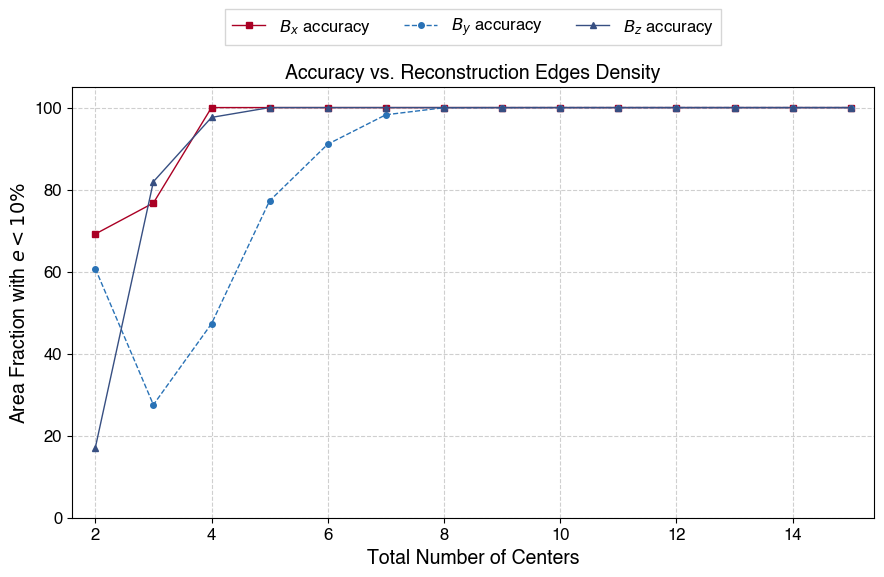

<Figure size 900x600 with 0 Axes>

In [50]:
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 1,
    'lines.markersize': 4,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'figure.figsize': (9, 6) # Wider figure for horizontal legend
})

fig, ax = plt.subplots()

# Define a gradient of blue colors
colors = {
    'Bz': '#374f82',  # Dark Blue
    'By': '#2972b6',  # Medium Blue
    'Bx': '#aa0024'   # Light Blue
}

X_data = np.array(results_density['N_centers_per_side'])

# Plot Bx
ax.plot(X_data, results_density['frac_x'], label=r'$B_x$ accuracy', color=colors['Bx'], linestyle='-', marker='s', markevery=1)
# Plot By
ax.plot(X_data, results_density['frac_y'], label=r'$B_y$ accuracy', color=colors['By'], linestyle='--', marker='o', markevery=1)
# Plot Bz
ax.plot(X_data, results_density['frac_z'], label=r'$B_z$ accuracy', color=colors['Bz'], linestyle='-', marker='^', markevery=1)


# --- AXES AND LABELS ---
ax.grid(True, which='both')
ax.set_ylim(0, 1.05)
ax.set_xlim(X_data.min()-0.4, X_data.max()+0.4)

# X-axis: Logarithmic scale is often useful when iterating over mesh size
# ax.set_xscale('log') # Optional: use if high densities are reached

ax.set_xlabel('Total Number of Centers', fontsize=14)
ax.set_ylabel(r'Area Fraction with $e<10\%$', fontsize=14)

# Y-axis ticks to show percentage
yticks = np.linspace(0, 1, 6)
ax.set_yticks(yticks)
ax.set_yticklabels([f'{int(y*100)}' for y in yticks])

# --- LEGEND (NorthOutside Style) ---
ax.legend(
    loc='upper center',         # Anchor the legend box center-top
    bbox_to_anchor=(0.5, 1.2), # Place it above the plot (y=1.15)
    ncol=3,                     # Display in 3 columns (horizontal)
    # title="Component Accuracy",  # Keep the title
    frameon=True,              # Typically no box when placed outside
    fancybox=False,             # Keep it simple
    shadow=False
)

# Set the title below the legend area
ax.set_title(r'Accuracy vs. Reconstruction Edges Density', fontsize=14)


plt.tight_layout()
plt.show()
plt.savefig('accuracy_vs_density.png', dpi=300, bbox_inches='tight')

#### Performance Map

<b>Objective:</b> Join both studies (error vs. distance and error vs. number of edges) into a single performance map. 

<b>Hypothesis:</b> Increasing the number of edges leads to better reconstruction at lower distances because of the far field approximation.

In [54]:
N_min = 2
N_max = 15
N_centers_range = np.linspace(N_min, N_max, N_max-N_min+1, dtype=int)
N_DENSITY_STEPS = len(N_centers_range) # 14

z_min_mm = 0.1
z_max_mm = 5.0

z_distances_m = np.linspace(z_min_mm * MM, z_max_mm * MM, 20) 
N_Z_STEPS = len(z_distances_m) # 20


accuracy_map_x = np.zeros((N_Z_STEPS, N_DENSITY_STEPS))
accuracy_map_y = np.zeros((N_Z_STEPS, N_DENSITY_STEPS))
accuracy_map_z = np.zeros((N_Z_STEPS, N_DENSITY_STEPS))

for i, z_sensor in enumerate(z_distances_m):
    
    
    z_fixed = max(z_u) + z_sensor
    
   
    sensor_roi = RegularGridSensor(bounds=(xmin, xmax, ymin, ymax, z_fixed, z_fixed),
                               resolution=(Nx_ROI, Ny_ROI, 1))
    obs_pts_roi = sensor_roi.points

    B_truth_roi = get_b_from_monopoles_to_grid(gcs1, gds1, obs_pts_roi, Nx_ROI, Ny_ROI)
    B_truth_roi_t = B_truth_roi[:, :, :, t_idx]
    
    B_tru_flat = B_truth_roi_t.reshape(3, -1) 
    B_truth_vector = B_truth_roi_t.reshape(3 * Nx_ROI * Ny_ROI, 1)
    
    
    for j, N_grid in enumerate(N_centers_range):

        L_edge = ROI_SIDE_LENGTH / (N_grid - 1)
        dead_each_scaled = DEAD_LENGTH_RATIO * L_edge 
        
        edges_roi, current_centers_grid = generate_grid_geometry(
            FIXED_BOUNDS, 
            N_grid, 
            z_level=FIXED_Z_LEVEL_CENTERS
        )

        edges_trim = []
        for p_start, q_end in edges_roi:
            ps_trim, qs_trim = central_subsegment(p_start, q_end, dead_each=dead_each_scaled)
            edges_trim.append([ps_trim.tolist(), qs_trim.tolist()])
        
        A = get_A_matrix(obs_pts_roi, edges_trim) 
        I_solution, _, _, _ = np.linalg.lstsq(A, B_truth_vector, rcond=None)
        
        edge_I_roi = {}
        for idx, (p_raw, q_raw) in enumerate(edges_trim):
            key = undirected_key(np.array(p_raw), np.array(q_raw))
            edge_I_roi[key] = I_solution[idx, 0]

        B_pcb_grid = get_b_from_edges_to_grid(edges_trim, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)
        B_rec_flat = B_pcb_grid.reshape(3, -1)
    
        frac_x, frac_y, frac_z = calculate_area_fraction(
            B_rec_flat,
            B_tru_flat,
            threshold=0.1,
            abs_threshold=2e-10
        )
        
        accuracy_map_x[i, j] = frac_x
        accuracy_map_y[i, j] = frac_y
        accuracy_map_z[i, j] = frac_z
        
print("2D sweep complete.")

2D sweep complete.


In [55]:
%matplotlib inline 

accuracy_data = {
    r'$B_x$ Accuracy': accuracy_map_x,
    r'$B_y$ Accuracy': accuracy_map_y,
    r'$B_z$ Accuracy': accuracy_map_z,
}

X_TOTAL_EDGES = 2 * N_centers_range * (N_centers_range - 1) 
Y_Z_DISTANCES_MM = z_distances_m * 1000

plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 10,
    'ytick.labelsize': 12,
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
cbar_ticks = np.linspace(0, 1, 6) 
cmap = 'magma'

im = None

N_steps_to_show = 3
N_indices = np.arange(N_DENSITY_STEPS) 
N_indices_to_show = N_indices[::N_steps_to_show] 

Y_indices = np.arange(N_Z_STEPS)
Y_steps_to_show = 4 
Y_indices_to_show = Y_indices[::Y_steps_to_show]
Y_labels_mm = Y_Z_DISTANCES_MM[Y_indices_to_show]


for ax_idx, (title, data_map) in enumerate(accuracy_data.items()):
    ax = axes[ax_idx]
    
    im = ax.imshow(
        data_map, 
        origin='lower', 
        aspect='auto',
        cmap=cmap,
        vmin=0.0, 
        vmax=1.0,
    )

    ax.set_xlabel('Total Number of Current Edges (Density)', fontsize=14)
    
    ax.set_xticks(N_indices_to_show)
    
    N_total_edges_labels = X_TOTAL_EDGES[N_indices_to_show]
    ax.set_xticklabels([f'{e}' for e in N_total_edges_labels])

    if ax_idx == 0:
        ax.set_ylabel('Sensor Distance $z$ (mm)', fontsize=14)
        
        ax.set_yticks(Y_indices_to_show)
        
        ax.set_yticklabels([f'{y:.1f}' for y in Y_labels_mm])
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

    ax2 = ax.twiny()
    
    ax2.set_xlim(ax.get_xlim()) 
    
    ax2.set_xticks(N_indices_to_show)
    
    N_center_labels = N_centers_range[N_indices_to_show]
    ax2.set_xticklabels([f'$N={N}$' for N in N_center_labels-1])
    ax2.set_xlabel('$N \\times N$ Grid Size', fontsize=10)

    ax.set_title(title, fontsize=16)

plt.tight_layout()

cax = fig.add_axes([1.01, axes[0].get_position().y0, 0.015, axes[0].get_position().height])

cbar = fig.colorbar(
im,
cax=cax, # Use the dedicated axis
orientation='vertical',
ticks=cbar_ticks
)

cbar.set_label(r'Area Fraction with $e<10\%$', fontsize=12)
cbar.set_ticklabels([f'{int(t*100)}' for t in cbar_ticks])

plt.suptitle('Reconstruction Accuracy: Dependence on Mesh Density and Sensor Distance', fontsize=18, y=1.05)

plt.show()

### Return Currents Contribution

#### Return Vias Geometry

In [101]:
%matplotlib widget

vias_start, vias_end, all_vias = generate_return_vias(edges_trim, return_length_m=0.02)

fig, ax = plot_geometry(bounds_roi, roi_grid, edges_roi, dead_each=0.4*MM,
             elev=32, azim=-144, vias=None)

Z_SCALE_FACTOR = 20

# Combine the slices compactly
vias_to_show = (all_vias[:2] + 
                all_vias[3:8:4] + 
                all_vias[8:8:1] + 
                all_vias[24:26:1] + 
                all_vias[27:28:1] + 
                all_vias[31:32:1])

# 3. Iterate over the sliced list
for p_via, q_via in vias_to_show:
    z_start = p_via[2]
    z_end_actual = q_via[2]
    
    # Calculate the total length of the wire in Z and apply scaling
    L_z_actual = z_start - z_end_actual # Since they go down, L_z_actual > 0
    L_z_scaled = L_z_actual / Z_SCALE_FACTOR
    
    # Calculate the new, compressed Z endpoint
    z_end_scaled = z_start - L_z_scaled
    
    # Plotting using the actual X/Y but the scaled Z
    ax.plot([p_via[0], q_via[0]], [p_via[1], q_via[1]], [z_start, z_end_scaled], 
    color='#660B05', lw=1.5, linestyle='-')

#### Return Vias Current Assignment and Magnetic Field

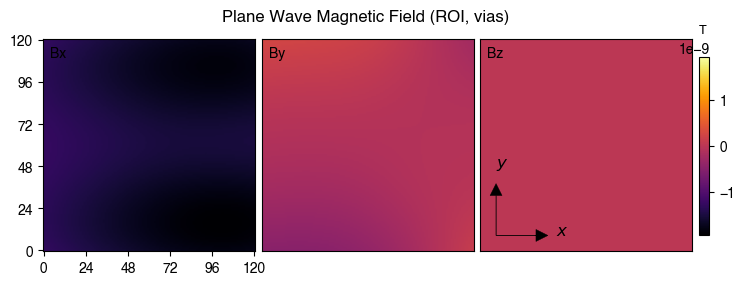

In [38]:
vias_I_roi = {}

for i, (p_via, q_via) in enumerate(vias_start):
    
    I_k = I_solution[i]
    current_value = -I_k # The signed current value
    
    key = undirected_key(np.array(p_via), np.array(q_via))
    
    vias_I_roi[key] = {
        'ps': p_via,
        'qs': q_via,
        'current': current_value,
        'type': 'Start_Via_Upward' 
    }

for i, (p_via, q_via) in enumerate(vias_end):
    
    I_k = I_solution[i]
    current_value = I_k # The signed current value
  
    key = undirected_key(np.array(p_via), np.array(q_via))
   
    vias_I_roi[key] = {
        'ps': p_via,
        'qs': q_via,
        'current': current_value,
        'type': 'End_Via_Downward'
    }

B_vias = get_b_from_vias_to_grid(vias_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

Bx_vias, By_vias, Bz_vias = B_vias[0], B_vias[1], B_vias[2]
data_vias = np.stack([Bx_vias, By_vias, Bz_vias], axis=0)

%matplotlib inline
fig = plot_n_components(
    data_vias,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI, vias)'
)

#### Troubleshoot (Single Via, Dummy Example)

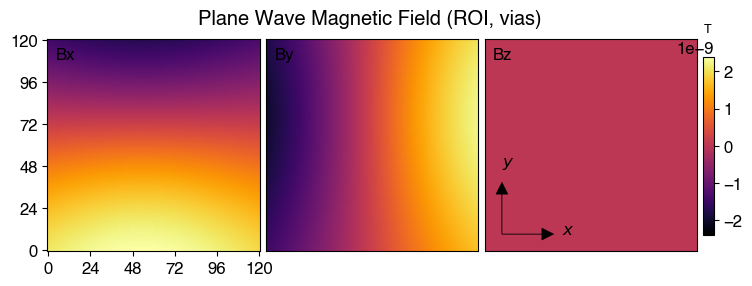

In [314]:
first_key = list(vias_I_roi.keys())[12]
data_first = vias_I_roi[first_key] 

vias_single = {first_key: data_first}

B_first = get_b_from_vias_to_grid(vias_single, obs_pts_roi, Nx_ROI, Ny_ROI)

Bx_first, By_first, Bz_first = B_first[0], B_first[1], B_first[2]
data_first = np.stack([Bx_first, By_first, Bz_first], axis=0)

%matplotlib inline
fig = plot_n_components(
    data_first,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI, vias)'
)

In [269]:
VIA_HALF_LENGTH = 0.01 
VIA_RADIUS_FOR_GRID = 0.03 # Used for defining grid extent (3 cm radius)

# Current is set to 1.0 A, flowing DOWNWARD (Z+ to Z-)
I_signed = 1.0 
current_direction_label = "Downward"
I_use = I_signed

# Wire segment points (P to Q defines the positive current direction)
p_via_vis = np.array([0.0, 0.0, VIA_HALF_LENGTH])   # Top (Z = +0.01 m)
q_via_vis = np.array([0.0, 0.0, -VIA_HALF_LENGTH])  # Bottom (Z = -0.01 m)
via_length = 2 * VIA_HALF_LENGTH # 0.02 m

single_via_data = {
    'ps': p_via_vis,
    'qs': q_via_vis,
    'current': I_signed,
    'type': 'Test_Single_Wire'
}

# Wrap it into the expected dictionary format for the function (dictionary of dictionaries)
# The key can be anything unique, e.g., a simple tuple of points
vias_single = {
    tuple(p_via_vis.tolist() + q_via_vis.tolist()): single_via_data
}

# Determine arrow start/end for plotting (P to Q defines +ve I, which is Downward here)
arrow_start = p_via_vis
arrow_end = q_via_vis


# =========================================================
# 2. Define Observation Grid (ROI format)
# =========================================================

grid_extent_xy = 1.5 * via_length # 0.03 m span
Nx_ROI = 120
Ny_ROI = 120
N_obs = Nx_ROI * Ny_ROI

# Z-coordinate for the observation plane (1 mm above the wire top)
Z_PLANE_HEIGHT = VIA_HALF_LENGTH + 0.004 

x_coords = np.linspace(-grid_extent_xy/2, grid_extent_xy/2, Nx_ROI)
y_coords = np.linspace(-grid_extent_xy/2, grid_extent_xy/2, Ny_ROI)

# Create mesh grids
X_mesh, Y_mesh = np.meshgrid(x_coords, y_coords, indexing='ij')
Z_mesh = np.full_like(X_mesh, Z_PLANE_HEIGHT)

# obs_pts_roi must be (N_obs, 3) flattened array
obs_pts_roi = np.column_stack([X_mesh.ravel(), Y_mesh.ravel(), Z_mesh.ravel()])


# =========================================================
# 3. Calculate B-field using the target function
# =========================================================

# B_vias will be the output, likely (3, Nx_ROI, Ny_ROI)
B_vias = get_b_from_vias_to_grid(vias_single, obs_pts_roi, Nx_ROI, Ny_ROI)

Bx_vias, By_vias, Bz_vias = B_vias[0], B_vias[1], B_vias[2]
data_vias = np.stack([Bx_vias, By_vias, Bz_vias], axis=0)

%matplotlib inline
fig = plot_n_components(
    data_vias,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI, vias)'
)

In [272]:
plot_vector_field_2d(data_vias)

#### Total Reconstructed Magnetic Field

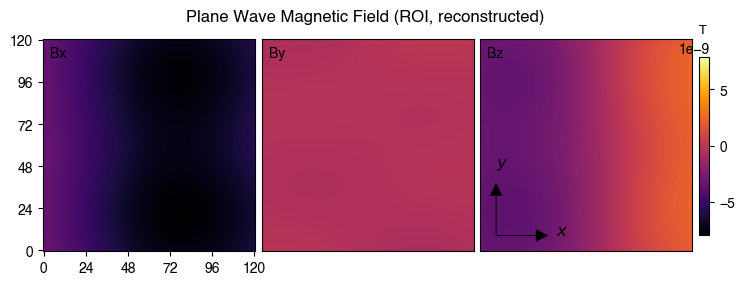

In [ ]:
B_pcb_total = B_pcb_grid + B_vias

Bx_pcb_total, By_pcb_total, Bz_pcb_total = B_pcb_total[0], B_pcb_total[1], B_pcb_total[2]
data_total = np.stack([Bx_pcb_total, By_pcb_total, Bz_pcb_total], axis=0)

%matplotlib inline
fig = plot_n_components(
    data_total,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI, reconstructed)'
)

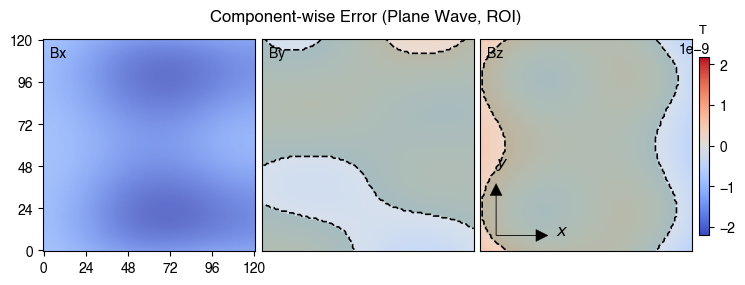

In [40]:
Err = B_pcb_total - B_truth_roi_t   # shape (3, Nx_ROI, Ny_ROI)

# 3) Plot error maps with a diverging colormap centered at 0
fig_err = plot_n_components(
    Err,
    units='T',
    cmap='coolwarm',
    labels=['Bx', 'By', 'Bz'],  # Corrected labels
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Component-wise Error (Plane Wave, ROI)'
)

Bref = B_truth_roi_t
Bmax = float(np.nanmax(np.abs(Bref))) if np.isfinite(Bref).any() else 1.0
eps_scale = 1e-4
eps = eps_scale * Bmax
Rel = np.abs(Err) / (np.abs(Bref) + eps)

# thresholds to show (relative error per component)
levels = [0.1]
colors = {0.1: 'k'}
linest = {0.1: '--'}

axes_img = [ax for ax in fig_err.axes if getattr(ax, "images", [])]

# Corrected NV sensor resolution threshold (e.g., 5 nanotesla)
nv_resolution_threshold = 2e-10
relative_error_threshold = 0.1 # 10%

abs_Err_mag = np.linalg.norm(Err, axis=0)

for k, ax in enumerate(axes_img):
    rel_k = Rel[k]  # Relative error for component k
    err_k = Err[k]  # Absolute error for component k

    # Check the condition component-wise
    good_fit_mask = (rel_k.T <= relative_error_threshold) | (np.abs(err_k.T) <= nv_resolution_threshold)

    ax.imshow(good_fit_mask.astype(float), cmap='Greens',
              alpha=0.2, origin='lower', zorder=0)

    for lev in levels:
        CS = ax.contour(good_fit_mask, levels=[lev], colors=colors[lev],
                        linewidths=1.2, linestyles=linest[lev], origin='lower')
        #ax.clabel(CS, fmt={lev: f'{int(lev*100)}%'}, inline=True, fontsize=8)

plt.draw()

In [41]:
length_start = 0.02
length_end = 0.2
length_step = 0.001
length_list = np.arange(length_start, length_end+length_step, length_step)

results = {
    'length': length_list,
    'magnitude': []
}

print("Starting Vias Length Influence Analysis...")

for L in length_list:
    vias_start, vias_end, all_vias = generate_return_vias(edges_trim, return_length_m=L)
    vias_I_roi = {}

    for i, (p_via, q_via) in enumerate(vias_start):
        
        I_k = I_solution[i]
        current_value = -I_k # The signed current value
        
        key = undirected_key(np.array(p_via), np.array(q_via))
        
        vias_I_roi[key] = {
            'ps': p_via,
            'qs': q_via,
            'current': current_value,
            'type': 'Start_Via_Upward' 
        }

    for i, (p_via, q_via) in enumerate(vias_end):
        
        I_k = I_solution[i]
        current_value = I_k # The signed current value
    
        key = undirected_key(np.array(p_via), np.array(q_via))
    
        vias_I_roi[key] = {
            'ps': p_via,
            'qs': q_via,
            'current': current_value,
            'type': 'End_Via_Downward'
        }

    B_vias = get_b_from_vias_to_grid(vias_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

    B_mag = np.linalg.norm(B_vias)
    results['magnitude'].append(B_mag)
    
print("Analysis Complete.")

Starting Vias Length Influence Analysis...
Analysis Complete.


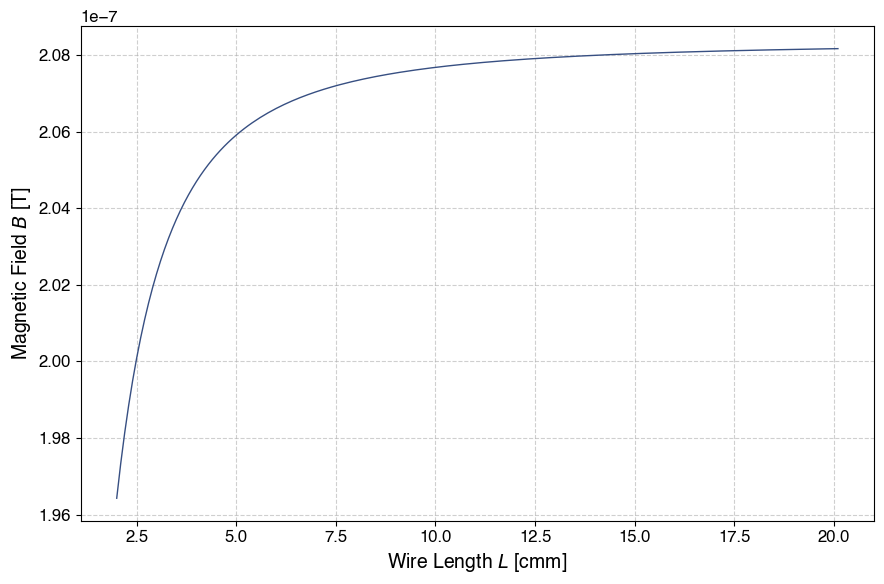

In [42]:
%matplotlib inline
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 1,
    'lines.markersize': 4,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'figure.figsize': (9, 6) # Wider figure for horizontal legend
})

fig, ax = plt.subplots()

X_data = np.array(results['length'])

# Plot Bx
ax.plot(X_data*100, results['magnitude'], label=r'$B_x$ accuracy', color='#374f82', linestyle='-')

ax.set_xlabel(r'Wire Length $L$ [cmm]', fontsize=14)
ax.set_ylabel(r'Magnetic Field $B$ [T]', fontsize=14)

ax.grid(True, which='both')
plt.tight_layout()
plt.show()

#### Current Reconstruction Including Vias

In [ ]:
A_pcb = get_A_matrix(obs_pts_roi, edges_trim)
A_vias_start = get_A_matrix_vias(obs_pts_roi, vias_start, sign=-1.0)
A_vias_end = get_A_matrix_vias(obs_pts_roi, vias_end, sign=1.0)

M = A_pcb.shape[1]
N_rows = A_pcb.shape[0]

A_total = np.zeros((N_rows, M), dtype=np.float64)

for m in range(M):
    A_column = A_pcb[:,m] + A_vias_start[:,m] + A_vias_end[:,m]
    A_total[:,m] = A_column

I_total_sol, _, _, _ = np.linalg.lstsq(A_total, B_truth_vector, rcond=None)

edge_I_roi = {}
for i, (p_raw, q_raw) in enumerate(edges_trim):
    key = undirected_key(np.array(p_raw), np.array(q_raw))
    edge_I_roi[key] = I_total_sol[i, 0]

B_pcb_grid = get_b_from_edges_to_grid(edges_trim, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

vias_I_roi = {}

for i, (p_via, q_via) in enumerate(vias_start):
    
    I_k = I_total_sol[i]
    current_value = -I_k # The signed current value
    
    key = undirected_key(np.array(p_via), np.array(q_via))
    
    vias_I_roi[key] = {
        'ps': p_via,
        'qs': q_via,
        'current': current_value,
        'type': 'Start_Via_Upward' 
    }

for i, (p_via, q_via) in enumerate(vias_end):
    
    I_k = I_total_sol[i]
    current_value = I_k # The signed current value
  
    key = undirected_key(np.array(p_via), np.array(q_via))
   
    vias_I_roi[key] = {
        'ps': p_via,
        'qs': q_via,
        'current': current_value,
        'type': 'End_Via_Downward'
    }

B_vias = get_b_from_vias_to_grid(vias_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

B_reconstructed = B_pcb_grid+B_vias

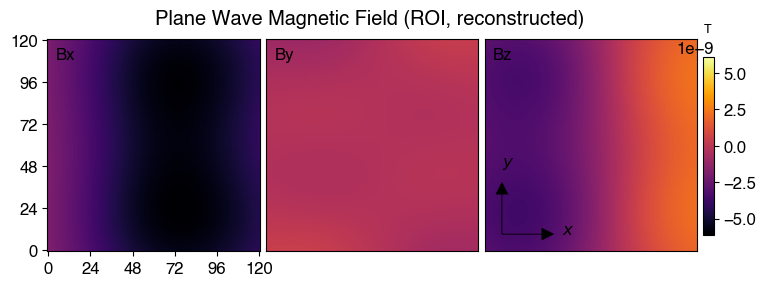

In [45]:
Bx_rec, By_rec, Bz_rec = B_reconstructed[0], B_reconstructed[1], B_reconstructed[2]
data_rec = np.stack([Bx_rec, By_rec, Bz_rec], axis=0)

%matplotlib inline
fig = plot_n_components(
    data_rec,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI, reconstructed)'
)

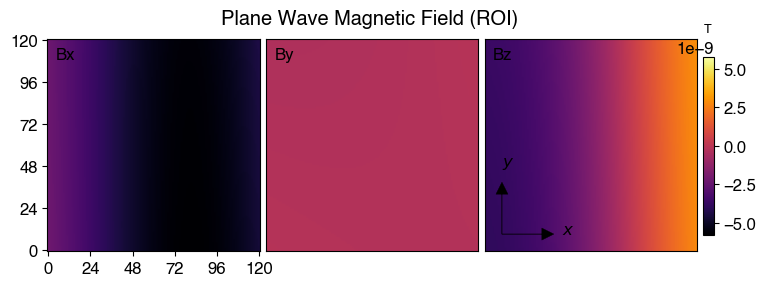

In [46]:
fig = plot_n_components(
    data,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI)'
)

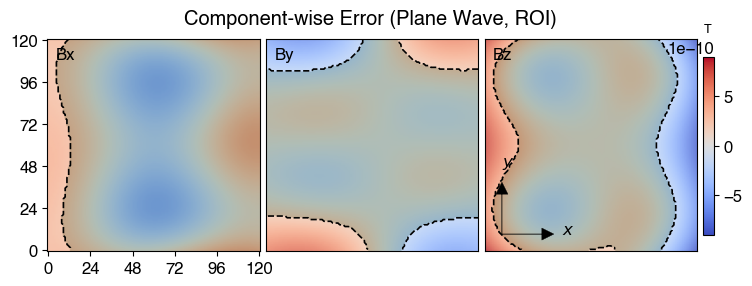

In [47]:
Err = B_reconstructed - B_truth_roi_t   # shape (3, Nx_ROI, Ny_ROI)

# 3) Plot error maps with a diverging colormap centered at 0
fig_err = plot_n_components(
    Err,
    units='T',
    cmap='coolwarm',
    labels=['Bx', 'By', 'Bz'],  # Corrected labels
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Component-wise Error (Plane Wave, ROI)'
)

Bref = B_truth_roi_t
Bmax = float(np.nanmax(np.abs(Bref))) if np.isfinite(Bref).any() else 1.0
eps_scale = 1e-4
eps = eps_scale * Bmax
Rel = np.abs(Err) / (np.abs(Bref) + eps)

# thresholds to show (relative error per component)
levels = [0.1]
colors = {0.1: 'k'}
linest = {0.1: '--'}

axes_img = [ax for ax in fig_err.axes if getattr(ax, "images", [])]

# Corrected NV sensor resolution threshold (e.g., 5 nanotesla)
nv_resolution_threshold = 2e-10
relative_error_threshold = 0.1 # 10%

abs_Err_mag = np.linalg.norm(Err, axis=0)

for k, ax in enumerate(axes_img):
    rel_k = Rel[k]  # Relative error for component k
    err_k = Err[k]  # Absolute error for component k

    # Check the condition component-wise
    good_fit_mask = (rel_k.T <= relative_error_threshold) | (np.abs(err_k.T) <= nv_resolution_threshold)

    ax.imshow(good_fit_mask.astype(float), cmap='Greens',
              alpha=0.2, origin='lower', zorder=0)

    for lev in levels:
        CS = ax.contour(good_fit_mask, levels=[lev], colors=colors[lev],
                        linewidths=1.2, linestyles=linest[lev], origin='lower')
        #ax.clabel(CS, fmt={lev: f'{int(lev*100)}%'}, inline=True, fontsize=8)

plt.draw()

### Phantom Geometry Implementation 

<b>Objective:</b> Import the PCB geometry from KiCad, including all layers, traces and vias. 

Because of the way data is imported from KiCad, we first check that all segments are correctly imported and that there is continuity between them, i.e. the only endpoints are the connectors pins on the bottom layer. Next, we have to prepare the data in order to feed it to the current reconstruction alogrithm. To do that, starting from each edge enpoint in the top F.Cu layer, we follow the path across layers up to the correspondent connector pin on the bottom B.Cu layer. Having done that, we have a trace, which is a collection of segments that spans across layers.

Then, we need to "import" the PCB geometry into the tissue slab reference system, in order to use the reconstruction algorithm we developed. To do that, we apply a rigid body transformation to map the coordinates from the KiCad reference frame to the tissue slab reference frame. The transformation is defined by an optimal rotation matrix (<b>R</b>) and a translation vector (<b>T</b>) calculated using the <b>Singular Value Decomposition (SVD)</b> method. Therefore any point $P_{KiCad}$ is mapped to the corresponding tissue coordinate $P_{tissue}$, using the following linear equation: $$P_{sensor}=RP_{KiCad}+T.$$

In order to find the optimal $R$ and $T$, we:

1. Compute the centroids of the control point clouds and subtract them to the latter in order to get the centered points. 
2. Compute the covariance matrix $H=(P'_{KiCad})^{\text{T}}P'_{tissue}$.
3. Decompose the covariance matrix $H=U\Sigma V^{\text{T}}$.
4. Find the optimal rotation matrix as $R=UV^{\text{T}}$.
5. Find the translation vector as $T=C_{tissue}-RC_{KiCad}$.

For references, please look at [1], [2].

[1] Least-squares fitting of two 3-D point sets, KS Arun

[2] Least-squares estimation of transformation parameters between two point patterns, S. Umeyama

#### Geometry

In [59]:
def plot_trace_geometry_3d(layer_segments: Dict[str, List[Segment3D]], open_end_points: List[Point3D], layers_to_plot: List[str] = None, unit_label='mm'):
    """
    Plots the extracted 3D trace segments and marks all provided open end points.
    """
    
    CUSTOM_COLOR_MAP: Dict[str, str] = {
        "F.Cu": 'red',      
        "In1.Cu": 'green',    
        "In2.Cu": 'orange',   
        "B.Cu": 'blue',     
        "Vias": 'purple',   
        "default": 'gray'
    }

    if layers_to_plot is None:
        layers_to_plot = list(layer_segments.keys())

    layers_to_process = {k: v for k, v in layer_segments.items() if k in layers_to_plot and v} 

    all_segments = [seg for segments in layers_to_process.values() for seg in segments]
    
    if not all_segments:
        print("No segments to plot after filtering.")
        return

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f'3D PCB Trace Geometry with Endpoints (Red Markers) - Unit: {unit_label}')

    UNIT_CONVERSION = 1000 
    all_coords = []
    
    # --- 1. Plot Segments ---
    for layer_name, segments in layers_to_process.items():
        color = CUSTOM_COLOR_MAP.get(layer_name, CUSTOM_COLOR_MAP["default"])
        
        for (p1_x, p1_y, p1_z), (p2_x, p2_y, p2_z) in segments:
            x_pts = [p1_x * UNIT_CONVERSION, p2_x * UNIT_CONVERSION]
            y_pts = [p1_y * UNIT_CONVERSION, p2_y * UNIT_CONVERSION]
            z_pts = [p1_z * UNIT_CONVERSION, p2_z * UNIT_CONVERSION]
            
            all_coords.extend([(p1_x, p1_y, p1_z), (p2_x, p2_y, p2_z)])

            label = layer_name if layer_name not in ax.get_legend_handles_labels()[1] else ""
            lw = 2.5 if layer_name == "Vias" else 1.5
            
            ax.plot(x_pts, y_pts, z_pts, color=color, linewidth=lw, alpha=0.8, label=label)
    
    # --- 2. Plot Open Ends as Markers ---
    if open_end_points:
        open_x = [p[0] * UNIT_CONVERSION for p in open_end_points]
        open_y = [p[1] * UNIT_CONVERSION for p in open_end_points]
        open_z = [p[2] * UNIT_CONVERSION for p in open_end_points]
        
        # Add a placeholder point for the legend only
        ax.scatter([], [], [], marker='o', color='red', s=100, label='Open End (Interruption)')
        
        # Plot the actual points
        ax.scatter(open_x, open_y, open_z, marker='o', color='red', s=50, depthshade=True, alpha=1.0, zorder=10)
        
        # Add open end coordinates to overall limits calculation
        all_coords.extend(open_end_points)

    # Set labels and axis limits
    ax.set_xlabel(f'X Coordinate ({unit_label})')
    ax.set_ylabel(f'Y Coordinate ({unit_label})')
    ax.set_zlabel(f'Z Coordinate ({unit_label})')
    
    ax.legend(title="Layers & Status")

    # Ensure axes are scaled equally
    all_coords_np = np.array(all_coords)
    
    if all_coords_np.size > 0:
        x_min, x_max = np.min(all_coords_np[:, 0]), np.max(all_coords_np[:, 0])
        y_min, y_max = np.min(all_coords_np[:, 1]), np.max(all_coords_np[:, 1])
        z_min, z_max = np.min(all_coords_np[:, 2]), np.max(all_coords_np[:, 2])

        max_range = max(x_max - x_min, y_max - y_min) * UNIT_CONVERSION 
        
        x_mid = (x_min + x_max) * UNIT_CONVERSION / 2
        y_mid = (y_min + y_max) * UNIT_CONVERSION / 2
        
        # Set X/Y limits to ensure square aspect ratio in plane
        ax.set_xlim(x_mid - max_range/2, x_mid + max_range/2)
        ax.set_ylim(y_mid - max_range/2, y_mid + max_range/2)
        
        # Adjust Z limits (Z range is usually smaller, so use a fixed multiplier)
        z_range = (z_max - z_min) * UNIT_CONVERSION
        z_mid = (z_min + z_max) * UNIT_CONVERSION / 2
        # Use a slightly wider Z range to ensure markers are visible
        z_extent = max(z_range * 0.6, 1.0) # Ensure a minimum extent of 1mm
        ax.set_zlim(z_mid - z_extent, z_mid + z_extent)

        
    ax.view_init(elev=90, azim=-90)
    plt.show()

Reading KiCad PCB file: /Users/ValerioDeSio/Desktop/PhantyTiny_v06.kicad_pcb
Found 408 horizontal trace segments.
Found 20 via elements.
Manually adding 3 segment(s) to layer F.Cu.
Manually adding 2 segment(s) to layer In1.Cu.
Manually adding 2 segment(s) to layer In2.Cu.
Manually adding 4 segment(s) to layer B.Cu.
Total segments successfully extracted (auto: 428, manual: 11): 439

--- Checking Layer-by-Layer Continuity ---
Layer F.Cu: 48 open ends. *** PASS: Matches Expected Count! ***
Layer In1.Cu: 24 open ends. *** PASS: Matches Expected Count! ***
Layer In2.Cu: 16 open ends. *** PASS: Matches Expected Count! ***
Layer B.Cu: 96 open ends. *** PASS: Matches Expected Count! ***
Found 48 potential starting vias on F.Cu to check for traces.
  > Trace 1 found (Length: 10 segments). [Verified: OK]
  > Trace 2 found (Length: 6 segments). [Verified: OK]
  > Trace 3 found (Length: 6 segments). [Verified: OK]
  > Trace 4 found (Length: 14 segments). [Verified: OK]
  > Trace 5 found (Length: 1

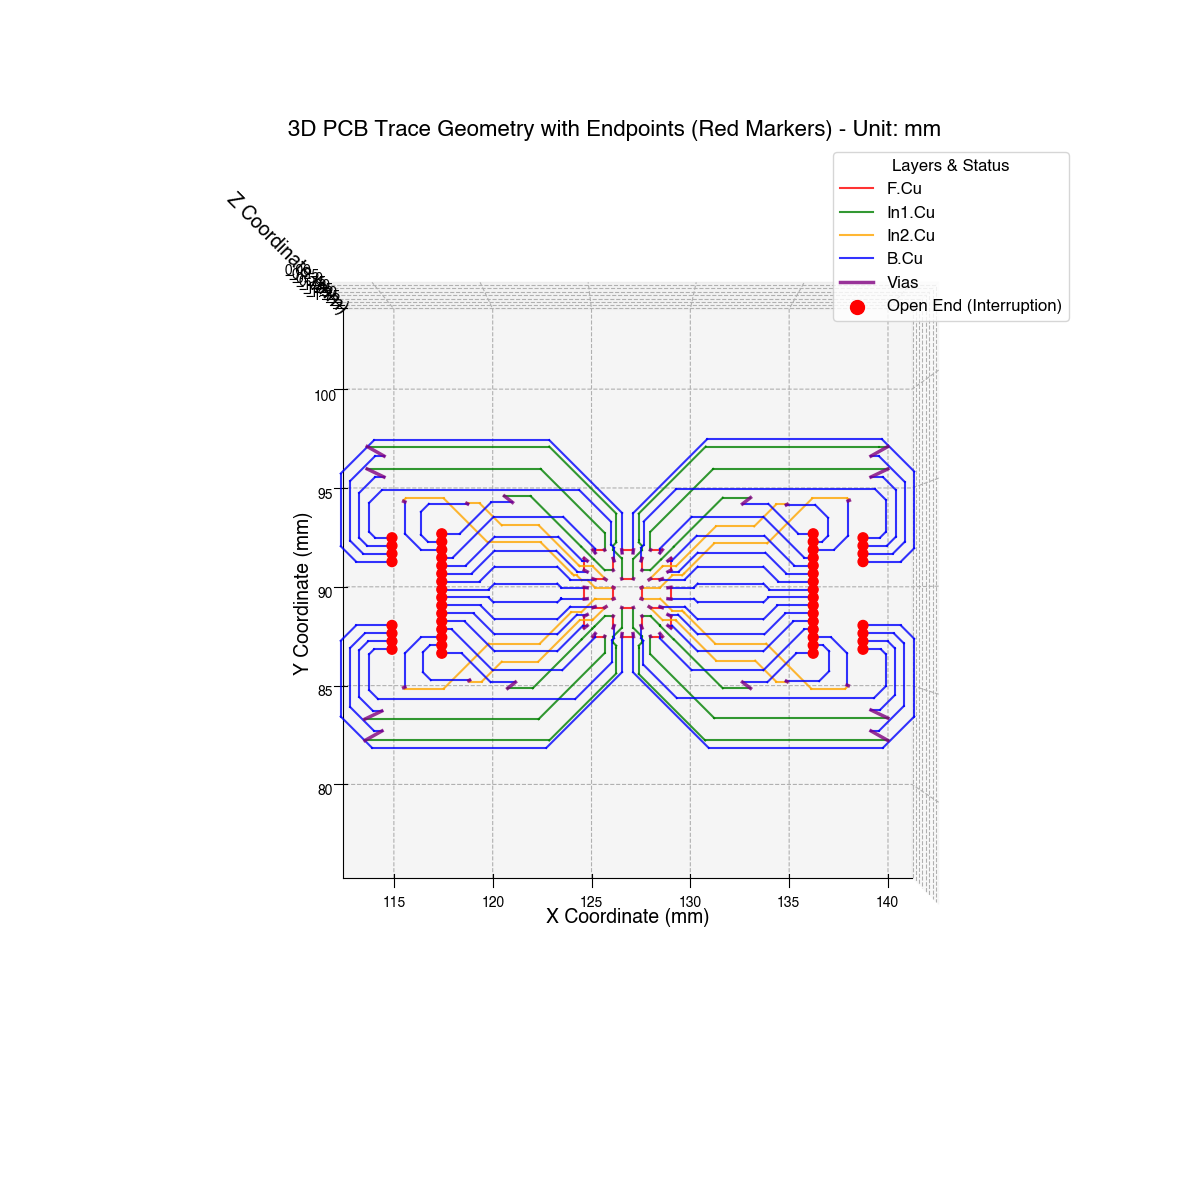

In [60]:
# z coordinate for PCB layers
pcb_layers: Dict[str, float] = {
    "F.Cu": 0.0,     
    "In1.Cu": -0.135e-3, 
    "In2.Cu": -1.51e-3,
    "B.Cu": -1.645e-3,
}

# Define manually segments that for some reason are not imported from kicad_pcb
manual_segments: Dict[str, List[Segment3D]] = {
    "F.Cu": [
        ((0.1252, 0.089, 0), (0.12575, 0.089, 0)),
        ((0.12655, 0.089, 0), (0.1271, 0.089, 0)),
        ((0.1279, 0.089, 0), (0.12845, 0.089, 0)),
    ],
    "In1.Cu": [
        ((0.12655, 0.088045, -0.135e-3), (0.12655, 0.089, -0.135e-3)),
        ((0.1271, 0.088040323, -0.135e-3), (0.1271, 0.089, -0.135e-3)),
    ],
    "In2.Cu": [
        ((0.125095, 0.08836, -1.51e-3),(0.12575, 0.089, -1.51e-3)),
        ((0.1279, 0.089, -1.51e-3), (0.12858, 0.088325, -1.51e-3)),
    ], 
    "B.Cu": [
        ((0.123295, 0.08836, -1.645e-3),(0.12395, 0.089, -1.645e-3)),
        ((0.12395, 0.089, -1.645e-3), (0.1252, 0.089, -1.645e-3)),
        ((0.130345, 0.08836, -1.645e-3), (0.1297, 0.089, -1.645e-3)),
        ((0.12845, 0.089, -1.645e-3),(0.1297, 0.089, -1.645e-3)),
    ],
}

KICAD_PCB_FILE_PATH = '/Users/ValerioDeSio/Desktop/PhantyTiny_v06.kicad_pcb'

phantom_traces = import_kicad_pcb(
    kicad_pcb_filepath=KICAD_PCB_FILE_PATH,
    stackup=pcb_layers,
    manual_segments=manual_segments
)

expected_open_ends: Dict[str, int] = {
    "F.Cu": 48,    
    "In1.Cu": 24,    
    "In2.Cu": 16,   
    "B.Cu": 96   
}

open_ends = check_layer_continuity(phantom_traces, expected_open_ends, tolerance=1e-6) 

phantom_traces = add_implicit_return_vias(phantom_traces, pcb_layers)
phantom_traces = trim_vias_to_connected_layers(phantom_traces, pcb_layers)
open_end_points = find_missing_via_endpoints(phantom_traces, pcb_layers)

ordered_phantom_traces = find_all_traces(phantom_traces, pcb_layers, "F.Cu", "B.Cu")
generate_tabular_output(ordered_phantom_traces)

LAYERS_TO_VISUALIZE = ["F.Cu", "In1.Cu", "In2.Cu", "B.Cu", "Vias"]
%matplotlib widget
if phantom_traces:
    print(f"\n--- Starting 3D Plot (Filtering for: {LAYERS_TO_VISUALIZE}) ---")
    plot_trace_geometry_3d(
        phantom_traces, 
        layers_to_plot=LAYERS_TO_VISUALIZE,
        unit_label='mm',
        open_end_points=open_end_points
    )


In [63]:
tissue_control_points = np.array([
    edges_trim[0][0],
    edges_trim[0][1],
    edges_trim[4][0],
    edges_trim[4][1],
    edges_trim[8][0],
    edges_trim[8][1],
    edges_trim[12][0],
    edges_trim[12][1],
    edges_trim[14][0],
    edges_trim[14][1],
    edges_trim[17][0],
    edges_trim[17][1],
    edges_trim[20][0],
    edges_trim[20][1],
    edges_trim[21][0],
    edges_trim[21][1],
    edges_trim[23][0],
    edges_trim[23][1]
])

pcb_control_points = np.array([
    ordered_phantom_traces[31][0][0],
    ordered_phantom_traces[38][0][0],
    ordered_phantom_traces[40][0][0],
    ordered_phantom_traces[47][0][0],
    ordered_phantom_traces[5][0][0],
    ordered_phantom_traces[45][0][0],
    ordered_phantom_traces[43][0][0],
    ordered_phantom_traces[34][0][0],
    ordered_phantom_traces[33][0][0],
    ordered_phantom_traces[39][0][0],
    ordered_phantom_traces[6][0][0],
    ordered_phantom_traces[41][0][0],
    ordered_phantom_traces[15][0][0],
    ordered_phantom_traces[2][0][0],
    ordered_phantom_traces[9][0][0],
    ordered_phantom_traces[17][0][0],
    ordered_phantom_traces[19][0][0],
    ordered_phantom_traces[27][0][0]
])

R, T, rmse = calculate_transformation_parameters(pcb_control_points, tissue_control_points)
tissue_phantom_traces = apply_transformation(ordered_phantom_traces, R, T)

print("\n" + "="*50)
print("TRANSFORMATION PARAMETER VERIFICATION")
print("="*50)
print(f"RMS Error: {rmse:.17f}")
print("\nRotation Matrix (R):\n", R)
print("\nTranslation Vector (T):\n", T)
print("="*50)
verify_via_to_edge_continuity(tissue_phantom_traces, edges_trim)

phantom_start_traces, phantom_end_traces = split_and_order_traces(edges_trim, tissue_phantom_traces)


TRANSFORMATION PARAMETER VERIFICATION
RMS Error: 0.00000000000000005

Rotation Matrix (R):
 [[ 1.00000000e+00  1.67510601e-16  0.00000000e+00]
 [ 2.47164711e-17 -1.00000000e+00  3.75730940e-30]
 [-1.69362791e-46  3.75730940e-30  1.00000000e+00]]

Translation Vector (T):
 [-1.0385e-01  1.1535e-01  1.0000e-04]

EXTERNAL CONTINUITY VERIFICATION: VIA START POINT vs. EDGES_TRIM (NV SENSOR)
Trace 1 Start Point (Via Top): 0.0236500, 0.0273000, 0.0001000 | Status: VERIFIED (Match Found)
Trace 2 Start Point (Via Top): 0.0250000, 0.0254000, 0.0001000 | Status: VERIFIED (Match Found)
Trace 3 Start Point (Via Top): 0.0246000, 0.0277000, 0.0001000 | Status: VERIFIED (Match Found)
Trace 4 Start Point (Via Top): 0.0223000, 0.0259500, 0.0001000 | Status: VERIFIED (Match Found)
Trace 5 Start Point (Via Top): 0.0223000, 0.0240500, 0.0001000 | Status: VERIFIED (Match Found)
Trace 6 Start Point (Via Top): 0.0227000, 0.0236500, 0.0001000 | Status: VERIFIED (Match Found)
Trace 7 Start Point (Via Top): 0.02

#### Reconstructed magnetic field without traces

Optimal scaling factor (alpha): -0.18383917557626728


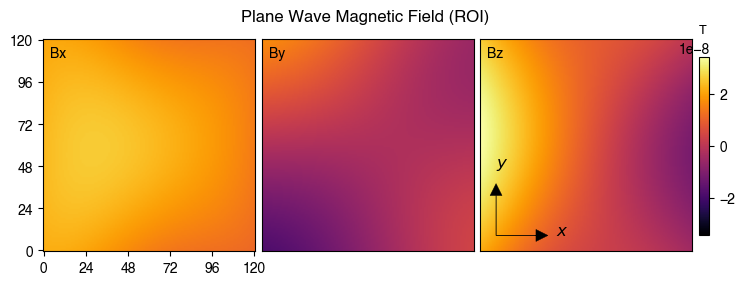

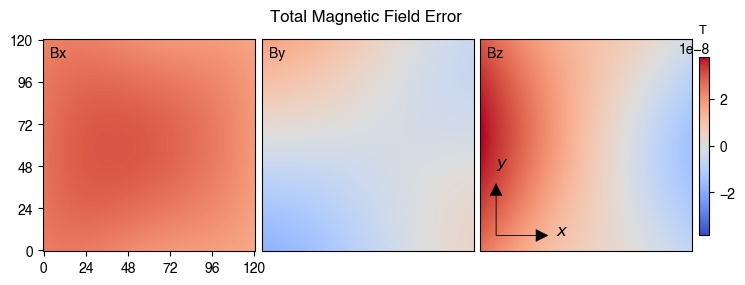

In [20]:
edge_I_roi = {}
for i, (p_raw, q_raw) in enumerate(edges_trim):
    key = undirected_key(np.array(p_raw), np.array(q_raw))
    edge_I_roi[key] = I_solution[i, 0]

B_pcb_grid = get_b_from_edges_to_grid(edges_trim, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)


trace_segment_I_dict = {}
all_trace_segments = []

for i, trace in enumerate(phantom_start_traces):
    I_k = I_solution[i, 0]
    I_trace = -I_k # Current flows opposite to loop current I_k
    
    for p_raw, q_raw in trace:
        p = np.asarray(p_raw, dtype=np.float64)
        q = np.asarray(q_raw, dtype=np.float64)
        key = undirected_key(p, q)
        
        # The segment's geometric direction is P->Q (Top->Bottom).
        # I_trace is the signed current relative to this geometric direction.
        trace_segment_I_dict[key] = I_trace
        all_trace_segments.append((p_raw, q_raw))

# Process End Traces (Physical current = +I_k)
for i, trace in enumerate(phantom_end_traces):
    I_k = I_solution[i, 0]
    I_trace = I_k # Current flows with loop current I_k
    
    for p_raw, q_raw in trace:
        p = np.asarray(p_raw, dtype=np.float64)
        q = np.asarray(q_raw, dtype=np.float64)
        key = undirected_key(p, q)
        
        # The segment's geometric direction is P->Q (Top->Bottom).
        # I_trace is the signed current relative to this geometric direction.
        trace_segment_I_dict[key] = I_trace
        all_trace_segments.append((p_raw, q_raw))

B_traces = get_b_from_segments_to_grid(all_trace_segments, trace_segment_I_dict, obs_pts_roi, Nx_ROI, Ny_ROI)

B_total_notrace = B_pcb_grid + B_traces

B_total_flat = B_total_notrace.reshape(-1)
B_truth_vector_flat = B_truth_roi_t.reshape(-1)

# Calculate the optimal scalar (alpha) to match the magnitudes
alpha = np.dot(B_truth_vector_flat, B_total_flat) / np.dot(B_total_flat, B_total_flat)
print(f"Optimal scaling factor (alpha): {alpha}")

Bx_notrace, By_notrace, Bz_notrace = B_total_notrace[0], B_total_notrace[1], B_total_notrace[2]
data_notrace = np.stack([Bx_notrace, By_notrace, Bz_notrace], axis=0)

%matplotlib inline
fig = plot_n_components(
    data_notrace,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI)'
)

Err = B_total_notrace - B_truth_roi_t   # shape (3, Nx_ROI, Ny_ROI)

# 3) Plot error maps with a diverging colormap centered at 0
fig_err = plot_n_components(
    Err,
    units='T',
    cmap='coolwarm',
    labels=['Bx', 'By', 'Bz'],  # Corrected labels
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Total Magnetic Field Error'
)

Bref = B_truth_roi_t
Bmax = float(np.nanmax(np.abs(Bref))) if np.isfinite(Bref).any() else 1.0
eps_scale = 1e-4
eps = eps_scale * Bmax
Rel = np.abs(Err) / (np.abs(Bref) + eps)

# thresholds to show (relative error per component)
levels = [0.1]
colors = {0.1: 'k'}
linest = {0.1: '--'}

axes_img = [ax for ax in fig_err.axes if getattr(ax, "images", [])]

# Corrected NV sensor resolution threshold (e.g., 5 nanotesla)
nv_resolution_threshold = 2e-10
relative_error_threshold = 0.01 # 10%

abs_Err_mag = np.linalg.norm(Err, axis=0)

for k, ax in enumerate(axes_img):
    rel_k = Rel[k]  # Relative error for component k
    err_k = Err[k]  # Absolute error for component k

    # Check the condition component-wise
    good_fit_mask = (np.abs(err_k.T) <= nv_resolution_threshold)
    '''
    ax.imshow(good_fit_mask.astype(float), cmap='Greens',
              alpha=0.3, origin='lower', zorder=0)

    for lev in levels:
        CS = ax.contour(good_fit_mask, levels=[lev], colors=colors[lev],
                        linewidths=1.2, linestyles=linest[lev], origin='lower')
        #ax.clabel(CS, fmt={lev: f'{int(lev*100)}%'}, inline=True, fontsize=8)
    '''
plt.draw()


#### Reconstructed magnetic field including traces

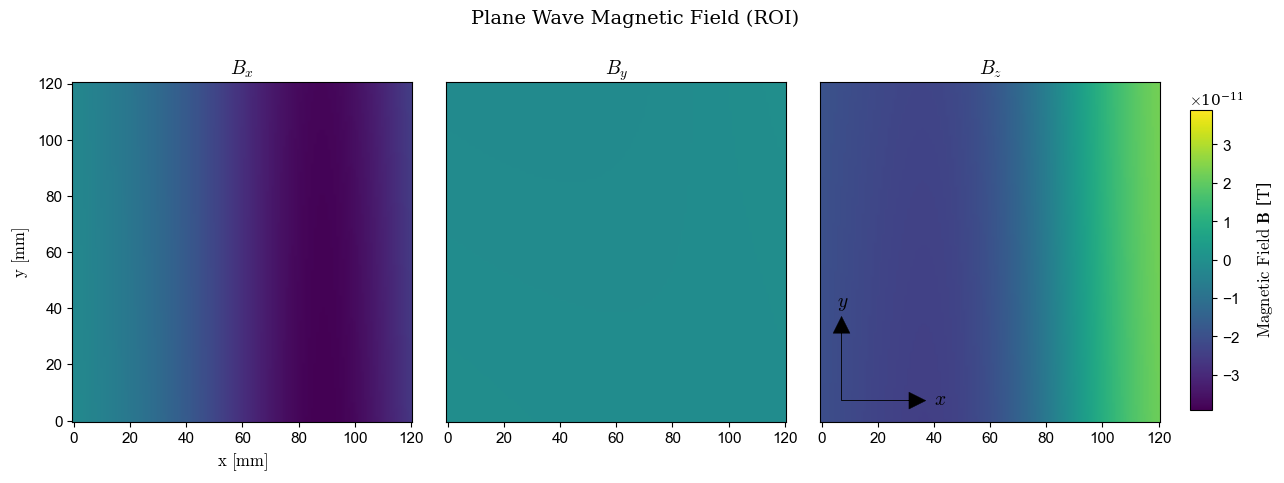

In [65]:
z_sensor = max(z_u) + 2e-3

xmin, xmax, ymin, ymax = roi['bounds']
Nx_ROI, Ny_ROI = 121, 121
sensor_roi = RegularGridSensor(bounds=(xmin, xmax, ymin, ymax, z_sensor, z_sensor),
                               resolution=(Nx_ROI, Ny_ROI, 1))
obs_pts_roi = sensor_roi.points

B_truth_roi = get_b_from_monopoles_to_grid(gcs1, gds1, obs_pts_roi, Nx_ROI, Ny_ROI)
B_truth_roi_t = B_truth_roi[:, :, :, t_idx]     # (3, Nx_ROI, Ny_ROI)

Bx, By, Bz = B_truth_roi_t[0], B_truth_roi_t[1], B_truth_roi_t[2]
data = np.stack([Bx, By, Bz], axis=0)

%matplotlib inline
'''
fig = plot_n_components(
    data,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI)'
)
'''

fig = plot_b_field_components(data, units='T', title='Plane Wave Magnetic Field (ROI)', coord_show=True)

In [66]:
A_edges = get_A_matrix(obs_pts_roi, edges_trim)
A_traces_start = get_A_matrix_traces_split(obs_pts_roi, phantom_start_traces, sign=-1.0)
A_traces_end = get_A_matrix_traces_split(obs_pts_roi, phantom_end_traces, sign=1.0)

M = A_edges.shape[1]
N_rows = A_edges.shape[0]

A_total = np.zeros((N_rows, M), dtype=np.float64)

for m in range(M):
    A_column = A_edges[:,m] + A_traces_start[:,m] + A_traces_end[:,m]
    A_total[:,m] = A_column

B_truth_vector = B_truth_roi_t.reshape(3 * Nx_ROI * Ny_ROI, 1)
I_total_sol, _, _, _ = np.linalg.lstsq(A_total, B_truth_vector, rcond=None)

edge_I_roi = {}
for i, (p_raw, q_raw) in enumerate(edges_trim):
    key = undirected_key(np.array(p_raw), np.array(q_raw))
    edge_I_roi[key] = I_total_sol[i, 0]

B_pcb_grid = get_b_from_edges_to_grid(edges_trim, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

trace_segment_I_dict = {}
all_trace_segments = []

layered_all_trace_segments: Dict[float, List[Tuple[Tuple, Tuple]]] = defaultdict(list)
layered_trace_segment_I_dict: Dict[float, Dict[str, float]] = defaultdict(dict)

for i, trace in enumerate(phantom_start_traces):
    I_k = I_total_sol[i, 0]
    I_trace = -I_k # Current flows opposite to loop current I_k
    
    for p_raw, q_raw in trace:
        p = np.asarray(p_raw, dtype=np.float64)
        q = np.asarray(q_raw, dtype=np.float64)
        key = undirected_key(p, q)
        
        # The segment's geometric direction is P->Q (Top->Bottom).
        # I_trace is the signed current relative to this geometric direction.
        trace_segment_I_dict[key] = I_trace
        all_trace_segments.append((p_raw, q_raw))

        Z_coords_to_assign = set()
        
        if abs(p_raw[2] - q_raw[2]) < 1e-9:
            Z_coords_to_assign.add(p_raw[2])
        else:
            Z_coords_to_assign.add(p_raw[2])
            Z_coords_to_assign.add(q_raw[2])
        
        for z in Z_coords_to_assign:
            layered_all_trace_segments[z].append((p_raw, q_raw))
            layered_trace_segment_I_dict[z][key] = I_trace


# Process End Traces (Physical current = +I_k)
for i, trace in enumerate(phantom_end_traces):
    I_k = I_total_sol[i, 0]
    I_trace = I_k # Current flows with loop current I_k
    
    for p_raw, q_raw in trace:
        p = np.asarray(p_raw, dtype=np.float64)
        q = np.asarray(q_raw, dtype=np.float64)
        key = undirected_key(p, q)
        
        # The segment's geometric direction is P->Q (Top->Bottom).
        # I_trace is the signed current relative to this geometric direction.
        trace_segment_I_dict[key] = I_trace
        all_trace_segments.append((p_raw, q_raw))

        Z_coords_to_assign = set()
        
        if abs(p_raw[2] - q_raw[2]) < 1e-9:
            Z_coords_to_assign.add(p_raw[2])
        else:
            Z_coords_to_assign.add(p_raw[2])
            Z_coords_to_assign.add(q_raw[2])
        
        for z in Z_coords_to_assign:
            layered_all_trace_segments[z].append((p_raw, q_raw))
            layered_trace_segment_I_dict[z][key] = I_trace

layered_all_trace_segments = dict(layered_all_trace_segments)
layered_trace_segment_I_dict = dict(layered_trace_segment_I_dict)

B_traces = get_b_from_segments_to_grid(all_trace_segments, trace_segment_I_dict, obs_pts_roi, Nx_ROI, Ny_ROI)

B_total = B_pcb_grid + B_traces

B_total_flat = B_total.reshape(-1)
B_truth_vector_flat = B_truth_roi_t.reshape(-1)

# Calculate the optimal scalar (alpha) to match the magnitudes
alpha = np.dot(B_truth_vector_flat, B_total_flat) / np.dot(B_total_flat, B_total_flat)
print(f"Optimal scaling factor (alpha): {alpha}")

Optimal scaling factor (alpha): 0.9999999999999966


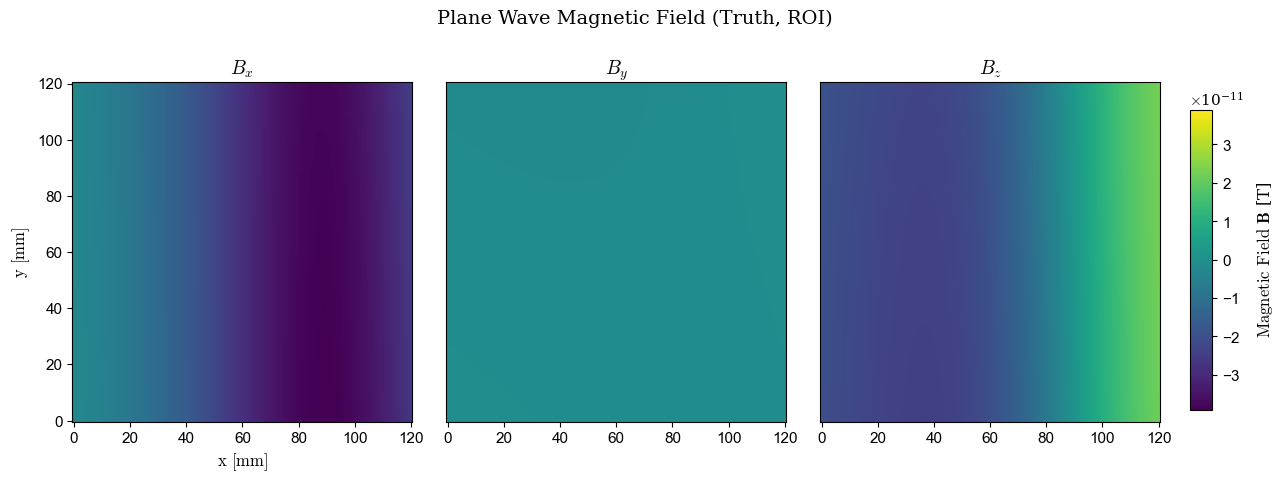

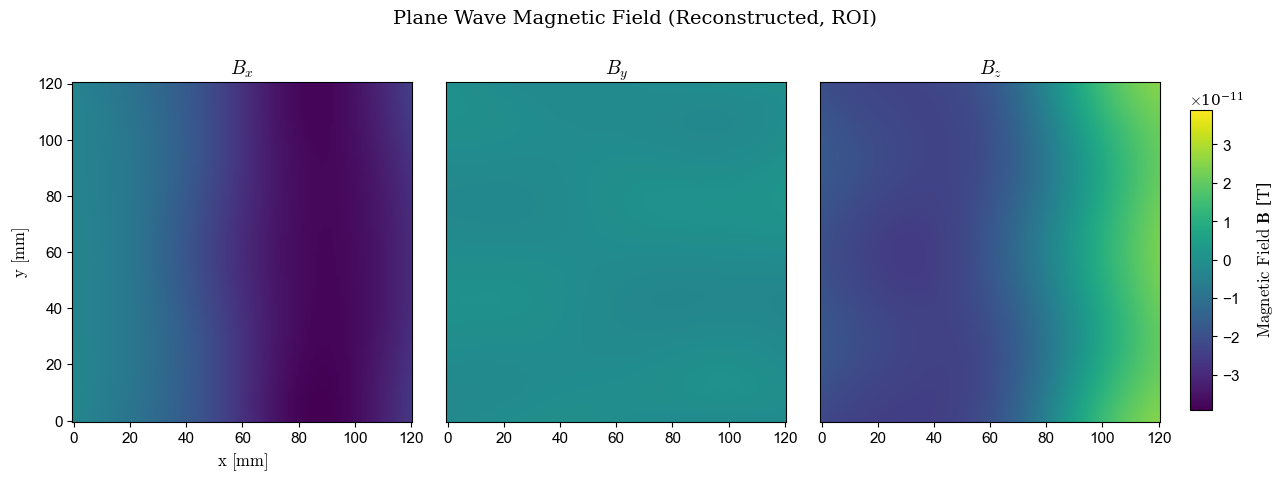

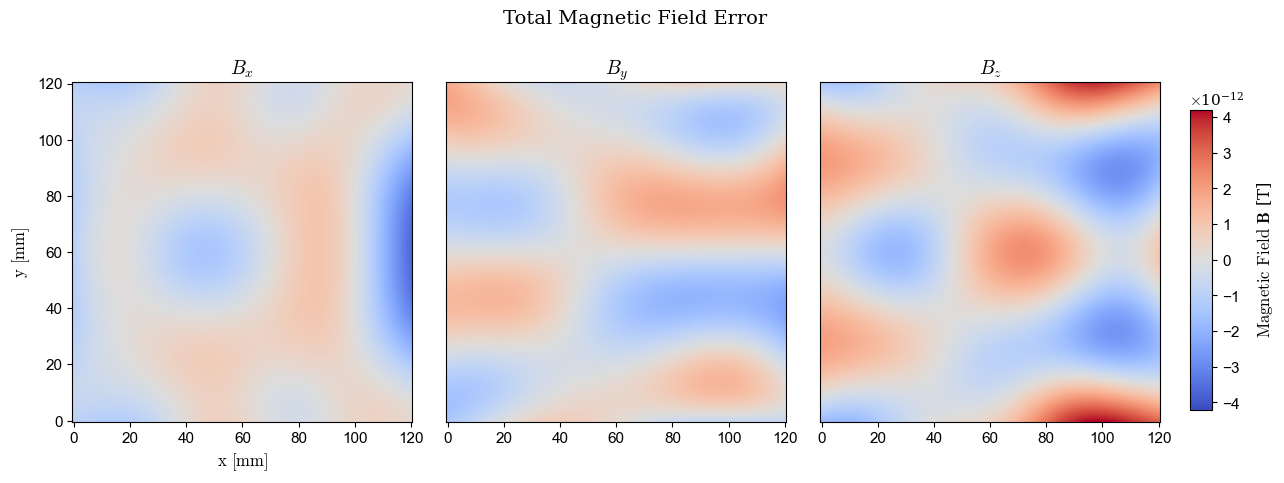

In [67]:
Bx_tot, By_tot, Bz_tot = B_total[0], B_total[1], B_total[2]
data_tot = np.stack([Bx_tot, By_tot, Bz_tot], axis=0)

%matplotlib inline
fig = plot_b_field_components(data, units='T', title='Plane Wave Magnetic Field (Truth, ROI)')

fig = plot_b_field_components(data_tot, units='T', title='Plane Wave Magnetic Field (Reconstructed, ROI)')

Err = B_total - B_truth_roi_t   # shape (3, Nx_ROI, Ny_ROI)

fig_err = plot_b_field_components(Err, units='T', title='Total Magnetic Field Error', cmap='coolwarm')

Bref = B_truth_roi_t
Bmax = float(np.nanmax(np.abs(Bref))) if np.isfinite(Bref).any() else 1.0
eps_scale = 1e-4
eps = eps_scale * Bmax
Rel = np.abs(Err) / (np.abs(Bref) + eps)

# thresholds to show (relative error per component)
levels = [0.1]
colors = {0.1: 'k'}
linest = {0.1: '--'}

axes_img = [ax for ax in fig_err.axes if getattr(ax, "images", [])]

# Corrected NV sensor resolution threshold (e.g., 5 nanotesla)
nv_resolution_threshold = 2e-10
relative_error_threshold = 0.01 # 10%

abs_Err_mag = np.linalg.norm(Err, axis=0)

for k, ax in enumerate(axes_img):
    rel_k = Rel[k]  # Relative error for component k
    err_k = Err[k]  # Absolute error for component k

    # Check the condition component-wise
    good_fit_mask = (np.abs(err_k.T) <= nv_resolution_threshold)
    '''
    ax.imshow(good_fit_mask.astype(float), cmap='Greens',
              alpha=0.3, origin='lower', zorder=0)

    for lev in levels:
        CS = ax.contour(good_fit_mask, levels=[lev], colors=colors[lev],
                        linewidths=1.2, linestyles=linest[lev], origin='lower')
        #ax.clabel(CS, fmt={lev: f'{int(lev*100)}%'}, inline=True, fontsize=8)
    '''
plt.draw()

In [70]:
all_currents = [I_val 
                for layer_dict in layered_trace_segment_I_dict.values() 
                for I_val in layer_dict.values()]

# Compute statistics
I_min = np.min(all_currents)
I_max = np.max(all_currents)
I_mean = np.mean(all_currents)

print(f"Current statistics across all layers:")
print(f"  Minimum current: {I_min:.4e} A")
print(f"  Maximum current: {I_max:.4e} A")
print(f"  Mean current:    {I_mean:.4e} A")

Current statistics across all layers:
  Minimum current: -1.2065e-06 A
  Maximum current: 1.2065e-06 A
  Mean current:    -9.7567e-09 A


##### Pixel-Wise Magnetic Field Swept over Distance (from .5 to 5mm)

In [ ]:
# ============================================================
# PARAMETERS
# ============================================================

z_min_mm, z_max_mm, n_steps = 1, 5.0, 20  # sweep range and number of steps
distances_mm = np.linspace(z_min_mm, z_max_mm, n_steps)
distances_m = distances_mm * 1e-3

# ROI and pixel of interest (choose offset region to see more interesting field)
ix, iy = 3 * Nx_ROI // 4, Ny_ROI // 2
print(f"Selected pixel: (ix={ix}, iy={iy})")

# ============================================================
# ARRAYS TO STORE RESULTS
# ============================================================

B_truth_comp = []   # (n_steps, 3) field at pixel
B_mimic_comp = []   # (n_steps, 3)
B_diff_mag = []     # (n_steps,)
B_truth_list = []   # list of full-field arrays (3, Nx, Ny)
B_mimic_list = []   # same for reconstructed

# ============================================================
# DISTANCE SWEEP
# ============================================================

for z_mm, z_m in zip(distances_mm, distances_m):
    z_sensor = max(z_u) + z_m

    # --- (1) Define observation grid at this distance ---
    sensor_roi = RegularGridSensor(bounds=(xmin, xmax, ymin, ymax, z_sensor, z_sensor),
                                   resolution=(Nx_ROI, Ny_ROI, 1))
    obs_pts_roi = sensor_roi.points

    # --- (2) Compute ground-truth magnetic field ---
    B_truth_roi = get_b_from_monopoles_to_grid(gcs1, gds1, obs_pts_roi, Nx_ROI, Ny_ROI)
    B_truth_roi_t = B_truth_roi[:, :, :, t_idx]
    
    # --- (3) Compute reconstructed (mimicked) magnetic field ---
    A_edges = get_A_matrix(obs_pts_roi, edges_trim)
    A_traces_start = get_A_matrix_traces_split(obs_pts_roi, phantom_start_traces, sign=-1.0)
    A_traces_end = get_A_matrix_traces_split(obs_pts_roi, phantom_end_traces, sign=1.0)

    M = A_edges.shape[1]
    N_rows = A_edges.shape[0]
    A_total = np.zeros((N_rows, M), dtype=np.float64)
    for m in range(M):
        A_total[:, m] = A_edges[:, m] + A_traces_start[:, m] + A_traces_end[:, m]

    # Solve least squares for reconstructed currents
    B_truth_vector = B_truth_roi_t.reshape(3 * Nx_ROI * Ny_ROI, 1)
    I_total_sol, _, _, _ = np.linalg.lstsq(A_total, B_truth_vector, rcond=None)

    # Compute B_mimic from reconstructed currents
    edge_I_roi = {undirected_key(np.array(p_raw), np.array(q_raw)): I_total_sol[i, 0]
                  for i, (p_raw, q_raw) in enumerate(edges_trim)}

    B_pcb_grid = get_b_from_edges_to_grid(edges_trim, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

    trace_segment_I_dict = {}
    all_trace_segments = []

    for i, trace in enumerate(phantom_start_traces):
        I_k = I_total_sol[i, 0]
        for p_raw, q_raw in trace:
            key = undirected_key(np.array(p_raw), np.array(q_raw))
            trace_segment_I_dict[key] = -I_k
            all_trace_segments.append((p_raw, q_raw))
    for i, trace in enumerate(phantom_end_traces):
        I_k = I_total_sol[i, 0]
        for p_raw, q_raw in trace:
            key = undirected_key(np.array(p_raw), np.array(q_raw))
            trace_segment_I_dict[key] = I_k
            all_trace_segments.append((p_raw, q_raw))

    B_traces = get_b_from_segments_to_grid(all_trace_segments, trace_segment_I_dict, obs_pts_roi, Nx_ROI, Ny_ROI)
    B_mimic_roi = B_pcb_grid + B_traces

    # --- (4) Store data ---
    B_truth_list.append(B_truth_roi_t)
    B_mimic_list.append(B_mimic_roi)

    B_truth_pixel = B_truth_roi_t[:, ix, iy]
    B_mimic_pixel = B_mimic_roi[:, ix, iy]
    B_truth_comp.append(B_truth_pixel)
    B_mimic_comp.append(B_mimic_pixel)
    B_diff_mag.append(np.linalg.norm(B_truth_pixel - B_mimic_pixel))

# ============================================================
# CONVERT TO ARRAYS
# ============================================================

B_truth_comp = np.array(B_truth_comp)
B_mimic_comp = np.array(B_mimic_comp)
B_diff_mag = np.array(B_diff_mag)
B_truth_mag = np.linalg.norm(B_truth_comp, axis=1)
B_mimic_mag = np.linalg.norm(B_mimic_comp, axis=1)

print("✅ Field computation complete for all distances.")

# ============================================================
# STATIC TEST VISUALIZATION (for one distance)
# ============================================================

frame_idx = n_steps // 4   # example: 1/4 through the sweep
z_now = distances_mm[frame_idx]
print(f"Visualizing fields at distance = {z_now:.2f} mm")

# --- Ground-truth field ---
fig_truth = plot_b_field_components(
    B_truth_list[frame_idx],
    units='T',
    title=rf'Ground Truth Magnetic Field Components ($z = {z_now:.2f}$ mm)',
    cmap='viridis'
)

# --- Reconstructed field ---
fig_mimic = plot_b_field_components(
    B_mimic_list[frame_idx],
    units='T',
    title=rf'Reconstructed Magnetic Field Components ($z = {z_now:.2f}$ mm)',
    cmap='viridis'
)


Selected pixel: (ix=90, iy=60)


In [132]:
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

def animate_b_field_components(
    field_list: list,
    distances_mm: np.ndarray,
    extent_mm: Optional[List[float]] = None,
    units: str = 'T',
    cmap: str = 'viridis',
    title_prefix: str = r'$\text{Magnetic Field Components}$',
    figsize: Tuple[int, int] = (15, 5),
    save_path: str = "b_field_components_evolution.gif",
    fps: int = 4,
    writer: str = 'pillow',   # or 'ffmpeg' if available
):
    """
    Creates an animation of the 3 magnetic field components (Bx, By, Bz)
    as they evolve over distance, with dynamic color normalization
    and full MATLAB-style aesthetic.

    Args:
        field_list: List of 3D arrays, each with shape (3, H, W)
        distances_mm: Array of corresponding distances in mm
        extent_mm: [xmin, xmax, ymin, ymax] in mm for imshow axes
        units: Label for colorbar units
        cmap: Colormap for all frames
        title_prefix: Text prefix for the figure title
        figsize: Figure size in inches
        save_path: Output path (.gif or .mp4)
        fps: Frames per second for the animation
        writer: 'pillow' or 'ffmpeg' depending on availability
    """

    n_frames = len(field_list)
    if n_frames != len(distances_mm):
        raise ValueError("field_list and distances_mm must have the same length")

    # --- Initialize figure ---
    with matlab_font_style():
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        labels = [r'$B_x$', r'$B_y$', r'$B_z$']

        # --- Prepare initial frame ---
        data0 = field_list[0]
        if isinstance(data0, torch.Tensor):
            data0 = data0.detach().cpu().numpy()

        if data0.shape[0] != 3:
            raise ValueError(f"Expected data with shape (3, H, W), got {data0.shape}")

        Bx, By, Bz = data0[0].T, data0[1].T, data0[2].T
        vmax = np.nanmax(np.abs(data0))
        norm = mcolors.Normalize(vmin=-vmax, vmax=vmax)

        ims = []
        for i, (ax, field_data, label) in enumerate(zip(axes, [Bx, By, Bz], labels)):
            im = ax.imshow(
                field_data,
                origin='lower',
                cmap=cmap,
                norm=norm,
                extent=extent_mm
            )
            ims.append(im)
            ax.set_title(label, fontsize=14)
            ax.set_xlabel(r'$\text{x [mm]}$')
            if i == 0:
                ax.set_ylabel(r'$\text{y [mm]}$')
            else:
                ax.set_yticks([])

        # Adjust layout for colorbar
        fig.subplots_adjust(right=0.85, wspace=0.1)
        cbar_ax = fig.add_axes([0.87, 0.18, 0.015, 0.6])
        cbar = fig.colorbar(ims[0], cax=cbar_ax)
        cbar.set_label(r'$\text{Magnetic Field } \mathbf{B}$' + f' [{units}]', labelpad=10)

        title = fig.suptitle(f"{title_prefix}\n z = {distances_mm[0]:.2f} mm", fontsize=14)

        # --- Animation update function ---
        def update(frame):
            data = field_list[frame]
            if isinstance(data, torch.Tensor):
                data = data.detach().cpu().numpy()
            Bx, By, Bz = data[0].T, data[1].T, data[2].T

            vmax = np.nanmax(np.abs(data))
            if vmax == 0:
                vmax = 1.0
            norm = mcolors.Normalize(vmin=-vmax, vmax=vmax)

            for im, field_data in zip(ims, [Bx, By, Bz]):
                im.set_norm(norm)
                im.set_data(field_data)

            # update colorbar scale dynamically
            cbar.update_normal(ims[0])

            title.set_text(f"{title_prefix}\n z = {distances_mm[frame]:.2f} mm")
            return ims + [title]

        # --- Create animation ---
        anim = FuncAnimation(
            fig,
            update,
            frames=n_frames,
            interval=500,
            blit=False,
            repeat=False
        )

        # --- Save animation ---
        if writer == 'ffmpeg':
            try:
                video_writer = FFMpegWriter(fps=fps, bitrate=1800)
                anim.save(save_path.replace('.gif', '.mp4'), writer=video_writer)
                print(f"✅ Animation saved to {save_path.replace('.gif', '.mp4')}")
            except FileNotFoundError:
                print("⚠️ FFmpeg not found, falling back to Pillow (GIF).")
                anim.save(save_path, writer=PillowWriter(fps=fps))
                print(f"✅ Animation saved to {save_path}")
        else:
            anim.save(save_path, writer=PillowWriter(fps=fps))
            print(f"✅ Animation saved to {save_path}")

    return anim

✅ Animation saved to ground_truth_field_evolution.mp4
✅ Animation saved to mimic_field_evolution.gif


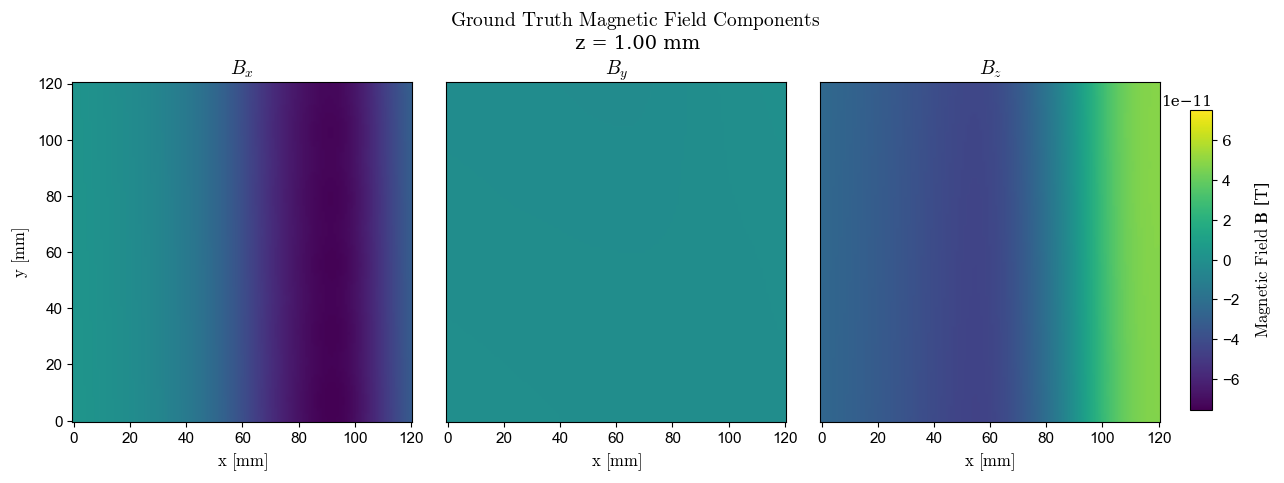

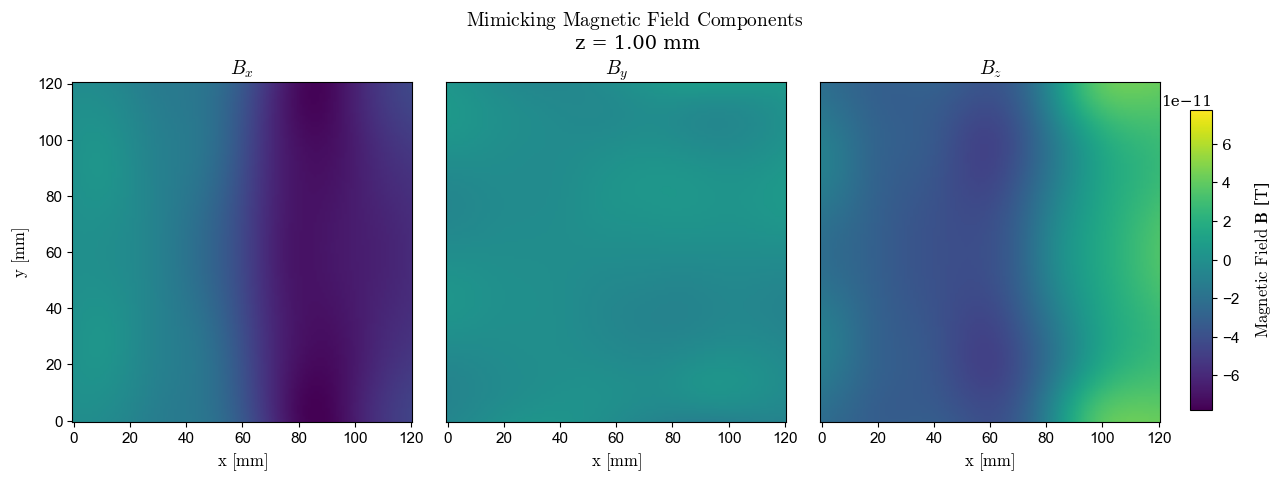

In [143]:
anim = animate_b_field_components(
    field_list=B_truth_list,
    distances_mm=distances_mm,
    cmap='viridis',
    title_prefix=r'$\text{Ground Truth Magnetic Field Components}$',
    save_path="ground_truth_field_evolution.gif",
    writer='ffmpeg',
    fps=4
)

anim2 = animate_b_field_components(
    field_list=B_mimic_list,
    distances_mm=distances_mm,
    cmap='viridis',
    title_prefix=r'$\text{Mimicking Magnetic Field Components}$',
    save_path="mimic_field_evolution.gif",
    fps=4
)

✅ Animation saved as 'magnetic_field_vs_distance_build.gif'


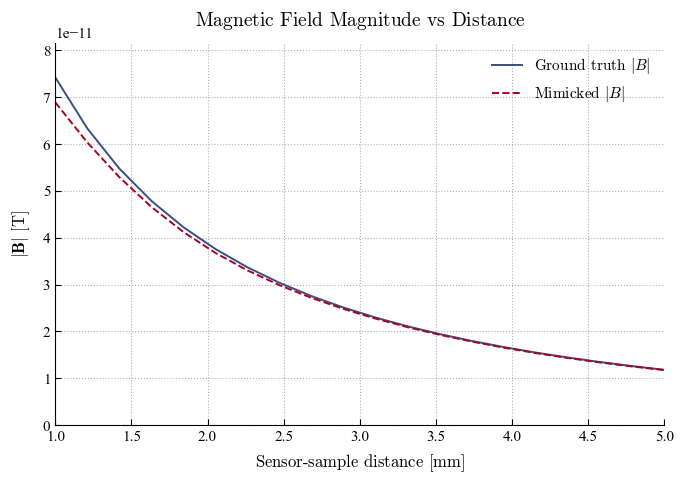

<Figure size 800x600 with 0 Axes>

In [138]:
# ============================================================
# PLOTS
# ============================================================

with matlab_font_style():
    fig, ax = plt.subplots(figsize=(7, 5))

    # --- 1. Static setup of the figure ---
    ax.set_xlabel(r'$\text{Sensor-sample distance [mm]}$', labelpad=6)
    ax.set_ylabel(r'$|\mathbf{B}|\text{ [T]}$', labelpad=8)
    ax.set_title(r'$\text{Magnetic Field Magnitude vs Distance}$', pad=12)
    ax.grid(True, which='both', linestyle=':', color='gray', alpha=0.6)
    ax.tick_params(direction='in', length=4, width=0.8)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.set_xlim(min(distances_mm), max(distances_mm))
    ax.set_ylim(0, max(max(B_truth_mag), max(B_mimic_mag)) * 1.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # --- 2. Initialize empty lines ---
    line_truth, = ax.plot([], [], color='#374f82', lw=1.4, label=r'$\text{Ground truth } |B|$')
    line_mimic, = ax.plot([], [], color='#aa0024', linestyle='--', lw=1.4, label=r'$\text{Mimicked } |B|$')

    ax.legend(frameon=False, fontsize=11, loc='upper right')
    plt.tight_layout()

    # ============================================================
    # ANIMATION FUNCTION
    # ============================================================

    def update(frame):
        # Ensure sequences (so frame=0 doesn’t error)
        x = np.array(distances_mm[:frame + 1]).ravel()
        y_truth = np.array(B_truth_mag[:frame + 1]).ravel()
        y_mimic = np.array(B_mimic_mag[:frame + 1]).ravel()

        # Draw curves up to the current frame
        line_truth.set_data(x, y_truth)
        line_mimic.set_data(x, y_mimic)

        return line_truth, line_mimic

    # ============================================================
    # CREATE ANIMATION
    # ============================================================

    anim = FuncAnimation(fig, update, frames=len(distances_mm),
                         interval=400, blit=True, repeat=False)

    # --- Save as GIF (or MP4 if FFmpeg is available) ---
    try:
        writer = PillowWriter(fps=4)
        anim.save("magnetic_field_vs_distance_build.gif", writer=writer)
        print("✅ Animation saved as 'magnetic_field_vs_distance_build.gif'")
    except Exception as e:
        print(f"⚠️ Animation could not be saved: {e}")

    plt.show()

RuntimeError: x must be a sequence

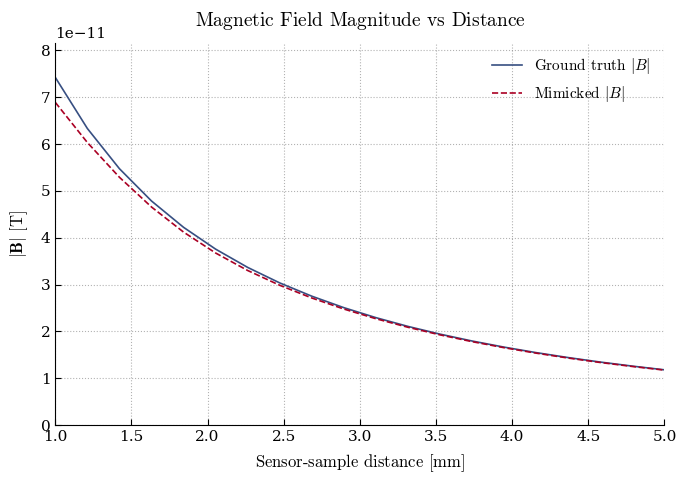

In [135]:
with matlab_font_style():
    fig, ax = plt.subplots(figsize=(7, 5))

    # --- 1. Plot the static curves ---
    ax.plot(distances_mm, B_truth_mag, color='#374f82', lw=1.2, label=r'$\text{Ground truth } |B|$')
    ax.plot(distances_mm, B_mimic_mag, color='#aa0024', linestyle='--', lw=1.2, label=r'$\text{Mimicked } |B|$')

    # --- 2. Add moving markers (start invisible) ---
    point_truth, = ax.plot([], [], 'o', color='#374f82', markersize=7)
    point_mimic, = ax.plot([], [], 'o', color='#aa0024', markersize=7, alpha=0.8)

    # --- 3. Labels, title, legend ---
    ax.set_xlabel(r'$\text{Sensor-sample distance [mm]}$', labelpad=6)
    ax.set_ylabel(r'$|\mathbf{B}|\text{ [T]}$', labelpad=8)
    ax.set_title(r'$\text{Magnetic Field Magnitude vs Distance}$', pad=12)
    ax.legend(frameon=False, fontsize=11, loc='upper right')

    # --- 4. Axes formatting ---
    ax.grid(True, which='both', linestyle=':', color='gray', alpha=0.6)
    ax.tick_params(direction='in', length=4, width=0.8)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.set_xlim(min(distances_mm), max(distances_mm))
    ax.set_ylim(0, max(max(B_truth_mag), max(B_mimic_mag)) * 1.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()

    # ============================================================
    # ANIMATION FUNCTION
    # ============================================================

    def update(frame):
        # Update the markers to the current distance and field magnitude
        point_truth.set_data(distances_mm[frame], B_truth_mag[frame])
        point_mimic.set_data(distances_mm[frame], B_mimic_mag[frame])
        return point_truth, point_mimic

    # ============================================================
    # CREATE ANIMATION
    # ============================================================

    anim = FuncAnimation(fig, update, frames=len(distances_mm),
                         interval=400, blit=True, repeat=False)

    # --- Save as GIF (FFmpeg optional for MP4) ---
    try:
        writer = PillowWriter(fps=4)
        anim.save("magnetic_field_vs_distance.gif", writer=writer)
        print("✅ Animation saved as 'magnetic_field_vs_distance.gif'")
    except Exception as e:
        print(f"⚠️ Animation could not be saved: {e}")

    plt.show()

##### Magnetic field per layer

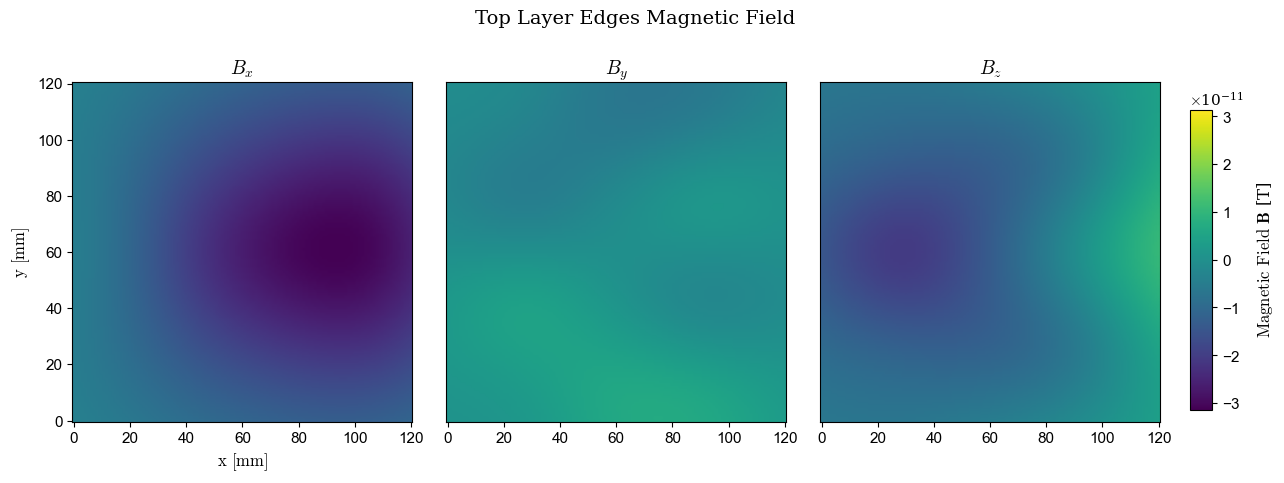

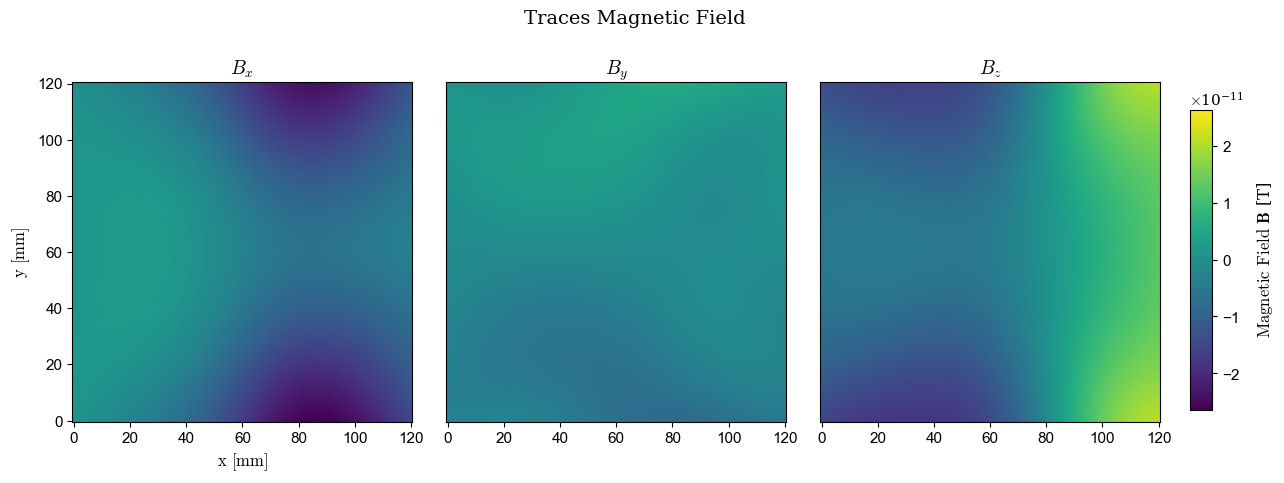

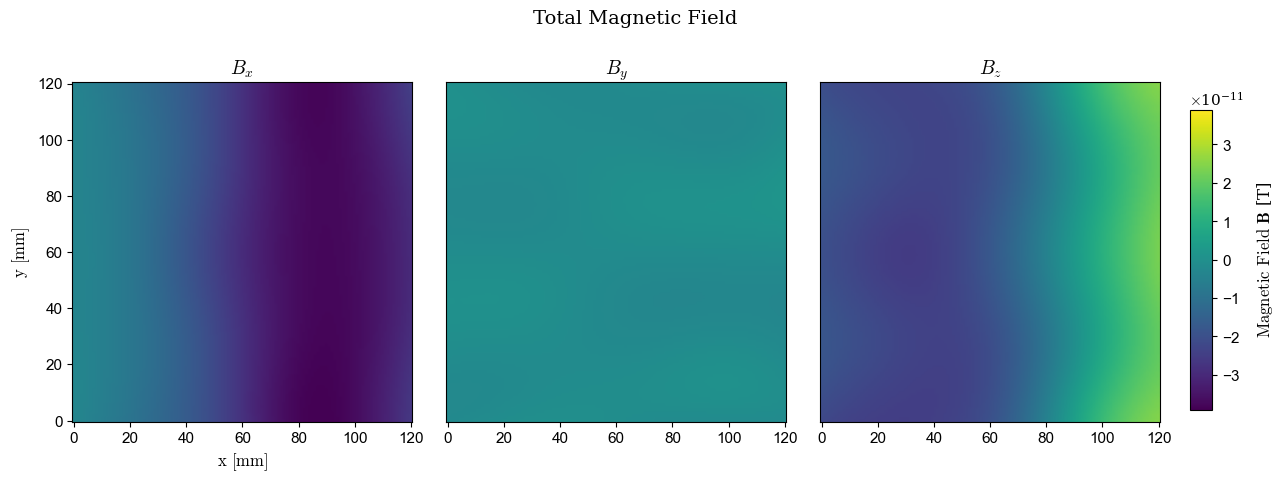

In [74]:
Bx_pcb, By_pcb, Bz_pcb = B_pcb_grid[0], B_pcb_grid[1], B_pcb_grid[2]
data_pcb = np.stack([Bx_pcb, By_pcb, Bz_pcb], axis=0)

fig = plot_b_field_components(data_pcb, units='T', title='Top Layer Edges Magnetic Field')

Bx_traces, By_traces, Bz_traces = B_traces[0], B_traces[1], B_traces[2]
data_traces = np.stack([Bx_traces, By_traces, Bz_traces], axis=0)

fig = plot_b_field_components(data_traces, units='T', title='Traces Magnetic Field')

B_total = B_pcb_grid + B_traces

Bx_total, By_total, Bz_total = B_total[0], B_total[1], B_total[2]
data_total = np.stack([Bx_total, By_total, Bz_total], axis=0)

fig = plot_b_field_components(data_total, units='T', title='Total Magnetic Field')


"\nB_tot_layer = B_in1 + B_in2 + B_bottom\n\nBx_tot_layer, By_tot_layer, Bz_tot_layer = B_tot_layer[0], B_tot_layer[1], B_tot_layer[2]\ndata_tot_layer = np.stack([Bx_tot_layer, By_tot_layer, Bz_tot_layer], axis=0)\n\nfig = plot_n_components(\n    data_tot_layer,\n    units='T',\n    cmap='inferno',\n    labels=['Bx','By','Bz'],\n    alignment='horizontal',\n    symmetric=True,\n    show=True,\n    title='All Layers Magnetic Field'\n)\n"

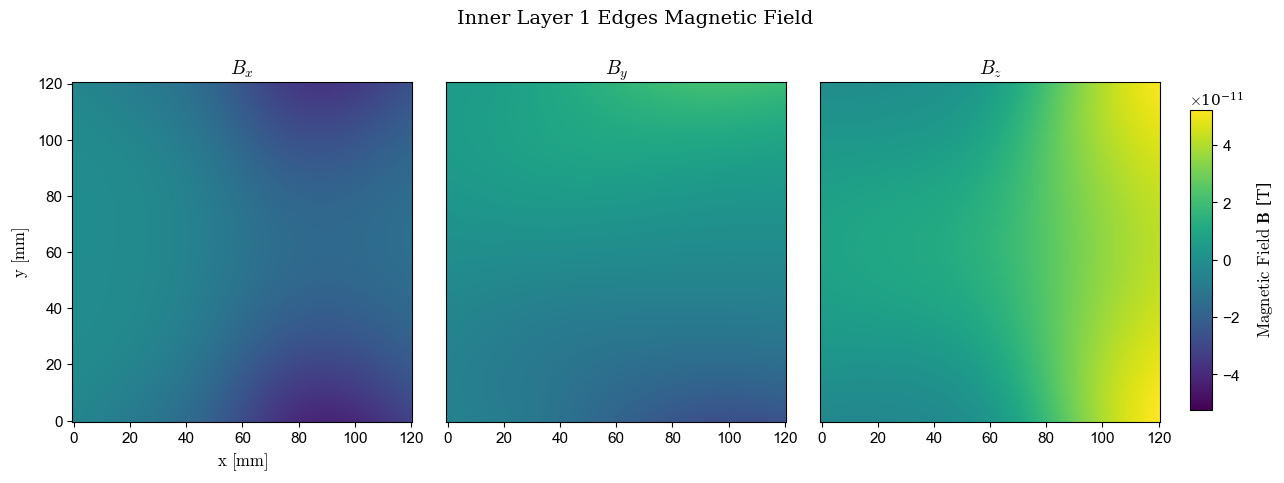

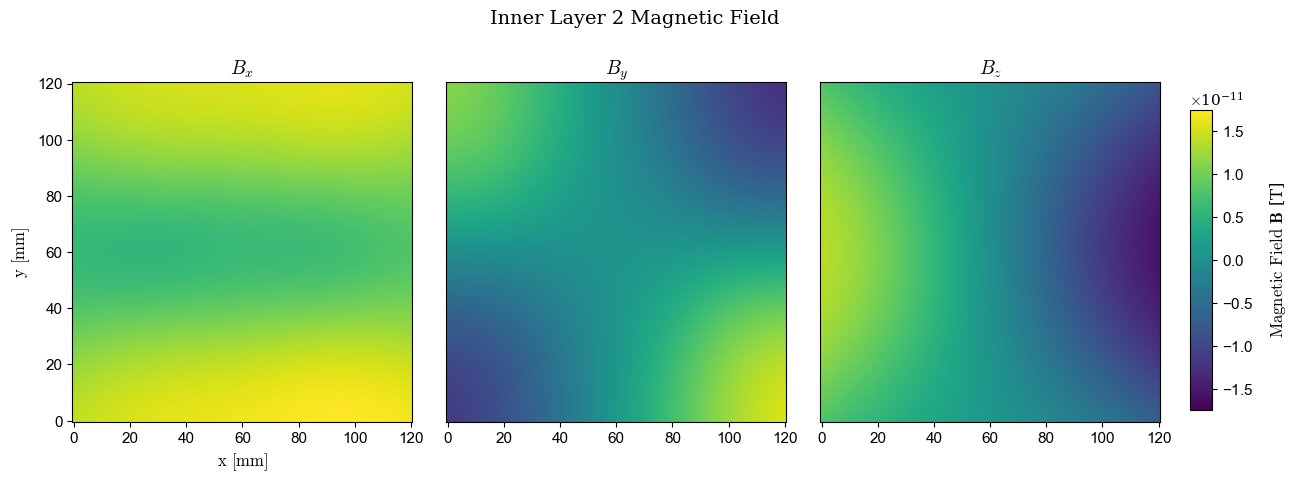

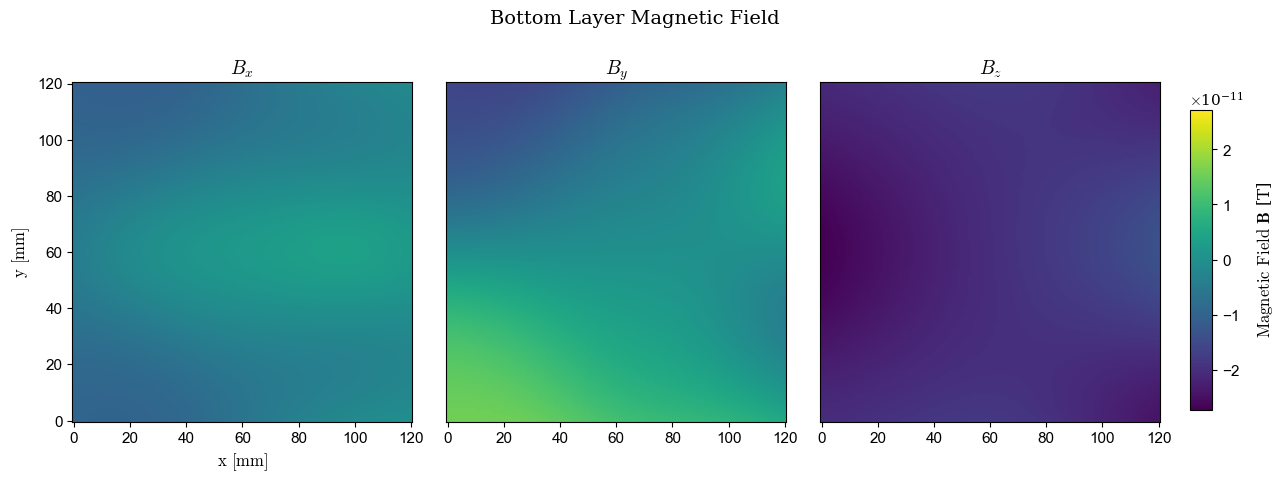

In [72]:
layers = [
    0.00010000000000000003,
    -0.001545,
    -0.00141,
    -3.499999999999997e-05
]

xmin, xmax, ymin, ymax = roi['bounds']
x_c = 0.5*(xmin + xmax)
y_c = 0.5*(ymin + ymax)

L_pcb = 0.03
xmin_pcb = x_c - L_pcb/2
xmax_pcb = x_c + L_pcb/2
ymin_pcb = y_c - L_pcb/2
ymax_pcb = y_c + L_pcb/2

Nx_ROI, Ny_ROI = 121, 121
sensor_pcb = RegularGridSensor(bounds=(xmin_pcb, xmax_pcb, ymin_pcb, ymax_pcb, z_sensor, z_sensor),
                               resolution=(Nx_ROI, Ny_ROI, 1))
obs_pts_pcb = sensor_roi.points


B_in1 = get_b_from_segments_to_grid(layered_all_trace_segments[layers[3]], layered_trace_segment_I_dict[layers[3]], obs_pts_roi, Nx_ROI, Ny_ROI)
B_in2 = get_b_from_segments_to_grid(layered_all_trace_segments[layers[2]], layered_trace_segment_I_dict[layers[2]], obs_pts_roi, Nx_ROI, Ny_ROI)
B_bottom = get_b_from_segments_to_grid(layered_all_trace_segments[layers[1]], layered_trace_segment_I_dict[layers[1]], obs_pts_roi, Nx_ROI, Ny_ROI)

Bx_in1, By_in1, Bz_in1 = B_in1[0], B_in1[1], B_in1[2]
data_in1 = np.stack([Bx_in1, By_in1, Bz_in1], axis=0)

fig = plot_b_field_components(data_in1, units='T', title='Inner Layer 1 Edges Magnetic Field')

Bx_in2, By_in2, Bz_in2 = B_in2[0], B_in2[1], B_in2[2]
data_in2 = np.stack([Bx_in2, By_in2, Bz_in2], axis=0)

fig = plot_b_field_components(data_in2, units='T', title='Inner Layer 2 Magnetic Field')

Bx_bottom, By_bottom, Bz_bottom = B_bottom[0], B_bottom[1], B_bottom[2]
data_bottom = np.stack([Bx_bottom, By_bottom, Bz_bottom], axis=0)

fig = plot_b_field_components(data_bottom, units='T', title='Bottom Layer Magnetic Field')

'''
B_tot_layer = B_in1 + B_in2 + B_bottom

Bx_tot_layer, By_tot_layer, Bz_tot_layer = B_tot_layer[0], B_tot_layer[1], B_tot_layer[2]
data_tot_layer = np.stack([Bx_tot_layer, By_tot_layer, Bz_tot_layer], axis=0)

fig = plot_n_components(
    data_tot_layer,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='All Layers Magnetic Field'
)
'''


### Optimal Distance Estimation

<b>Objective: </b>The optimal distance between the phantom and the NV-diamond sensor is determined by balancing the accuracy of the magnetic field reconstruction, the amplitude of the reconstructed currents, and the magnitude of the resulting magnetic field. Let $E_B(d)$ denote the normalized reconstruction error, $B_{\mathrm{mean}}(d)$ the normalized mean magnetic field amplitude, and $w_1$, $w_2$ the corresponding weighting coefficients. 
The optimal sensor-sample distance $d_\mathrm{opt}$ is obtained as $$\begin{aligned} &d_\mathrm{opt} = \arg\min_{d} \Big[ w_1\,E_B^{*}(d) - w_2\,B_{\mathrm{mean}}^{*}(d) \Big], \\ &\text{s.t.} \quad I_{\min,\mathrm{res}} \le |I_i(d)| \le I_{\max,\mathrm{HW}}, \quad \forall i. \end{aligned}$$
The optimal distance is therefore obtained minimizing an objective function that includes the reconstruction error and the magnitude of the magnetic field. A penalty is issued if the reconstructed currents exceed the bounds defined because of the DAC we use (AD5370). The latter can output at most 4.1mA and has a resolution of $$I_{min}=\frac{12V}{2^{16}*1k\Omega}$$


#### Sample-Diamond Distance Uncertainty (sensitivity analysis of the foward model to parameter uncertainty)

<b>Objective:</b> Since the exact distance between the sample and the diamond cannot be precisely determined, we to assess how uncertainty in this parameter influences the reconstruction process. The objective is to establish the range of distance uncertainties within which the reconstruction remains sufficiently accurate.

In [ ]:
print("Step 1: Solving for I_solution at nominal distance (z_nom)...")

# Define nominal distance (e.g., 4mm)
z_nominal_mm = 2.0
z_nom = z_nominal_mm * MM
z_fixed_nom = max(z_u) + z_nom

sensor_nom = RegularGridSensor(bounds=(xmin, xmax, ymin, ymax, z_fixed_nom, z_fixed_nom),
                               resolution=(Nx_ROI, Ny_ROI, 1))
obs_pts_nom = sensor_nom.points

B_truth_roi_nom = get_b_from_monopoles_to_grid(gcs1, gds1, obs_pts_roi, Nx_ROI, Ny_ROI)
B_truth_roi_t_nom = B_truth_roi_nom[:, :, :, t_idx]     # (3, Nx_ROI, Ny_ROI)
B_truth_nom_flat_vector = B_truth_roi_t_nom.reshape(3 * Nx_ROI * Ny_ROI) # (3*N_pts,)
B_truth_nom_vector_col = B_truth_roi_t_nom.reshape(3 * Nx_ROI * Ny_ROI, 1) # (3*N_pts, 1)


A_edges_nom = get_A_matrix(obs_pts_nom, edges_trim)
A_traces_start_nom = get_A_matrix_traces_split(obs_pts_nom, phantom_start_traces, sign=-1.0)
A_traces_end_nom = get_A_matrix_traces_split(obs_pts_nom, phantom_end_traces, sign=1.0)

M = A_edges_nom.shape[1]
N_rows = A_edges_nom.shape[0]

A_total_nom = np.zeros((N_rows, M), dtype=np.float64)

for m in range(M):
    A_column_nom = A_edges_nom[:,m] + A_traces_start_nom[:,m] + A_traces_end_nom[:,m]
    A_total_nom[:,m] = A_column_nom

B_truth_vector_nom = B_truth_roi_t_nom.reshape(3 * Nx_ROI * Ny_ROI, 1)
I_total_sol_nom, _, _, _ = np.linalg.lstsq(A_total_nom, B_truth_vector_nom, rcond=None)

edge_I_roi_nom = {}
for i, (p_raw, q_raw) in enumerate(edges_trim):
    key = undirected_key(np.array(p_raw), np.array(q_raw))
    edge_I_roi_nom[key] = I_total_sol_nom[i, 0]

B_pcb_grid_nom = get_b_from_edges_to_grid(edges_trim, edge_I_roi_nom, obs_pts_nom, Nx_ROI, Ny_ROI)

trace_segment_I_dict_nom = {}
all_trace_segments_nom = []

layered_all_trace_segments_nom: Dict[float, List[Tuple[Tuple, Tuple]]] = defaultdict(list)
layered_trace_segment_I_dict_nom: Dict[float, Dict[str, float]] = defaultdict(dict)

for i, trace in enumerate(phantom_start_traces):
    I_k = I_total_sol_nom[i, 0]
    I_trace = -I_k # Current flows opposite to loop current I_k
    
    for p_raw, q_raw in trace:
        p = np.asarray(p_raw, dtype=np.float64)
        q = np.asarray(q_raw, dtype=np.float64)
        key = undirected_key(p, q)
        
        # The segment's geometric direction is P->Q (Top->Bottom).
        # I_trace is the signed current relative to this geometric direction.
        trace_segment_I_dict_nom[key] = I_trace
        all_trace_segments_nom.append((p_raw, q_raw))

        Z_coords_to_assign = set()
        
        if abs(p_raw[2] - q_raw[2]) < 1e-9:
            Z_coords_to_assign.add(p_raw[2])
        else:
            Z_coords_to_assign.add(p_raw[2])
            Z_coords_to_assign.add(q_raw[2])
        
        for z in Z_coords_to_assign:
            layered_all_trace_segments_nom[z].append((p_raw, q_raw))
            layered_trace_segment_I_dict_nom[z][key] = I_trace


# Process End Traces (Physical current = +I_k)
for i, trace in enumerate(phantom_end_traces):
    I_k = I_total_sol_nom[i, 0]
    I_trace = I_k # Current flows with loop current I_k
    
    for p_raw, q_raw in trace:
        p = np.asarray(p_raw, dtype=np.float64)
        q = np.asarray(q_raw, dtype=np.float64)
        key = undirected_key(p, q)
        
        # The segment's geometric direction is P->Q (Top->Bottom).
        # I_trace is the signed current relative to this geometric direction.
        trace_segment_I_dict_nom[key] = I_trace
        all_trace_segments_nom.append((p_raw, q_raw))

        Z_coords_to_assign = set()
        
        if abs(p_raw[2] - q_raw[2]) < 1e-9:
            Z_coords_to_assign.add(p_raw[2])
        else:
            Z_coords_to_assign.add(p_raw[2])
            Z_coords_to_assign.add(q_raw[2])
        
        for z in Z_coords_to_assign:
            layered_all_trace_segments_nom[z].append((p_raw, q_raw))
            layered_trace_segment_I_dict_nom[z][key] = I_trace

layered_all_trace_segments_nom = dict(layered_all_trace_segments_nom)
layered_trace_segment_I_dict_nom = dict(layered_trace_segment_I_dict_nom)

B_traces_nom = get_b_from_segments_to_grid(all_trace_segments_nom, trace_segment_I_dict_nom, obs_pts_nom, Nx_ROI, Ny_ROI)

B_total_nom = B_pcb_grid_nom + B_traces_nom

print("Step 2: Starting positional uncertainty sweep...")

delta_z_mm_range = np.linspace(-1, 1, 21)
delta_z_m_range = delta_z_mm_range * MM

B_sweep = []
for delta_z in delta_z_m_range:
    z_actual = z_nom + delta_z
    z_fixed_actual = max(z_u) + z_actual

    sensor_actual = RegularGridSensor(
        bounds=(xmin, xmax, ymin, ymax, z_fixed_actual, z_fixed_actual),
        resolution=(Nx_ROI, Ny_ROI, 1)
    )
    obs_pts_actual = sensor_actual.points

    # Reuse I_solution_nom to compute field at each new distance
    edge_I_roi_act = {undirected_key(np.array(p), np.array(q)): I_total_sol_nom[i, 0]
                      for i, (p, q) in enumerate(edges_trim)}
    B_pcb_grid_act = get_b_from_edges_to_grid(edges_trim, edge_I_roi_act, obs_pts_actual, Nx_ROI, Ny_ROI)

    trace_segment_I_dict_act = {}
    for i, trace in enumerate(phantom_start_traces):
        I_k = I_total_sol_nom[i, 0]
        for p_raw, q_raw in trace:
            key = undirected_key(np.array(p_raw), np.array(q_raw))
            trace_segment_I_dict_act[key] = -I_k
    for i, trace in enumerate(phantom_end_traces):
        I_k = I_total_sol_nom[i, 0]
        for p_raw, q_raw in trace:
            key = undirected_key(np.array(p_raw), np.array(q_raw))
            trace_segment_I_dict_act[key] = I_k

    B_traces_act = get_b_from_segments_to_grid(all_trace_segments, trace_segment_I_dict_act, obs_pts_actual, Nx_ROI, Ny_ROI)
    B_total_act = B_pcb_grid_act + B_traces_act

    B_sweep.append(B_total_act)

# ============================================================
# STEP 3: MANUAL pixel selection (replace ginput)
# ============================================================

# Option 1: choose the center pixel automatically
ix = Nx_ROI // 2
iy = Ny_ROI // 2

print(f"Using pixel indices: ix = {ix}, iy = {iy}")

# ============================================================
# STEP 4: Compute field vs distance at that pixel
# ============================================================

Bx_list, By_list, Bz_list, Bmag_list = [], [], [], []

for B in B_sweep:
    Bx, By, Bz = B[0, ix, iy], B[1, ix, iy], B[2, ix, iy]
    Bx_list.append(Bx)
    By_list.append(By)
    Bz_list.append(Bz)
    Bmag_list.append(np.sqrt(Bx**2 + By**2 + Bz**2))

Bx_list, By_list, Bz_list, Bmag_list = map(np.array, [Bx_list, By_list, Bz_list, Bmag_list])


Step 1: Solving for I_solution at nominal distance (z_nom)...
Step 2: Starting positional uncertainty sweep...
Using pixel indices: ix = 60, iy = 60


#### Current Reconstruction Gaussian Noise Interference (Monte Carlo Forward Model Analysis)

<b>Objective: </b>Evaluate the robustness of the reconstructed magnetic field to experimental uncertainties. 

Additive Gaussian noise was introduced into the reconstructed current vector. Each reconstructed current $I_i$ was perturbed according to $$I_i^{\text{noisy}} = I_i + \mathcal{N}(0, \sigma^2)$$ where $\sigma = \alpha |I_i|$ and $\alpha$ represents the relative noise amplitude 
(here set to $2\%$).

In [333]:
# --- 1. Define parameters for noise simulation ---
n_realizations = 50     
noise_level = 0.02       # 2% Gaussian noise on currents

# Flatten current vector for convenience
I_sol = I_total_sol.flatten()
M = len(I_sol)

# --- 2. Compute baseline magnetic field (already available) ---
B_baseline = B_total.copy()  # shape (3, Nx, Ny)

# --- 3.  simulation ---
B_noisy_list = []

for k in range(n_realizations):
    # Add Gaussian noise to reconstructed currents
    I_noisy = I_sol + np.random.normal(0, noise_level * np.abs(I_sol))
    
    # Map back to edge keys
    edge_I_noisy = {}
    for i, (p_raw, q_raw) in enumerate(edges_trim):
        key = undirected_key(np.array(p_raw), np.array(q_raw))
        edge_I_noisy[key] = I_noisy[i]
    
    # Compute magnetic field for noisy currents
    B_pcb_noisy = get_b_from_edges_to_grid(edges_trim, edge_I_noisy, obs_pts_roi, Nx_ROI, Ny_ROI)
    
    # Traces contribution 
    trace_I_noisy_dict = {}
    for i, trace in enumerate(phantom_start_traces):
        I_k = I_noisy[i]
        I_trace = -I_k
        for p_raw, q_raw in trace:
            key = undirected_key(np.array(p_raw), np.array(q_raw))
            trace_I_noisy_dict[key] = I_trace
    for i, trace in enumerate(phantom_end_traces):
        I_k = I_noisy[i]
        I_trace = I_k
        for p_raw, q_raw in trace:
            key = undirected_key(np.array(p_raw), np.array(q_raw))
            trace_I_noisy_dict[key] = I_trace
    
    B_traces_noisy = get_b_from_segments_to_grid(all_trace_segments, trace_I_noisy_dict, obs_pts_roi, Nx_ROI, Ny_ROI)
    
    B_noisy = B_pcb_noisy + B_traces_noisy
    B_noisy_list.append(B_noisy)

# --- 4. Quantify uncertainty in B ---
B_noisy_stack = np.stack(B_noisy_list, axis=-1)  # shape: (3, Nx, Ny, n_realizations)

## -

In [ ]:
edges_full = grid_graph_from_monopoles(gcs_z0) 
edges_roi = filter_edges_in_roi(edges_full, roi['bounds'])
dead_each = 0.4*MM

bounds_roi = (xmin, xmax, ymin, ymax, min(z_u), max(z_u))

# Take frame 0
grid = gcs_z0[:, :, 0, :]  # (ny, nx, 3)

# Mask centers inside ROI
mask = centers_in_roi_mask(grid, (xmin, xmax, ymin, ymax))

# Apply mask
roi_centers = grid[mask]  # (N_roi, 3)

# Reshape back to (ny, nx, 1, 3) so it matches what the plotting function expects
roi_grid = np.zeros((grid.shape[0], grid.shape[1], 1, 3))
roi_grid[:] = np.nan  # start with NaN so non-ROI centers disappear
roi_grid[mask, 0, :] = roi_centers

ny_squares, nx_squares, _ = grid.shape
all_square_centers = (grid[:ny_squares-1, :nx_squares-1, :] +
                      grid[1:, :nx_squares-1, :] +
                      grid[:ny_squares-1, 1:, :] +
                      grid[1:, 1:, :]) / 4.0

# --- Filter to find only the square centers in the ROI (CORRECTED LOGIC) ---
mask_x = (all_square_centers[..., 0] >= xmin) & (all_square_centers[..., 0] <= xmax)
mask_y = (all_square_centers[..., 1] >= ymin) & (all_square_centers[..., 1] <= ymax)

# Combine masks to find squares with centers fully inside the ROI
roi_square_centers = all_square_centers[mask_x & mask_y]

# Reshape the array to a list of coordinates
square_centers = roi_square_centers.reshape(-1, 3)

loop_radius = 0.5e-3  # A radius of 45% of the grid spacing

# Create a list to store the loop information
loops_roi = []

# Iterate through each center in the ROI and create a loop
for center_coords in square_centers:
    # We define each loop by its center coordinates and its radius
    # The z-coordinate of the loop is the same as its center
    loop_info = {
        'center_x': center_coords[0],
        'center_y': center_coords[1],
        'center_z': center_coords[2],
        'radius': loop_radius
    }
    loops_roi.append(loop_info)


plot_geometry(bounds_roi, roi_grid, edges_roi,
                          dx_s=1.35e-3, dy_s=1.35e-3,
                          dead_each=0.4*MM,
                          elev=45, azim=70, loops=loops_roi)   # set a small int to declutter

In [ ]:
import numpy as np
from numba import njit, float64, prange

import numpy as np
from numba import njit, float64, prange

@njit(float64(float64))
def ellipk_agm(m):
    # Complete elliptic integral of the first kind K(m)
    if m >= 1.0:
        return np.inf
    a = 1.0
    b = np.sqrt(1.0 - m)
    while True:
        a_n = 0.5 * (a + b)
        b_n = np.sqrt(a * b)
        if np.abs(a_n - a) < 1e-15:
            return np.pi / (2.0 * a_n)
        a = a_n
        b = b_n

@njit(float64(float64))
def ellipe_agm(m):
    # Complete elliptic integral of the second kind E(m)
    if m >= 1.0:
        return 1.0
    a = 1.0
    b = np.sqrt(1.0 - m)
    c = np.sqrt(m)
    S = 0.0
    while True:
        a_n = 0.5 * (a + b)
        b_n = np.sqrt(a * b)
        c_n = 0.5 * (a - b)
        S_n = S + c * a
        if np.abs(a_n - a) < 1e-15:
            return S_n + (np.pi * a_n * c_n) / (2.0 * b_n)
        a = a_n
        b = b_n
        c = c_n
        S = S_n

@njit(parallel=True)
def get_b_njit_loop(loop_center, loop_radius, obs_pts, current=1.0):
    mu_0 = 4.0 * np.pi * 1e-7
    R = loop_radius
    N_sensors = obs_pts.shape[0]

    B_x = np.zeros(N_sensors, dtype=np.float64)
    B_y = np.zeros(N_sensors, dtype=np.float64)
    B_z = np.zeros(N_sensors, dtype=np.float64)
    
    eps = 1e-15

    for i in prange(N_sensors):
        x = obs_pts[i, 0] - loop_center[0]
        y = obs_pts[i, 1] - loop_center[1]
        z = obs_pts[i, 2] - loop_center[2]
        
        rho_sq = x*x + y*y
        rho = np.sqrt(rho_sq)
        
        # Add a small epsilon to the denominator to prevent division by zero
        denom = (R + rho)
        denom = denom*denom + z*z + eps
        k2 = (4.0 * R * rho) / denom

        # Clamp k^2 into a safe range for the elliptic integrals
        if k2 < 0.0:
            k2 = 0.0
        elif k2 > 1.0:
            k2 = 1.0 - 1e-15

        K = ellipk_agm(k2)
        E = ellipe_agm(k2)
        
        c = mu_0 / (2.0 * np.pi)
        gamma = 1.0 / np.sqrt(denom)

        denom2 = (R - rho)
        denom2 = denom2*denom2 + z*z + eps

        B_rho_temp = (E * (R*R + rho_sq + z*z) / denom2 - K)
        B_z_temp   = (K + E * (R*R - rho_sq - z*z) / denom2)

        if rho < 1e-12:
            B_x[i] = 0.0
            B_y[i] = 0.0
            B_z[i] = (mu_0 * current * R*R) / (2.0 * (R*R + z*z + eps)**1.5)
        else:
            B_rho = c * gamma * current * (z / (rho + eps)) * B_rho_temp
            B_z_final = c * gamma * current * B_z_temp
            B_x[i] = B_rho * (x / (rho + eps))
            B_y[i] = B_rho * (y / (rho + eps))
            B_z[i] = B_z_final
            
    return np.stack((B_x, B_y, B_z), axis=1)

def get_A_loops_matrix(obs_pts, loops_roi):
    N_sensors = obs_pts.shape[0]
    N_loops = len(loops_roi)
    A_loops = np.zeros((3 * N_sensors, N_loops), dtype=np.float64)
    unit_current = 1.0

    obs_pts_f64 = np.ascontiguousarray(obs_pts, dtype=np.float64)

    for j, loop_info in enumerate(loops_roi):
        center = np.array(
            [loop_info['center_x'], loop_info['center_y'], loop_info['center_z']],
            dtype=np.float64
        )
        radius = float(loop_info['radius'])

        B_field = get_b_njit_loop(center, radius, obs_pts_f64, current=unit_current)
        A_loops[:, j] = B_field.ravel()

    return A_loops


In [ ]:
A_edges = get_A_matrix(obs_pts_roi, edges_roi)

A_loop = get_A_loops_matrix(obs_pts_roi, loops_roi)

A = np.hstack([A_edges, A_loop])

In [ ]:
optimal_lambda = 0.0 

B_truth_vector = B_truth_roi_t.reshape(3 * Nx_ROI * Ny_ROI, 1)

A_reg = np.vstack([A, optimal_lambda * np.eye(A.shape[1])])
B_reg = np.vstack([B_truth_vector, np.zeros((A.shape[1], 1))])

I_solution, _, _, _ = np.linalg.lstsq(A_reg, B_reg, rcond=None)

N_edges = A_edges.shape[1]
currents_edges = I_solution[:N_edges, 0]
currents_loops = I_solution[N_edges:, 0]

edge_I_roi = {}
for i, (p_raw, q_raw) in enumerate(edges_roi):
    key = undirected_key(np.array(p_raw), np.array(q_raw))
    edge_I_roi[key] = currents_edges[i]

B_pcb_edges_grid = get_b_from_edges_to_grid(edges_roi, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

B_pcb_loops_grid_raw = np.zeros(obs_pts_roi.shape, dtype=np.float64)
for i, loop_info in enumerate(loops_roi):
    center = np.array([loop_info['center_x'], loop_info['center_y'], loop_info['center_z']])
    radius = loop_info['radius']
    current = currents_loops[i]
    

    B_loop_field = get_b_njit_loop(center, radius, obs_pts_roi, current=current)
    
    
    B_pcb_loops_grid_raw += B_loop_field

B_pcb_loops_grid = B_pcb_loops_grid_raw.T.reshape(3, Nx_ROI, Ny_ROI)


B_pcb_total_grid = B_pcb_edges_grid + B_pcb_loops_grid

B_pcb_total_vector = B_pcb_total_grid.ravel()
B_truth_vector_flat = B_truth_roi_t.ravel()

alpha = np.dot(B_truth_vector_flat, B_pcb_total_vector) / np.dot(B_pcb_total_vector, B_pcb_total_vector)
print(f"Optimal scaling factor (alpha): {alpha}")

# 8. Scale the final magnetic field
B_pcb_grid_scaled = B_pcb_total_grid * alpha

In [ ]:
loop_center = np.array([0.0, 0.0, 0.0], dtype=np.float64)
loop_radius = 1e-3 # 1 cm radius
current = 1.0

# Define the sensor grid parameters
Nx = 100
Ny = 100
z_sensor = 0.1e-3 # 2 cm above the loop plane

# Define the field of view (FOV)
FOV_size = 0.02 # 5 cm side length

x_min = loop_center[0] - FOV_size / 2
x_max = loop_center[0] + FOV_size / 2
y_min = loop_center[1] - FOV_size / 2
y_max = loop_center[1] + FOV_size / 2

# Create a meshgrid for the x and y coordinates
x_coords = np.linspace(x_min, x_max, Nx)
y_coords = np.linspace(y_min, y_max, Ny)
xx, yy = np.meshgrid(x_coords, y_coords, indexing='ij')

# Create the full grid of observation points (Nx*Ny, 3)
obs_pts_grid = np.zeros((Nx * Ny, 3), dtype=np.float64)
obs_pts_grid[:, 0] = xx.ravel()
obs_pts_grid[:, 1] = yy.ravel()
obs_pts_grid[:, 2] = z_sensor

print("Computing magnetic field for the dummy loop...")
B_field_raw = get_b_njit_loop(loop_center, loop_radius, obs_pts_grid, current)

# Reshape the field to the correct grid format for plotting (3, Nx, Ny)
B_field_grid = B_field_raw.T.reshape(3, Nx, Ny)

plot_n_components(B_field_grid)

In [ ]:
import magpylib as mp

loop_mp = mp.current.Circle(
    current=current, 
    diameter=2 * loop_radius, 
    position=loop_center
)
B_magpylib = loop_mp.getB(obs_pts_grid)

In [ ]:
print("--- Magnetic Field Comparison ---")
print(f"Loop Radius: {loop_radius} m, Current: {current} A")
print(f"Observation Points:\n{obs_pts}")

# Calculate the absolute difference
absolute_diff = np.abs(B_field_raw - B_magpylib)
print("\nAbsolute Difference:\n", absolute_diff)

# Calculate the relative error (handle potential division by zero for B-field of 0)
relative_error = np.abs(B_field_raw - B_magpylib) / np.abs(B_magpylib + 1e-15)
print("\nRelative Error:\n", relative_error)

# Check if the results are close
if np.allclose(B_field_raw, B_magpylib, atol=1e-12, rtol=1e-8):
    print("\n✅ The results are in excellent agreement!")
else:
    print("\n❌ The results show a significant difference. Please check your `get_b_njit_loop` function.")

In [ ]:
Bx_pcb, By_pcb, Bz_pcb = B_pcb_grid_scaled[0], B_pcb_grid_scaled[1], B_pcb_grid_scaled[2]
data_pcb = np.stack([Bx_pcb, By_pcb, Bz_pcb], axis=0)

%matplotlib inline
fig = plot_n_components(
    data_pcb,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI, pcb)'
)

In [ ]:
Err = B_pcb_grid_scaled - B_truth_roi_t   # shape (3, Nx_ROI, Ny_ROI)

# 3) Plot error maps with a diverging colormap centered at 0
fig_err = plot_n_components(
    Err,
    units='T',
    cmap='coolwarm',
    labels=['Bx', 'By', 'Bz'],  # Corrected labels
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Component-wise Error (Plane Wave, ROI)'
)

Bref = B_truth_roi_t
Bmax = float(np.nanmax(np.abs(Bref))) if np.isfinite(Bref).any() else 1.0
eps_scale = 1e-4
eps = eps_scale * Bmax
Rel = np.abs(Err) / (np.abs(Bref) + eps)

# thresholds to show (relative error per component)
levels = [0.1]
colors = {0.1: 'k'}
linest = {0.1: '--'}

axes_img = [ax for ax in fig_err.axes if getattr(ax, "images", [])]

# Corrected NV sensor resolution threshold (e.g., 5 nanotesla)
nv_resolution_threshold = 2e-10
relative_error_threshold = 0.1

abs_Err_mag = np.linalg.norm(Err, axis=0)

for k, ax in enumerate(axes_img):
    rel_k = Rel[k]  # Relative error for component k
    err_k = Err[k]  # Absolute error for component k

    # Check the condition component-wise
    good_fit_mask = (rel_k.T <= relative_error_threshold) | (np.abs(err_k.T) <= nv_resolution_threshold)

    ax.imshow(good_fit_mask.astype(float), cmap='Greens',
              alpha=0.2, origin='lower', zorder=0)

    for lev in levels:
        CS = ax.contour(good_fit_mask, levels=[lev], colors=colors[lev],
                        linewidths=1.2, linestyles=linest[lev], origin='lower')
        #ax.clabel(CS, fmt={lev: f'{int(lev*100)}%'}, inline=True, fontsize=8)

plt.draw()

### Spiral data

In [77]:
N = 121203 # Number of points
T = 151 # Time steps

# shape is (N, 3*T)
current_density_series_flat = np.loadtxt("/Users/ValerioDeSio/Desktop/PythonThesis/current_density_series2.csv", delimiter=",")

# Reshape to (N, 3, T)
cds = current_density_series_flat.reshape(N, 3, T, order="F")  # ← key fix

pts = np.loadtxt("/Users/ValerioDeSio/Desktop/PythonThesis/pts2.csv", delimiter=",")

# unique sorted coordinates
x_u = np.unique(np.round(pts[:,0], 12))
y_u = np.unique(np.round(pts[:,1], 12))
z_u = np.unique(np.round(pts[:,2], 12))

# grid spacings (robust: median of diffs)
dx = np.median(np.diff(x_u))
dy = np.median(np.diff(y_u))
dz = np.median(np.diff(z_u))

volume_element = dx*dy*dz

print(pts.shape)
print(cds.shape)

(121203, 3)
(121203, 3, 151)


In [78]:
%matplotlib inline

dx=1.35e-3
dy=dx
dz=max(z_u)

gds, gcs = get_grid_multipole_expansion_time_3d_pad(
    cds,
    pts,
    cell_size=(dx,dy,dz),  # 3D grid spec (x, y,z)
    volume_element=volume_element
)

# Mask for z=0.0001 plane (midplane)
mask_z0 = np.isclose(pts[:, 2], 0.0001, atol=1e-12)

# Apply mask
pts_z0 = pts[mask_z0]
cds_z0 = cds[mask_z0]  # shape: (N_z0, 3, T)

z_centers = gcs[:, :, :, 0, 2]
z_idx = np.where(np.isclose(z_centers[0, 0, :], 0.0001, atol=1e-12))[0]
z_idx = z_idx[0]

gds_z0 = gds[:, :, z_idx, :, :]
gcs_z0 = gcs[:, :, z_idx, :, :]

edges = grid_graph_from_monopoles(gcs_z0)

bounds = (min(x_u), max(x_u), min(y_u), max(y_u), min(z_u), max(z_u))

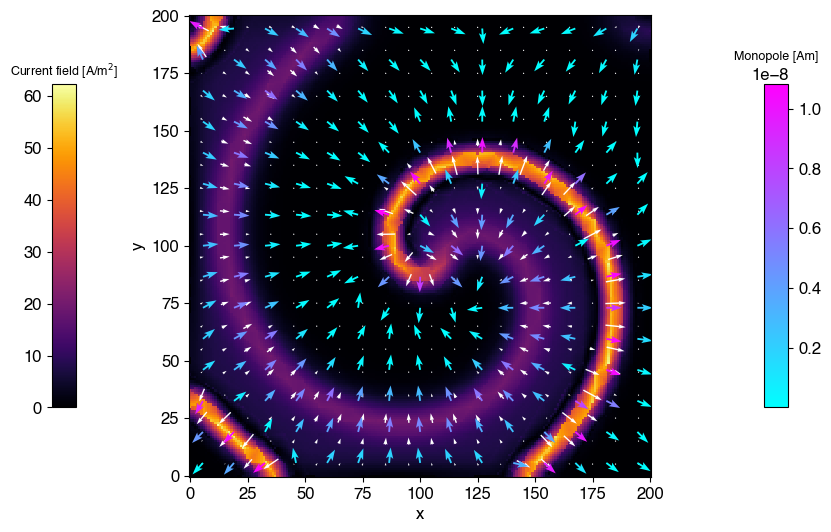

In [79]:
t_idx = 150 # Change according to the time step we evaluate
cds_t = cds_z0[:,:,t_idx]
gds_t = gds_z0[:,:,t_idx]
gcs_t = gcs_z0[:,:,t_idx]

xs_unique = np.unique(np.round(pts_z0[:, 0], 12))
ys_unique = np.unique(np.round(pts_z0[:, 1], 12))

grid_centers_idx = rescale_centers_to_index(gcs_t, xs_unique, ys_unique)

plot_vector_field_2d_monopoles(GridSampler.pts_to_grid(cds_t, 201, 201)[0:2, :, :], gds_t, grid_centers_idx, color='white', units=r'A/m$^2$', units_mono=r'Am', monopole_cmap='cool', cmap='inferno')

ROI center (m): (np.float64(0.003375000000000001), np.float64(0.003375000000000001))
ROI bounds (m): (np.float64(0.0008750000000000008), np.float64(0.005875000000000001), np.float64(0.0008750000000000008), np.float64(0.005875000000000001))


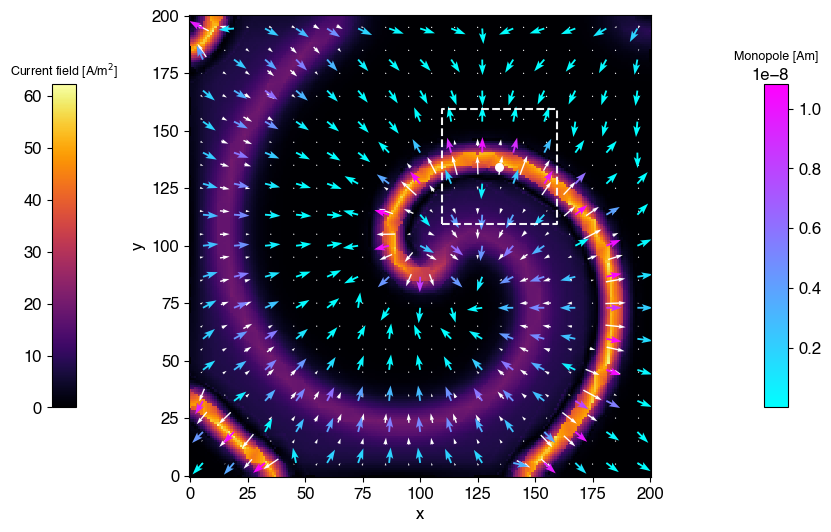

In [80]:
nx, ny = gcs_t.shape[:2]

# Build dictionary
centers_idxed, lookup = index_grid_centers(gcs_t.reshape(nx*ny,3), nx, ny, one_based=True)

p1 = lookup[(10,11)]
p2 = lookup[(11,10)]

roi = roi_from_center(p1, p2)
print("ROI center (m):", roi['center'])
print("ROI bounds (m):", roi['bounds'])

x_min, x_max = min(x_u), max(x_u)
y_min, y_max = min(y_u), max(y_u)

full_bounds_phys = (x_min, x_max, y_min, y_max)

fig = plot_vector_field_2d_monopoles(
    GridSampler.pts_to_grid(cds_t, 201, 201)[0:2, :, :],
    gds_t,
    grid_centers_idx,
    color='white',
    units=r'A/m$^2$',
    units_mono=r'Am',
    monopole_cmap='cool',
    cmap='inferno',
    show=True   # important: keep the figure open for overlays
)

ax, idx_box = draw_roi_box(fig, roi['bounds'], full_bounds_phys,
                           color='white', lw=1.5, ls='--', alpha=0.95)

plt.draw()

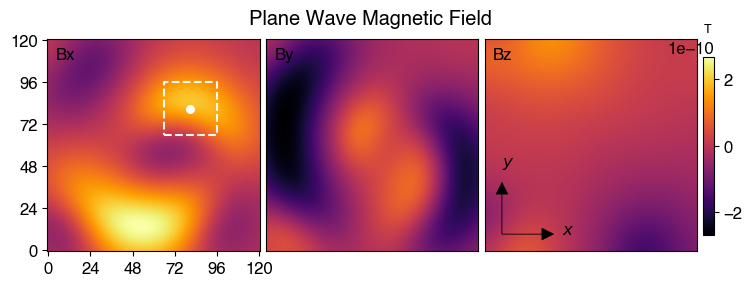

In [81]:
z_sensor = 4e-3

x_min, x_max = min(x_u), max(x_u)
y_min, y_max = min(y_u), max(y_u)

# Center of the slab
x0 = 0.5 * (x_min + x_max)
y0 = 0.5 * (y_min + y_max)

# NV size
FOVx = 2e-2
FOVy = 2e-2

# Resolution
Nx = 121
Ny = 121

bounds = (x0-FOVx/2, x0+FOVx/2,
          y0-FOVy/2, y0+FOVy/2, 
          z_sensor, z_sensor)

bounds_xy = (x0-FOVx/2, x0+FOVx/2,
          y0-FOVy/2, y0+FOVy/2)

sensor = RegularGridSensor(bounds=bounds, resolution=(Nx, Ny, 1))
obs_pts = sensor.points

B_grid = get_b_from_monopoles_to_grid(gcs, gds, obs_pts, Nx, Ny)

t_idx = 150
Bx, By, Bz = B_grid[0,:,:,t_idx], B_grid[1,:,:,t_idx], B_grid[2,:,:,t_idx]

data=np.stack([Bx,By,Bz], axis=0)

fig = plot_n_components(
    data,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field'
)

ax, idx_box = draw_roi_box(fig, roi['bounds'], full_bounds_phys,
                           color='white', lw=1.5, ls='--', alpha=0.95)

plt.draw()



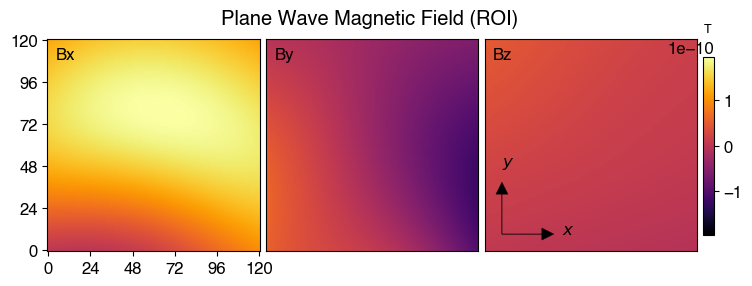

In [82]:
xmin, xmax, ymin, ymax = roi['bounds']
Nx_ROI, Ny_ROI = 121, 121
sensor_roi = RegularGridSensor(bounds=(xmin, xmax, ymin, ymax, z_sensor, z_sensor),
                               resolution=(Nx_ROI, Ny_ROI, 1))
obs_pts_roi = sensor_roi.points

B_truth_roi = get_b_from_monopoles_to_grid(gcs, gds, obs_pts_roi, Nx_ROI, Ny_ROI)
B_truth_roi_t = B_truth_roi[:, :, :, t_idx]     # (3, Nx_ROI, Ny_ROI)

Bx, By, Bz = B_truth_roi_t[0], B_truth_roi_t[1], B_truth_roi_t[2]
data = np.stack([Bx, By, Bz], axis=0)

fig = plot_n_components(
    data,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True,
    title='Plane Wave Magnetic Field (ROI)'
)

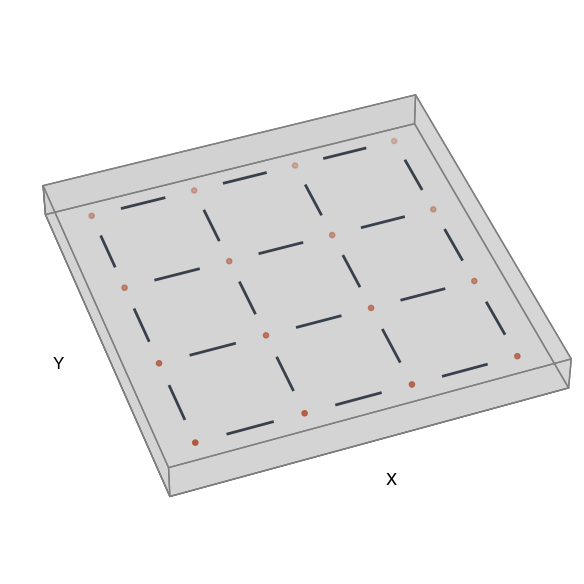

(<Figure size 800x600 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [83]:
edges_full = grid_graph_from_monopoles(gcs_z0)  # uses frame 0; coordinates in meters
edges_roi = filter_edges_in_roi(edges_full, roi['bounds'])
dead_each = 0.4*MM

bounds_roi = (xmin, xmax, ymin, ymax, min(z_u), max(z_u))

# Take frame 0
grid = gcs_z0[:, :, 0, :]  # (ny, nx, 3)

# Mask centers inside ROI
mask = centers_in_roi_mask(grid, (xmin, xmax, ymin, ymax))

# Apply mask
roi_centers = grid[mask]  # (N_roi, 3)

# Reshape back to (ny, nx, 1, 3) so it matches what the plotting function expects
roi_grid = np.zeros((grid.shape[0], grid.shape[1], 1, 3))
roi_grid[:] = np.nan  # start with NaN so non-ROI centers disappear
roi_grid[mask, 0, :] = roi_centers


plot_geometry(bounds_roi, roi_grid, edges_roi,
                          dead_each=0.4*MM,
                          elev=45, azim=70)   # set a small int to declutter

In [85]:
A = get_A_matrix(obs_pts_roi, edges_roi)

I_time_series = []
B_pcb_time_series = []
alpha_time_series = []

B_truth_time_series = B_truth_roi.reshape(-1, 151)

num_time_steps = B_truth_time_series.shape[1]

# Perform regularization for each time step
for t_idx in range(num_time_steps):
    B_truth_vector = B_truth_time_series[:, t_idx].reshape(-1, 1)

    # 3. Apply Tikhonov regularization and solve
    A_reg = np.vstack([A, optimal_lambda * np.eye(A.shape[1])])
    B_reg = np.vstack([B_truth_vector, np.zeros((A.shape[1], 1))])

    I_solution, _, _, _ = np.linalg.lstsq(A_reg, B_reg, rcond=None)
    I_time_series.append(I_solution.flatten())

    # 4. Compute the magnetic field from the reconstructed currents
    edge_I_roi = {}
    for i, (p_raw, q_raw) in enumerate(edges_roi):
        key = undirected_key(np.array(p_raw), np.array(q_raw))
        edge_I_roi[key] = I_solution[i, 0]

    B_pcb_grid = get_b_from_edges_to_grid(edges_roi, edge_I_roi, obs_pts_roi, Nx_ROI, Ny_ROI)

    # 5. Calculate the optimal scaling factor for this time step
    B_pcb_vector = B_pcb_grid.reshape(-1)
    B_truth_vector_flat = B_truth_vector.reshape(-1)

    alpha = np.dot(B_truth_vector_flat, B_pcb_vector) / np.dot(B_pcb_vector, B_pcb_vector)
    alpha_time_series.append(alpha)

    # Scale the final PCB magnetic field and store
    B_pcb_grid_scaled = B_pcb_grid * alpha
    B_pcb_time_series.append(B_pcb_grid_scaled)

# Convert lists to NumPy arrays for easy access
I_time_series = np.array(I_time_series)
B_pcb_time_series = np.array(B_pcb_time_series)
alpha_time_series = np.array(alpha_time_series)

In [ ]:
edge_of_interest_idx = 10 

# Select the current data for the specific edge.
# The first dimension (rows) is time, and the second (columns) is the edge.
current_of_interest = I_time_series[:, edge_of_interest_idx]

# Plot the current over time
plt.figure(figsize=(10, 6))
plt.plot(current_of_interest)
plt.xlabel('Time (s)')
plt.ylabel(f'Current (A) on Edge {edge_of_interest_idx}')
plt.title(f'Reconstructed Current over Time for Edge {edge_of_interest_idx}')
plt.grid(True)
plt.show()